# Prepare Technical Environment

## Virtual Environment Recommended Settings

We used UCloud for processing the code, as the original dataset with 13 Million rows is quite computational intense

Here are the settings we used, anything below was running out of computational resources:
- at least vCPU 16 Cores - 96 GB RAM - 16hr/hr
- Uncomment the Pip Installs on first run
- On the first run, accept the install of all recommended modules (Python + Jupyter)
- Select the Python Kernel "Python 3.12.3"

## Pip installs (virtual environment)

In [ ]:
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install -U scikit-learn
# %pip install numpy
# %pip install time
# %pip install gc
# %pip install IPython
# %pip install scipy
# %pip install geopy
# %pip install category_encoders
# %pip install xgboost
# %pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
Note: you may need to restart the kernel to use updated packages.

## Loading Libraries

In [2]:
import pandas as pd  # Import pandas for Data Manipulation, analysis, and in this case, saving, writing, and reading .csv files into dataframes

In [3]:
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set pandas display options to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.4f' % x if isinstance(x, float) else x)


## Dynamic File Path (Physical Files)

In [4]:
from pathlib import Path  # Import pathlib for handling file paths in a cross-platform manner


base_dir = Path("__file__").parent.resolve() # Dynamically setting the working directory based on the script's location, ensuring compatibility even after zipping and unpacking.
print(base_dir) #Verifying the base directory

raw_data_dir = base_dir / "Raw Datasets" # Define the folder containing the dataset files
print(raw_data_dir) #Verifying the data directory

processed_data_dir = base_dir / "Processed Dataset"
print(processed_data_dir) #Verifying the data directory

plot_data_dir = base_dir / "Generated Plots"
print(plot_data_dir) #Verifying the data directory

# Define the file paths for the relevant datasets
cards_data_path = raw_data_dir / "cards_data.csv" 
print(cards_data_path) #Verifying the path

transactions_data_path = raw_data_dir / "transactions_data.csv"
print(transactions_data_path) #Verifying the path

users_data_path = raw_data_dir / "users_data.csv"
print(users_data_path) #Verifying the path

spending_category_data_path = raw_data_dir / "mcc_codes.json"
print(spending_category_data_path) #Verifying the path

fraud_labels_data_path = raw_data_dir / "train_fraud_labels.json"
print(fraud_labels_data_path) #Verifying the path

/work/Machine Learning Exam
/work/Machine Learning Exam/Raw Datasets
/work/Machine Learning Exam/Processed Dataset
/work/Machine Learning Exam/Generated Plots
/work/Machine Learning Exam/Raw Datasets/cards_data.csv
/work/Machine Learning Exam/Raw Datasets/transactions_data.csv
/work/Machine Learning Exam/Raw Datasets/users_data.csv
/work/Machine Learning Exam/Raw Datasets/mcc_codes.json
/work/Machine Learning Exam/Raw Datasets/train_fraud_labels.json


## Custom Class - AdvancedEDA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time
import gc
import pandas as pd
from IPython.display import display
from scipy import stats



# Define a custom class for advanced exploratory data analysis (EDA)
class AdvancedEDA:
    
    def __init__(self, dataframe):
        # Store the input DataFrame as an instance variable
        self.df = dataframe

    def summary(self):
        # Print basic DataFrame structure and summary information
        print(">>> DataFrame Info:")
        self.df.info()

        print(f"\n{'-'*20}")

        # Identify and summarize numerical columns
        numerical_cols = self.df.select_dtypes(include=[np.number])
        if numerical_cols.empty:
            print(">>> No Numerical Columns Found")
        else:
            print("\n>>> First 3 Rows of Numerical Columns:")
            display(numerical_cols.head(3))

            print("\n>>> Numerical Columns Summary:")
            display(numerical_cols.describe().astype(float))

        print(f"\n{'-'*5}")

        # Identify and summarize categorical columns
        categorical_cols = self.df.select_dtypes(include=['object'])
        if categorical_cols.empty:
            print(">>> No Categorical Columns Found")
        else:
            print("\n>>> Categorical Columns Summary:")
            display(categorical_cols.describe())

            print("\n>>> First 3 Rows of Categorical Columns:")
            display(categorical_cols.head(3))

        print(f"\n{'-'*5}")

        # Display the first few rows of the full DataFrame for context
        print("\n>>> First 3 Rows of Entire DataFrame:")
        display(self.df.head(3))

    def check_skewness(self, columns_to_check=None):
        """
        Evaluate skewness of numeric columns (or specified subset) and categorize skew levels.
        Helpful for detecting non-normal distributions that may need transformation.
        """
        if columns_to_check is None:
            # Default to all numeric columns if none are specified
            columns_to_check = self.df.select_dtypes(include=['int', 'float']).columns.tolist()

        # Print interpretative guidelines for skewness values
        print(f"\n>>> Decision Boundaries for Skewness:")
        print("1. Highly Skewed: Skewness outside the range of [-1, 1]")
        print("2. Moderately Skewed: Skewness in [-1, -0.5] or [0.5, 1]")
        print("3. Mildly Skewed: Skewness within [-0.5, 0.5]\n")

        # Initialize containers for categorization
        highly_skewed_columns = []
        moderately_skewed_columns = []
        mildly_skewed_columns = []

        # Calculate skewness and classify each column
        for column in columns_to_check:
            if column in self.df.columns:
                skewness_value = self.df[column].skew()
                skewness_label = self.get_skewness_label(skewness_value)

                # Append to corresponding skewness group
                if skewness_label == 'Highly Skewed':
                    highly_skewed_columns.append((column, skewness_value))
                elif skewness_label == 'Moderately Skewed':
                    moderately_skewed_columns.append((column, skewness_value))
                else:
                    mildly_skewed_columns.append((column, skewness_value))

        # Helper function to print each group of skewed columns
        def _print_skewed_group(title, group):
            print(f"\n>>> {title} (in descending order):")
            for col, skew in sorted(group, key=lambda x: x[1], reverse=True):
                print(f"Column: [{col}] | Skewness: [{skew:.2f}] | Label: [{title}]")

        # Display results
        _print_skewed_group("Highly Skewed", highly_skewed_columns)
        _print_skewed_group("Moderately Skewed", moderately_skewed_columns)
        _print_skewed_group("Mildly Skewed", mildly_skewed_columns)

        print(f"\n{'-'*5}")

        # Return structured dictionary for further analysis
        return {
            'Highly Skewed': [col for col, _ in highly_skewed_columns],
            'Moderately Skewed': [col for col, _ in moderately_skewed_columns],
            'Mildly Skewed': [col for col, _ in mildly_skewed_columns]
        }

    def get_skewness_label(self, skewness_value):
        """
        Categorize skewness value into descriptive labels for interpretation.
        """
        if skewness_value > 1 or skewness_value < -1:
            return 'Highly Skewed'
        elif 0.5 <= skewness_value <= 1 or -1 <= skewness_value <= -0.5:
            return 'Moderately Skewed'
        else:
            return 'Mildly Skewed'

    def check_outliers(self, columns_to_check, target=None):
        """
        Detect and visualize outliers in specified columns using IQR and Z-score methods.
        Optionally group plots by a target column for class-wise comparison.
        """
        outlier_summary = {}

        for column in columns_to_check:
            if column in self.df.columns:
                plt.figure(figsize=(8, 6))

                if target:
                    # Grouped boxplot by target class
                    sns.boxplot(x=target, y=column, data=self.df)
                    plt.title(f"Boxplot for {column} grouped by {target}")
                else:
                    # Basic boxplot without grouping
                    sns.boxplot(x=self.df[column])
                    plt.title(f"Boxplot for {column}")

                plt.show()

                column_summary = {
                    'IQR_Lower_Bound': None,
                    'IQR_Upper_Bound': None,
                    'Z_Score_Threshold': 3,
                    'Outliers_Identified': False
                }

                # Calculate IQR and determine bounds
                Q1 = self.df[column].quantile(0.25)
                Q3 = self.df[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                column_summary['IQR_Lower_Bound'] = lower_bound
                column_summary['IQR_Upper_Bound'] = upper_bound

                # Identify Z-score outliers
                z_scores = stats.zscore(self.df[column].dropna())
                z_outliers = np.where(np.abs(z_scores) > 3)[0]

                # Flag columns with any outliers
                if len(z_outliers) > 0 or (self.df[column].min() < lower_bound or self.df[column].max() > upper_bound):
                    column_summary['Outliers_Identified'] = True

                # Display outlier bounds and flag
                print(f"\nOutliers for {column}:")
                print(f"- IQR Lower Bound: [{lower_bound:.2f}] | IQR Upper Bound: [{upper_bound:.2f}]")
                print(f"- Z-score-based outliers: Z > 3 or Z < -3 (thresholds: -3 and 3)")
                print(f"- Outliers detected: {column_summary['Outliers_Identified']}")
                
                outlier_summary[column] = column_summary

        return outlier_summary

    # Method to convert columns to datetime based on a dictionary of column names and date formats
    def to_date_time(self, date_formats):
        """
        Converts specified columns to pandas datetime format using provided string formats.
        This ensures temporal consistency and enables further time-based feature engineering.

        :param date_formats: Dictionary where key = column name, value = datetime format string.
        """
        for column, fmt in date_formats.items():
            print(f"\nConverting column: {column} using format: '{fmt}'")

            try:
                # First attempt to convert using the specified format, coercing errors
                self.df[column] = pd.to_datetime(self.df[column], format=fmt, errors='coerce')

                # Enforce pandas datetime type again to ensure dtype consistency
                self.df[column] = pd.to_datetime(self.df[column], errors='coerce')

                print(f"Success: '{column}' converted to dtype {self.df[column].dtype}")
                print(f"Sample values:\n{self.df[column].dropna().head()}")

            except Exception as e:
                # Handle parsing errors gracefully
                print(f"Error converting column '{column}': {e}")

            print("-" * 40)

        return self.df

    # Custom method to clean numeric columns by removing unwanted characters and converting to numeric dtype
    def strip_numeric(self, column_names, chars_to_strip):
        """
        Removes unwanted characters (e.g., currency symbols) and converts values to numeric format.

        :param column_names: List of columns to process.
        :param chars_to_strip: List of characters to remove from each column.
        """
        for column_name in column_names:
            for char in chars_to_strip:
                # Remove each specified character using simple string replacement
                self.df[column_name] = self.df[column_name].str.replace(char, "", regex=False)
            
            # Convert the cleaned column to numeric values, coercing errors to NaN
            self.df[column_name] = pd.to_numeric(self.df[column_name], errors='coerce')

            print(f"\nColumn: {column_name} after stripping characters {chars_to_strip}:")
            print(self.df[column_name].head())
            print(f"DataType: {self.df[column_name].dtype}")
            print(f"\n{'-'*5}")

        return self.df

    def label_encode_columns(self, columns_to_encode):
        """
        Applies label encoding to categorical columns to convert text values into numerical format.
        Useful for algorithms that do not handle categorical strings natively.

        :param columns_to_encode: List of column names to encode.
        :return: Modified DataFrame with encoded columns.
        """
        label_encoder = LabelEncoder()
        
        for column in columns_to_encode:
            # Fit encoder and transform the column
            self.df[column] = label_encoder.fit_transform(self.df[column])

            print(f"Label encoding applied to column: {column}")
            print("Mapping of original values to encoded labels:")

            # Print the encoding mapping (original values to integers)
            mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
            print(mapping)

            # Show a small sample from the encoded column
            print(f"Sample (3 values) from encoded column '{column}': {self.df[column].sample(3, random_state=42).tolist()}")
            print("-" * 40)
        
        return self.df

    def categorical_cardinality(self):
        """
        Reports the number of unique values (cardinality) for each categorical feature.
        Prints unique values if manageable (<= 20), otherwise shows a random sample.
        """
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        cardinality = self.df[categorical_cols].nunique()

        print(f"Cardinality of categorical features:\n{cardinality}\n")
        
        for categorical_column in categorical_cols:
            unique_values = self.df[categorical_column].unique()

            print(f"{categorical_column}: {len(unique_values)} unique values")
            
            if len(unique_values) <= 20:
                # Print all unique values if column is low cardinality
                unique_values_str = ', '.join(unique_values.astype(str))
                print(f"Unique values: {unique_values_str}")
            else:
                print(f"Too many categories to print.")

            # Show a small sample for inspection
            sample_values = self.df[categorical_column].sample(3, random_state=42).tolist()
            print(f"Sample (3 values): {sample_values}\n")

    def plot_categorical_distribution(self, columns, top_n=None, target_column=None, target_value=None):
        """
        Visualizes category distributions using count plots, optionally filtered or grouped by a target column.

        Parameters:
        - columns: Categorical columns to visualize.
        - top_n: Limit the plot to top-N most frequent values.
        - target_column: Optional column to use as hue/grouping.
        - target_value: Optional filter for specific class values.
        """
        # Internal function for consistent coloring
        def get_palette():
            if target_column is None:
                return "Blues"
            elif target_value is not None:
                return ["#e74c3c"]
            else:
                return {0: "#2ecc71", 1: "#e74c3c"}

        num_plots = len(columns)
        rows = num_plots // 2 + num_plots % 2
        plt.figure(figsize=(14, rows * 4))

        for i, column in enumerate(columns):
            plt.subplot(rows, 2, i + 1)
            plot_df = self.df.copy()

            if target_column and target_value is not None:
                plot_df = plot_df[plot_df[target_column] == target_value]

            if top_n:
                # Keep only the top-N most frequent categories
                top_values = plot_df[column].value_counts().nlargest(top_n).index
                plot_df = plot_df[plot_df[column].isin(top_values)]
                order = top_values
            else:
                order = plot_df[column].value_counts().index

            palette = get_palette()

            # Plot conditional countplot logic
            if target_column and target_value is None:
                sns.countplot(data=plot_df, x=column, hue=target_column, order=order, palette=palette)
            else:
                sns.countplot(data=plot_df, x=column, order=order, color=palette[0] if isinstance(palette, list) else None)

            # Aesthetic formatting
            plt.title(f"{column} Distribution")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    def plot_histograms(self, columns, bins=50, target_column=None, target_value=None):
        """
        Generates histograms for numeric columns to assess distributions.
        Can optionally group or filter by target class for comparative analysis.

        Parameters:
        - columns: List of columns to visualize.
        - bins: Number of histogram bins.
        - target_column: If provided, groups histograms by class.
        - target_value: Filters only one class for visual comparison.
        """
        num_plots = len(columns)
        rows = (num_plots + 1) // 2
        plt.figure(figsize=(14, rows * 4))

        for i, column in enumerate(columns):
            plt.subplot(rows, 2, i + 1)
            plot_df = self.df.copy()

            if target_column and target_value is not None:
                # Filter for a single class (e.g., only fraud cases)
                plot_df = plot_df[plot_df[target_column] == target_value]
                color = 'red'
                sns.histplot(plot_df[column], bins=bins, kde=True, color=color)
                plt.title(f"{column} (Filtered: {target_column}={target_value})")
            elif target_column:
                # Plot distributions for each class side-by-side
                palette = {0: 'green', 1: 'red'}
                for cls in sorted(plot_df[target_column].unique()):
                    subset = plot_df[plot_df[target_column] == cls]
                    label = f"{target_column} = {cls}"
                    sns.histplot(subset[column], bins=bins, kde=True, color=palette.get(cls, 'gray'), label=label, alpha=0.6)
                plt.legend()
                plt.title(f"{column} by {target_column}")
            else:
                # Unconditional histogram
                sns.histplot(plot_df[column], bins=bins, kde=True, color='steelblue')
                plt.title(f"{column} Distribution")

            plt.xlabel(column)
            plt.ylabel("Frequency")

        plt.tight_layout()
        plt.show()
        
    def plot_scatter_matrix(self, columns, target_column=None, target_value=None, diagonal='kde', alpha=0.7, s=10):
            """
            Create a scatter matrix for specified numeric columns.

            Parameters:
            - columns: List of numeric columns to include in the scatter matrix.
            - target_column: Optional; if provided, colors points by target class.
            - target_value: Optional; filters to rows with this specific target value.
            - diagonal: Type of plot for the diagonal ('hist' or 'kde').
            - alpha: Transparency level for scatter points.
            - s: Size of the scatter points.
            """
            plot_df = self.df.copy()

            # Optional filtering by target class
            if target_column and target_value is not None:
                plot_df = plot_df[plot_df[target_column] == target_value]
                color = 'red'
                color_labels = None
            elif target_column:
                # Use red/green by class if target_column is provided
                palette = {0: 'green', 1: 'red'}
                color_labels = plot_df[target_column].map(palette)
            else:
                # Default blueish color for all points
                color = 'steelblue'
                color_labels = None

            # Generate scatter matrix
            fig = plt.figure(figsize=(18, 10))
            scatter_matrix(
                plot_df[columns],
                figsize=(18, 10),
                diagonal=diagonal,
                alpha=alpha,
                s=s,
                c=color if target_column and target_value is not None else color_labels
            )

            # Format axis labels
            for ax in fig.axes:
                ax.set_xlabel(ax.get_xlabel(), fontsize=10, rotation=45, ha="right")
                ax.set_ylabel(ax.get_ylabel(), fontsize=10, rotation=45, ha='right')

            plt.suptitle("Scatter Matrix", fontsize=16)
            plt.tight_layout()
            plt.show()
            
    def plot_correlation_heatmap(
        self,
        numeric_columns: list[str] = None,
        id_columns: list[str] = None
    ):
        """
        Creates a heatmap to visualize linear correlations between numerical variables.
        Especially useful for multicollinearity checks and feature selection.

        Parameters:
        - numeric_columns: Explicit list of numerical columns to include. Uses all if None.
        - id_columns: Columns to exclude (e.g., identifiers or index-like fields).

        Returns:
        - Correlation matrix (pandas DataFrame) for further downstream use.
        """
        data = self.df.copy()

        if id_columns:
            # Drop ID columns if provided, to avoid misleading correlations
            data = data.drop(columns=[c for c in id_columns if c in data.columns], errors='ignore')

        if numeric_columns is None:
            # Auto-select numeric columns
            numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

        corr_matrix = data[numeric_columns].corr()

        # Dynamically scale the heatmap based on the number of features
        size = len(numeric_columns) * 0.5 + 6
        plt.figure(figsize=(size, size))
        sns.heatmap(
            corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="crest",
            vmin=-1, vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.8}
        )
        plt.title("Correlation Heatmap", fontsize=16, pad=12)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        return corr_matrix


## Custom Function - Clear Memory

In [6]:
# Import garbage collection and timing libraries
import gc
import time

def clear_unwanted_dataframes(new_dataframe, copied_dataframe_name=None):
    """
    Clears DataFrames from global memory except for one or two explicitly named variables.
    Designed to optimize memory usage in notebook environments by reducing clutter and unused objects.

    Parameters:
    - new_dataframe (str): Name of the main DataFrame to keep.
    - copied_dataframe_name (str, optional): Name of a secondary DataFrame (e.g., a backup copy) to also preserve.
    """

    # Count and list DataFrames currently present in memory before cleanup
    count_before = 0
    print("Listing DataFrames in memory before cleanup:")
    for obj in gc.get_objects():
        if isinstance(obj, pd.DataFrame):
            count_before += 1
    print(f"\n>>> Number of DataFrames in Memory: {count_before} <<<")
    print(f"\n{'-'*10}\n")
    
    # Perform initial garbage collection to clean up unreachable objects
    gc.collect()

    # Count how many DataFrames remain after initial cleanup
    count_after = 0
    for obj in gc.get_objects():
        if isinstance(obj, pd.DataFrame):
            count_after += 1
    print(f"\n>>> Number of DataFrames after garbage collection clearing: {count_after} <<<\n")

    # Identify all DataFrames in the global namespace to be deleted
    if copied_dataframe_name:
        # Preserve both the primary and backup DataFrames
        to_delete = [name for name, value in globals().items() if isinstance(value, pd.DataFrame) and name not in [new_dataframe, copied_dataframe_name]]
    else:
        # Preserve only the specified main DataFrame
        to_delete = [name for name, value in globals().items() if isinstance(value, pd.DataFrame) and name != new_dataframe]

    # Explicitly delete each unwanted DataFrame from memory
    for name in to_delete:
        del globals()[name]
        time.sleep(0.1)  # Slight delay to ensure safe deletion in interactive environments

    # Run garbage collection again after deletions
    gc.collect()

    # Final count of remaining DataFrames after complete cleanup
    count_final = 0
    for obj in gc.get_objects():
        if isinstance(obj, pd.DataFrame):
            count_final += 1
    print(f"\n>>> Number of DataFrames after final clearing: {count_final} <<<")


## Load Datasets & Metadata

In [7]:
# Load the CSV datasets
cards_df_raw = pd.read_csv(cards_data_path)
transactions_df_raw = pd.read_csv(transactions_data_path)
users_df_raw = pd.read_csv(users_data_path)

In [8]:
# Confirm the shape to very successful loading
print(cards_df_raw.shape)
print(transactions_df_raw.shape)
print(users_df_raw.shape)

(6146, 13)
(13305915, 12)
(2000, 14)


In [9]:
# Import necessary libraries for JSON parsing and DataFrame manipulation
import json
import pandas as pd

# Load the spending category data from the provided JSON file path
with open(spending_category_data_path) as f:
    spending_category_data = json.load(f)

# Convert the loaded dictionary into a DataFrame
# Each dictionary key becomes a row in the 'spending_category_id' column,
# and each corresponding value is placed in the 'spending_category' column
spending_category_df_raw = pd.DataFrame(
    list(spending_category_data.items()),
    columns=['spending_category_id', 'spending_category']
)

# Display the shape of the resulting DataFrame (rows, columns)
print(spending_category_df_raw.shape)

# Show the first few rows to verify successful transformation
spending_category_df_raw.head()


(109, 2)


spending_category_id                     spending_category
0                 5812         Eating Places and Restaurants
1                 5541                      Service Stations
2                 7996  Amusement Parks, Carnivals, Circuses
3                 5411          Grocery Stores, Supermarkets
4                 4784                 Tolls and Bridge Fees

In [10]:
# Import required libraries for JSON parsing and data handling
import pandas as pd
import json

# Open and load the fraud label data from the specified JSON file
with open(fraud_labels_data_path, 'r') as f:
    fraud_data = json.load(f)

# Access the nested dictionary containing labels under the 'target' key
target_data = fraud_data['target']

# Convert the key-value pairs into a DataFrame
# Each key is a transaction ID and each value is its corresponding fraud label
fraud_labels_df_raw = pd.DataFrame(target_data.items(), columns=['transaction_id', 'target'])

# Print the shape of the resulting DataFrame (rows, columns)
print(fraud_labels_df_raw.shape)

# Display the first few rows to verify structure and content
fraud_labels_df_raw.head()

(8914963, 2)


transaction_id target
0       10649266     No
1       23410063     No
2        9316588     No
3       12478022     No
4        9558530     No

In [11]:
# Copying original raw DataFrames to preserve untouched versions
# This allows safe experimentation and transformation without risk of overwriting source data

cards_df = cards_df_raw.copy()
transactions_df = transactions_df_raw.copy()
users_df = users_df_raw.copy()

spending_category_df = spending_category_df_raw.copy()
fraud_labels_df = fraud_labels_df_raw.copy()

# Creating the Master Dataframe

## First Look at the Data

In [12]:
# First Glance using the custom Class AdvancedEDA to combine multiple display methods
AdvancedEDA(cards_df).summary()

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
 12  card_on_dark_web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB

--------------------

>>> First 3 Rows of Numerical Col

id  client_id       card_number  cvv  num_cards_issued  \
0  4524        825  4344676511950444  623                 2   
1  2731        825  4956965974959986  393                 2   
2  3701        825  4582313478255491  719                 2   

   year_pin_last_changed  
0                   2008  
1                   2014  
2                   2004


>>> Numerical Columns Summary:


id  client_id           card_number       cvv  num_cards_issued  \
count 6146.0000  6146.0000             6146.0000 6146.0000         6146.0000   
mean  3072.5000   994.9396 4820425803848956.0000  506.2208            1.5031   
std   1774.3417   578.6146 1328582205754834.0000  289.4311            0.5192   
min      0.0000     0.0000  300105541992311.0000    0.0000            1.0000   
25%   1536.2500   492.2500 4486365176018953.0000  257.0000            1.0000   
50%   3072.5000   992.0000 5108957434464472.0000  516.5000            1.0000   
75%   4608.7500  1495.0000 5585237469514469.0000  756.0000            2.0000   
max   6145.0000  1999.0000 6997197066610978.0000  999.0000            3.0000   

       year_pin_last_changed  
count              6146.0000  
mean               2013.4367  
std                   4.2707  
min                2002.0000  
25%                2010.0000  
50%                2013.0000  
75%                2017.0000  
max                2020.0000


-----

>>> Categorical Columns Summary:


card_brand card_type  expires has_chip credit_limit acct_open_date  \
count         6146      6146     6146     6146         6146           6146   
unique           4         3      259        2         3654            303   
top     Mastercard     Debit  02/2020      YES           $0        02/2020   
freq          3209      3511      377     5500           31            607   

       card_on_dark_web  
count              6146  
unique                1  
top                  No  
freq               6146


>>> First 3 Rows of Categorical Columns:


card_brand card_type  expires has_chip credit_limit acct_open_date  \
0       Visa     Debit  12/2022      YES       $24295        09/2002   
1       Visa     Debit  12/2020      YES       $21968        04/2014   
2       Visa     Debit  02/2024      YES       $46414        07/2003   

  card_on_dark_web  
0               No  
1               No  
2               No


-----

>>> First 3 Rows of Entire DataFrame:


id  client_id card_brand card_type       card_number  expires  cvv  \
0  4524        825       Visa     Debit  4344676511950444  12/2022  623   
1  2731        825       Visa     Debit  4956965974959986  12/2020  393   
2  3701        825       Visa     Debit  4582313478255491  02/2024  719   

  has_chip  num_cards_issued credit_limit acct_open_date  \
0      YES                 2       $24295        09/2002   
1      YES                 2       $21968        04/2014   
2      YES                 2       $46414        07/2003   

   year_pin_last_changed card_on_dark_web  
0                   2008               No  
1                   2014               No  
2                   2004               No

### Insights - Raw Card Dataframe

Wrongly Stored Numerical Features
- "credit_limit" ("$")

Wrongly Stored Period Featues
- "expires" (e.g. "02/2020")
- "acct_open_Date" (e.g. "02/2020")

Redundant Columns
- "card_on_dark_web" (only 1 Unique Value - "No") - Doesnt add information

Label Encoding Candidates (Low Cardinality)
- "card_brand" (4 Unique)
- "card_type" (3 Unique)
- "has_chip" (2 Unique)

Indication of Skewness - Right (Mean > Median)
- "num_cards_issued"

In [13]:
# We will drop the "card_on_dark_web" column as it does not provide any meaningful information

cards_df.drop(columns=["card_on_dark_web"], inplace=True, errors='ignore')  # Drop the column if it exists
cards_df.info()  # Display the DataFrame info to confirm the column has been dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 576.3+ KB


In [14]:
# Repeat the Process on the Users Dataframe
AdvancedEDA(users_df).summary()

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB

--------------------

>>> First 3 Rows o

id  current_age  retirement_age  birth_year  birth_month  latitude  \
0   825           53              66        1966           11   34.1500   
1  1746           53              68        1966           12   40.7600   
2  1718           81              67        1938           11   34.0200   

   longitude  credit_score  num_credit_cards  
0  -117.7600           787                 5  
1   -73.7400           701                 5  
2  -117.8900           698                 5


>>> Numerical Columns Summary:


id  current_age  retirement_age  birth_year  birth_month  \
count 2000.0000    2000.0000       2000.0000   2000.0000    2000.0000   
mean   999.5000      45.3915         66.2375   1973.8030       6.4390   
std    577.4946      18.4141          3.6289     18.4212       3.5653   
min      0.0000      18.0000         50.0000   1918.0000       1.0000   
25%    499.7500      30.0000         65.0000   1961.0000       3.0000   
50%    999.5000      44.0000         66.0000   1975.0000       7.0000   
75%   1499.2500      58.0000         68.0000   1989.0000      10.0000   
max   1999.0000     101.0000         79.0000   2002.0000      12.0000   

       latitude  longitude  credit_score  num_credit_cards  
count 2000.0000  2000.0000     2000.0000         2000.0000  
mean    37.3892   -91.5548      709.7345            3.0730  
std      5.1143    16.2833       67.2219            1.6374  
min     20.8800  -159.4100      480.0000            1.0000  
25%     33.8375   -97.3950      681.0000            2.0000  
50%     38.2500   -86.4400      711.5000            3.0000  
75%     41.2000   -80.1300      753.0000            4.0000  
max     61.2000   -68.6700      850.0000            9.0000


-----

>>> Categorical Columns Summary:


gender              address per_capita_income yearly_income total_debt
count     2000                 2000              2000          2000       2000
unique       2                 1999              1754          1948       1880
top     Female  506 Washington Lane                $0        $44128         $0
freq      1016                    2                15             3        102


>>> First 3 Rows of Categorical Columns:


gender                 address per_capita_income yearly_income total_debt
0  Female           462 Rose Lane            $29278        $59696    $127613
1  Female  3606 Federal Boulevard            $37891        $77254    $191349
2  Female         766 Third Drive            $22681        $33483       $196


-----

>>> First 3 Rows of Entire DataFrame:


id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   

                  address  latitude  longitude per_capita_income  \
0           462 Rose Lane   34.1500  -117.7600            $29278   
1  3606 Federal Boulevard   40.7600   -73.7400            $37891   
2         766 Third Drive   34.0200  -117.8900            $22681   

  yearly_income total_debt  credit_score  num_credit_cards  
0        $59696    $127613           787                 5  
1        $77254    $191349           701                 5  
2        $33483       $196           698                 5

### Insights - Raw User Dataframe

Wrongly Stored Numerical Features
- "per_capita_income" ("$")
- "yearly_income" ("$")
- "total_debt" ("$")

Label Encoding Candidates (Low Cardinality)
- "gender" (2 Unique)

Indication of Skewness - Left (Mean < Median)
- "birth_month"

In [15]:
# Repeat the process on the transactions dataframe
AdvancedEDA(transactions_df).summary()

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB

--------------------



>>> First 3 Rows of Numerical Columns:


id  client_id  card_id  merchant_id        zip   mcc
0  7475327       1556     2972        59935 58523.0000  5499
1  7475328        561     4575        67570 52722.0000  5311
2  7475329       1129      102        27092 92084.0000  4829


>>> Numerical Columns Summary:


id     client_id       card_id   merchant_id           zip  \
count 13305915.0000 13305915.0000 13305915.0000 13305915.0000 11653209.0000   
mean  15584024.5656     1026.8120     3475.2677    47723.7632    51327.8198   
std    4704498.6494      581.6386     1674.3559    25815.3377    29404.2252   
min    7475327.0000        0.0000        0.0000        1.0000     1001.0000   
25%   11506044.5000      519.0000     2413.0000    25887.0000    28602.0000   
50%   15570866.0000     1070.0000     3584.0000    45926.0000    47670.0000   
75%   19653605.5000     1531.0000     4901.0000    67570.0000    77901.0000   
max   23761874.0000     1998.0000     6144.0000   100342.0000    99928.0000   

                mcc  
count 13305915.0000  
mean      5565.4398  
std        875.7002  
min       1711.0000  
25%       5300.0000  
50%       5499.0000  
75%       5812.0000  
max       9402.0000


-----

>>> Categorical Columns Summary:


date    amount           use_chip merchant_city  \
count              13305915  13305915           13305915      13305915   
unique              4136496     81161                  3         12492   
top     2016-03-03 11:42:00    $80.00  Swipe Transaction        ONLINE   
freq                     18    132115            6967185       1563700   

       merchant_state                errors  
count        11742215                211393  
unique            199                    22  
top                CA  Insufficient Balance  
freq          1427087                130902


>>> First 3 Rows of Categorical Columns:


date   amount           use_chip merchant_city  \
0  2010-01-01 00:01:00  $-77.00  Swipe Transaction        Beulah   
1  2010-01-01 00:02:00   $14.57  Swipe Transaction    Bettendorf   
2  2010-01-01 00:02:00   $80.00  Swipe Transaction         Vista   

  merchant_state errors  
0             ND    NaN  
1             IA    NaN  
2             CA    NaN


-----

>>> First 3 Rows of Entire DataFrame:


id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   

            use_chip  merchant_id merchant_city merchant_state        zip  \
0  Swipe Transaction        59935        Beulah             ND 58523.0000   
1  Swipe Transaction        67570    Bettendorf             IA 52722.0000   
2  Swipe Transaction        27092         Vista             CA 92084.0000   

    mcc errors  
0  5499    NaN  
1  5311    NaN  
2  4829    NaN

In [16]:
# Check which features are null values, as this is our main dataframe to work with
transactions_df.isnull().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

### Insights - Raw Transaction Dataframe

Wrongly Stored Numerical Features
- "amount" ("$")

Wrongly Stored Date Featues
- "date" (e.g. "2011-06-09 12:46:00")

Label Encoding Candidates (Low Cardinality)
- "use_chip" (3 Unique)

Target Encoding Candidates (High Cardinality)
- "merchant_city" (12,492 Unique)
- "merchant_state" (199 Unique)
- "errors" (22 Unqiue)

In [17]:
# Also summarize the metadata frame with the spending categories
AdvancedEDA(spending_category_df).summary()

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   spending_category_id  109 non-null    object
 1   spending_category     109 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB

--------------------
>>> No Numerical Columns Found

-----

>>> Categorical Columns Summary:


spending_category_id   spending_category
count                   109                 109
unique                  109                 108
top                    5812  Passenger Railways
freq                      1                   2


>>> First 3 Rows of Categorical Columns:


spending_category_id                     spending_category
0                 5812         Eating Places and Restaurants
1                 5541                      Service Stations
2                 7996  Amusement Parks, Carnivals, Circuses


-----

>>> First 3 Rows of Entire DataFrame:


spending_category_id                     spending_category
0                 5812         Eating Places and Restaurants
1                 5541                      Service Stations
2                 7996  Amusement Parks, Carnivals, Circuses

### Insights - Raw Spending Category Dataframe

Wrongly Stored Numerical Features
- "spending_category_id" as text

Target Encoding Candidates (High Cardinality)
- "spending_category" (108 Unique)


In [18]:
# And finally the fraud label dataframe
AdvancedEDA(fraud_labels_df).summary()

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   transaction_id  object
 1   target          object
dtypes: object(2)
memory usage: 136.0+ MB

--------------------
>>> No Numerical Columns Found

-----

>>> Categorical Columns Summary:


transaction_id   target
count         8914963  8914963
unique        8914963        2
top          15151926       No
freq                1  8901631


>>> First 3 Rows of Categorical Columns:


transaction_id target
0       10649266     No
1       23410063     No
2        9316588     No


-----

>>> First 3 Rows of Entire DataFrame:


transaction_id target
0       10649266     No
1       23410063     No
2        9316588     No

### Insights - Raw Fraud Label Dataframe

Wrongly Stored Numerical Features
- "transaction_id" as text

Label Encoding Candidates (Low Cardinality)
- "target" (2 Unique)

Other Insights
- As "target" is our target for the machine learning model, it is a problem, that there is such a huge class imbalance (>99%). We will need to address this in the training set generation, to allow the model to not simply always classify as "non-fraud" with 99% precision, and not being able to predict actual fraud cases.

## Creating Master Dataframe

### Converting Unique IDs to numeric

In [19]:
# Converting the id to int64 for joining

fraud_labels_df["transaction_id"] = fraud_labels_df["transaction_id"].astype("int64")

fraud_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   transaction_id  int64 
 1   target          object
dtypes: int64(1), object(1)
memory usage: 136.0+ MB


In [20]:
# Converting the id to int64 for joining

spending_category_df["spending_category_id"] = spending_category_df["spending_category_id"].astype("int64")

spending_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   spending_category_id  109 non-null    int64 
 1   spending_category     109 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


### Merging Datasets

In [21]:
# Merge transaction data with fraud labels based on transaction ID
# Only matching rows from both DataFrames are retained (inner join)
merged_data_with_fraud_labels = pd.merge(
    transactions_df,
    fraud_labels_df,
    left_on="id",                # Transaction ID column in transactions_df
    right_on="transaction_id",   # Corresponding ID column in fraud_labels_df
    how="inner"                  # Keep only transactions that have a known fraud label
)

# Print a concise summary of the merged DataFrame, including column types and non-null counts
merged_data_with_fraud_labels.info()

# Display the first few rows to verify the result of the merge
merged_data_with_fraud_labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
 12  transaction_id  int64  
 13  target          object 
dtypes: float64(1), int64(6), object(7)
memory usage: 952.2+ MB


id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475332  2010-01-01 00:06:00        848     3915   $46.41   
4  7475333  2010-01-01 00:07:00       1807      165    $4.81   

            use_chip  merchant_id merchant_city merchant_state        zip  \
0  Swipe Transaction        59935        Beulah             ND 58523.0000   
1  Swipe Transaction        67570    Bettendorf             IA 52722.0000   
2  Swipe Transaction        27092         Vista             CA 92084.0000   
3  Swipe Transaction        13051       Harwood             MD 20776.0000   
4  Swipe Transaction        20519         Bronx             NY 10464.0000   

    mcc errors  transaction_id target  
0  5499    NaN         7475327     No  
1  5311    NaN         7475328     No  
2  4829    NaN         7475329     No  
3  5813    NaN         7475332     No  
4  5942    NaN         7475333     No

In [22]:
# Merge the fraud-labeled transaction data with spending category information
# Matching is done via the 'mcc' (merchant category code) and 'spending_category_id'
# An inner join is used to retain only transactions with valid spending category mappings
merged_data_with_spending_category = pd.merge(
    merged_data_with_fraud_labels,
    spending_category_df,
    left_on="mcc",                    # Column representing merchant category codes
    right_on="spending_category_id", # Corresponding ID column in spending category reference
    how="inner"                       # Keep only rows with valid category matches
)

# Print structural summary of the merged dataset, including data types and non-null counts
merged_data_with_spending_category.info()

# Display the first few rows to verify successful integration of category labels
merged_data_with_spending_category.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   date                  object 
 2   client_id             int64  
 3   card_id               int64  
 4   amount                object 
 5   use_chip              object 
 6   merchant_id           int64  
 7   merchant_city         object 
 8   merchant_state        object 
 9   zip                   float64
 10  mcc                   int64  
 11  errors                object 
 12  transaction_id        int64  
 13  target                object 
 14  spending_category_id  int64  
 15  spending_category     object 
dtypes: float64(1), int64(7), object(8)
memory usage: 1.1+ GB


id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475332  2010-01-01 00:06:00        848     3915   $46.41   
4  7475333  2010-01-01 00:07:00       1807      165    $4.81   

            use_chip  merchant_id merchant_city merchant_state        zip  \
0  Swipe Transaction        59935        Beulah             ND 58523.0000   
1  Swipe Transaction        67570    Bettendorf             IA 52722.0000   
2  Swipe Transaction        27092         Vista             CA 92084.0000   
3  Swipe Transaction        13051       Harwood             MD 20776.0000   
4  Swipe Transaction        20519         Bronx             NY 10464.0000   

    mcc errors  transaction_id target  spending_category_id  \
0  5499    NaN         7475327     No                  5499   
1  5311    NaN         7475328     No                  5311   
2  4829    NaN         7475329     No                  4829   
3  5813    NaN         7475332     No                  5813   
4  5942    NaN         7475333     No                  5942   

                       spending_category  
0              Miscellaneous Food Stores  
1                      Department Stores  
2                         Money Transfer  
3  Drinking Places (Alcoholic Beverages)  
4                            Book Stores

In [23]:
# Merge the transaction-level dataset (with fraud labels and category info) with user information
# Join is performed on client_id from transaction data and id from user data
# An inner join ensures that only transactions with known user accounts are retained
merged_data_with_users = pd.merge(
    merged_data_with_spending_category,
    users_df,
    left_on="client_id",  # Foreign key in transaction data referencing the user
    right_on="id",        # Primary key in user data
    how="inner"           # Only include rows with valid user information
)

# Print summary of the merged dataset to confirm structure and completeness
merged_data_with_users.info()

# Display the first few rows to review the result of the merge
merged_data_with_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 30 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id_x                  int64  
 1   date                  object 
 2   client_id             int64  
 3   card_id               int64  
 4   amount                object 
 5   use_chip              object 
 6   merchant_id           int64  
 7   merchant_city         object 
 8   merchant_state        object 
 9   zip                   float64
 10  mcc                   int64  
 11  errors                object 
 12  transaction_id        int64  
 13  target                object 
 14  spending_category_id  int64  
 15  spending_category     object 
 16  id_y                  int64  
 17  current_age           int64  
 18  retirement_age        int64  
 19  birth_year            int64  
 20  birth_month           int64  
 21  gender                object 
 22  address               object 
 23  latitud

id_x                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475332  2010-01-01 00:06:00        848     3915   $46.41   
4  7475333  2010-01-01 00:07:00       1807      165    $4.81   

            use_chip  merchant_id merchant_city merchant_state        zip  \
0  Swipe Transaction        59935        Beulah             ND 58523.0000   
1  Swipe Transaction        67570    Bettendorf             IA 52722.0000   
2  Swipe Transaction        27092         Vista             CA 92084.0000   
3  Swipe Transaction        13051       Harwood             MD 20776.0000   
4  Swipe Transaction        20519         Bronx             NY 10464.0000   

    mcc errors  transaction_id target  spending_category_id  \
0  5499    NaN         7475327     No                  5499   
1  5311    NaN         7475328     No                  5311   
2  4829    NaN         7475329     No                  4829   
3  5813    NaN         7475332     No                  5813   
4  5942    NaN         7475333     No                  5942   

                       spending_category  id_y  current_age  retirement_age  \
0              Miscellaneous Food Stores  1556           30              67   
1                      Department Stores   561           48              67   
2                         Money Transfer  1129           49              65   
3  Drinking Places (Alcoholic Beverages)   848           51              69   
4                            Book Stores  1807           47              65   

   birth_year  birth_month  gender                   address  latitude  \
0        1989            7  Female  594 Mountain View Street   46.8000   
1        1971            6    Male           604 Pine Street   40.8000   
2        1970            4    Male          2379 Forest Lane   33.1800   
3        1968            5    Male           166 River Drive   38.8600   
4        1972           12  Female           14780 Plum Lane   40.8400   

   longitude per_capita_income yearly_income total_debt  credit_score  \
0  -100.7600            $23679        $48277    $110153           740   
1   -91.1200            $18076        $36853    $112139           834   
2  -117.2900            $16894        $34449     $36540           686   
3   -76.6000            $33529        $68362     $96182           711   
4   -73.8700            $25537        $52065     $98613           828   

   num_credit_cards  
0                 4  
1                 5  
2                 3  
3                 2  
4                 5

In [24]:
# Final merge to combine all available data: transactions, fraud labels, spending categories, user info, and card details
# The merge joins transaction data with card information based on card ID
# An inner join ensures that only transactions with valid card references are retained
master_merged_df = pd.merge(
    merged_data_with_users,
    cards_df,
    left_on="card_id",  # Foreign key in transaction data referencing the card used
    right_on="id",      # Primary key in the card dataset
    how="inner"         # Retain only records with matching card data
)

In [25]:
# Display a concise summary of the fully merged DataFrame
# This includes data types, non-null counts, and memory usage
master_merged_df.info()

# Show the first few rows of the final merged dataset
# Verifying structure, column integration, and data integrity
master_merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 42 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id_x                   int64  
 1   date                   object 
 2   client_id_x            int64  
 3   card_id                int64  
 4   amount                 object 
 5   use_chip               object 
 6   merchant_id            int64  
 7   merchant_city          object 
 8   merchant_state         object 
 9   zip                    float64
 10  mcc                    int64  
 11  errors                 object 
 12  transaction_id         int64  
 13  target                 object 
 14  spending_category_id   int64  
 15  spending_category      object 
 16  id_y                   int64  
 17  current_age            int64  
 18  retirement_age         int64  
 19  birth_year             int64  
 20  birth_month            int64  
 21  gender                 object 
 22  address           

id_x                 date  client_id_x  card_id   amount  \
0  7475327  2010-01-01 00:01:00         1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00          561     4575   $14.57   
2  7475329  2010-01-01 00:02:00         1129      102   $80.00   
3  7475332  2010-01-01 00:06:00          848     3915   $46.41   
4  7475333  2010-01-01 00:07:00         1807      165    $4.81   

            use_chip  merchant_id merchant_city merchant_state        zip  \
0  Swipe Transaction        59935        Beulah             ND 58523.0000   
1  Swipe Transaction        67570    Bettendorf             IA 52722.0000   
2  Swipe Transaction        27092         Vista             CA 92084.0000   
3  Swipe Transaction        13051       Harwood             MD 20776.0000   
4  Swipe Transaction        20519         Bronx             NY 10464.0000   

    mcc errors  transaction_id target  spending_category_id  \
0  5499    NaN         7475327     No                  5499   
1  5311    NaN         7475328     No                  5311   
2  4829    NaN         7475329     No                  4829   
3  5813    NaN         7475332     No                  5813   
4  5942    NaN         7475333     No                  5942   

                       spending_category  id_y  current_age  retirement_age  \
0              Miscellaneous Food Stores  1556           30              67   
1                      Department Stores   561           48              67   
2                         Money Transfer  1129           49              65   
3  Drinking Places (Alcoholic Beverages)   848           51              69   
4                            Book Stores  1807           47              65   

   birth_year  birth_month  gender                   address  latitude  \
0        1989            7  Female  594 Mountain View Street   46.8000   
1        1971            6    Male           604 Pine Street   40.8000   
2        1970            4    Male          2379 Forest Lane   33.1800   
3        1968            5    Male           166 River Drive   38.8600   
4        1972           12  Female           14780 Plum Lane   40.8400   

   longitude per_capita_income yearly_income total_debt  credit_score  \
0  -100.7600            $23679        $48277    $110153           740   
1   -91.1200            $18076        $36853    $112139           834   
2  -117.2900            $16894        $34449     $36540           686   
3   -76.6000            $33529        $68362     $96182           711   
4   -73.8700            $25537        $52065     $98613           828   

   num_credit_cards    id  client_id_y  card_brand        card_type  \
0                 4  2972         1556  Mastercard  Debit (Prepaid)   
1                 5  4575          561  Mastercard           Credit   
2                 3   102         1129  Mastercard            Debit   
3                 2  3915          848        Visa            Debit   
4                 5   165         1807  Mastercard  Debit (Prepaid)   

        card_number  expires  cvv has_chip  num_cards_issued credit_limit  \
0  5497590243197280  07/2022  306      YES                 2          $55   
1  5175842699412235  12/2024  438      YES                 1        $9100   
2  5874992802287595  05/2020  256      YES                 1       $14802   
3  4354185735186651  01/2020  120      YES                 1       $19113   
4  5207231566469664  03/2014  198      YES                 1          $89   

  acct_open_date  year_pin_last_changed  
0        05/2008                   2008  
1        09/2005                   2015  
2        01/2006                   2008  
3        07/2009                   2014  
4        01/2008                   2015

### Dropping Duplicate Columns & Renaming

In [26]:
# Define columns that are no longer needed after merging
columns_to_drop = [
    "client_id_y",         
    "id",                  
    "id_y",                
    "spending_category_id",
    "transaction_id",      
    "mcc"                  
]

# Define a dictionary for renaming remaining technical column names to clean, meaningful labels
columns_to_rename = {
    "id_x": "transaction_id",  # Clarify as transaction ID after merge
    "client_id_x": "client_id" # Clarify as client/user ID
}

# Drop all unnecessary columns from the merged DataFrame
master_dropped_df = master_merged_df.drop(columns=columns_to_drop)

# Apply the defined renaming for clarity and consistency
master_renamed_df = master_dropped_df.rename(columns=columns_to_rename)

# Print DataFrame structure to confirm changes in column names and removal of redundant fields
master_renamed_df.info()

# Display the first few rows to verify the final cleaned structure
master_renamed_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 36 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   transaction_id         int64  
 1   date                   object 
 2   client_id              int64  
 3   card_id                int64  
 4   amount                 object 
 5   use_chip               object 
 6   merchant_id            int64  
 7   merchant_city          object 
 8   merchant_state         object 
 9   zip                    float64
 10  errors                 object 
 11  target                 object 
 12  spending_category      object 
 13  current_age            int64  
 14  retirement_age         int64  
 15  birth_year             int64  
 16  birth_month            int64  
 17  gender                 object 
 18  address                object 
 19  latitude               float64
 20  longitude              float64
 21  per_capita_income      object 
 22  yearly_income     

transaction_id                 date  client_id  card_id   amount  \
0         7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1         7475328  2010-01-01 00:02:00        561     4575   $14.57   
2         7475329  2010-01-01 00:02:00       1129      102   $80.00   
3         7475332  2010-01-01 00:06:00        848     3915   $46.41   
4         7475333  2010-01-01 00:07:00       1807      165    $4.81   

            use_chip  merchant_id merchant_city merchant_state        zip  \
0  Swipe Transaction        59935        Beulah             ND 58523.0000   
1  Swipe Transaction        67570    Bettendorf             IA 52722.0000   
2  Swipe Transaction        27092         Vista             CA 92084.0000   
3  Swipe Transaction        13051       Harwood             MD 20776.0000   
4  Swipe Transaction        20519         Bronx             NY 10464.0000   

  errors target                      spending_category  current_age  \
0    NaN     No              Miscellaneous Food Stores           30   
1    NaN     No                      Department Stores           48   
2    NaN     No                         Money Transfer           49   
3    NaN     No  Drinking Places (Alcoholic Beverages)           51   
4    NaN     No                            Book Stores           47   

   retirement_age  birth_year  birth_month  gender                   address  \
0              67        1989            7  Female  594 Mountain View Street   
1              67        1971            6    Male           604 Pine Street   
2              65        1970            4    Male          2379 Forest Lane   
3              69        1968            5    Male           166 River Drive   
4              65        1972           12  Female           14780 Plum Lane   

   latitude  longitude per_capita_income yearly_income total_debt  \
0   46.8000  -100.7600            $23679        $48277    $110153   
1   40.8000   -91.1200            $18076        $36853    $112139   
2   33.1800  -117.2900            $16894        $34449     $36540   
3   38.8600   -76.6000            $33529        $68362     $96182   
4   40.8400   -73.8700            $25537        $52065     $98613   

   credit_score  num_credit_cards  card_brand        card_type  \
0           740                 4  Mastercard  Debit (Prepaid)   
1           834                 5  Mastercard           Credit   
2           686                 3  Mastercard            Debit   
3           711                 2        Visa            Debit   
4           828                 5  Mastercard  Debit (Prepaid)   

        card_number  expires  cvv has_chip  num_cards_issued credit_limit  \
0  5497590243197280  07/2022  306      YES                 2          $55   
1  5175842699412235  12/2024  438      YES                 1        $9100   
2  5874992802287595  05/2020  256      YES                 1       $14802   
3  4354185735186651  01/2020  120      YES                 1       $19113   
4  5207231566469664  03/2014  198      YES                 1          $89   

  acct_open_date  year_pin_last_changed  
0        05/2008                   2008  
1        09/2005                   2015  
2        01/2006                   2008  
3        07/2009                   2014  
4        01/2008                   2015

### Re-ordering Columns

In [27]:
# Define the desired column order
desired_column_order = [
    # Transaction Data
    'transaction_id',
    'date',
    'amount',
    'use_chip',
    'merchant_id',
    'merchant_city',
    'merchant_state',
    'zip',
    'errors',
    'spending_category',
    
    # Card Data
    'card_id',
    'card_brand',
    'card_type',
    'card_number',
    'expires',
    'cvv',
    'has_chip',
    'num_cards_issued',
    'credit_limit',
    'acct_open_date',
    'year_pin_last_changed',
    
    # Client Data
    'client_id',
    'current_age',
    'retirement_age',
    'birth_year',
    'birth_month',
    'gender',
    'address',
    'latitude',
    'longitude',
    'per_capita_income',
    'yearly_income',
    'total_debt',
    'credit_score',
    'num_credit_cards',
    
    # Target Column
    'target'
]


# Reorder the dataframe columns
master_renamed_df = master_renamed_df[desired_column_order]
master_df_raw = master_renamed_df.copy()

## Cleaning Master Dataframe

### Check for Duplicates

In [28]:
# No duplicates detected
master_df_raw.duplicated().sum()

np.int64(0)

### Fix Column Datatypes

As we identified previously in the first glance, the following columns need to be fixed in terms of datatypes

In [29]:
# Get a refresher regarding the current column order and datatypes
AdvancedEDA(master_df_raw).summary()

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 36 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   transaction_id         int64  
 1   date                   object 
 2   amount                 object 
 3   use_chip               object 
 4   merchant_id            int64  
 5   merchant_city          object 
 6   merchant_state         object 
 7   zip                    float64
 8   errors                 object 
 9   spending_category      object 
 10  card_id                int64  
 11  card_brand             object 
 12  card_type              object 
 13  card_number            int64  
 14  expires                object 
 15  cvv                    int64  
 16  has_chip               object 
 17  num_cards_issued       int64  
 18  credit_limit           object 
 19  acct_open_date         object 
 20  year_pin_last_changed  int64  
 21  client_id              int64  
 22

transaction_id  merchant_id        zip  card_id       card_number  cvv  \
0         7475327        59935 58523.0000     2972  5497590243197280  306   
1         7475328        67570 52722.0000     4575  5175842699412235  438   
2         7475329        27092 92084.0000      102  5874992802287595  256   

   num_cards_issued  year_pin_last_changed  client_id  current_age  \
0                 2                   2008       1556           30   
1                 1                   2015        561           48   
2                 1                   2008       1129           49   

   retirement_age  birth_year  birth_month  latitude  longitude  credit_score  \
0              67        1989            7   46.8000  -100.7600           740   
1              67        1971            6   40.8000   -91.1200           834   
2              65        1970            4   33.1800  -117.2900           686   

   num_credit_cards  
0                 4  
1                 5  
2                 3


>>> Numerical Columns Summary:


transaction_id  merchant_id          zip      card_id  \
count    8914963.0000 8914963.0000 7807586.0000 8914963.0000   
mean    15584732.3535   47725.6603   51328.5505    3474.8871   
std      4703990.8912   25816.2343   29405.1829    1674.4270   
min      7475327.0000       1.0000    1001.0000       0.0000   
25%     11507864.0000   25887.0000   28601.0000    2413.0000   
50%     15571403.0000   45926.0000   47710.0000    3584.0000   
75%     19653868.0000   67570.0000   77901.0000    4899.0000   
max     23761870.0000  100342.0000   99928.0000    6138.0000   

                card_number          cvv  num_cards_issued  \
count          8914963.0000 8914963.0000      8914963.0000   
mean  4817349301844336.0000     495.3292            1.5221   
std   1311464771264934.0000     288.5735            0.5152   
min    300105541992311.0000       0.0000            1.0000   
25%   4489873116412364.0000     247.0000            1.0000   
50%   5112841703970154.0000     499.0000            2.0000   
75%   5566695688917047.0000     740.0000            2.0000   
max   6994217664929322.0000     999.0000            3.0000   

       year_pin_last_changed    client_id  current_age  retirement_age  \
count           8914963.0000 8914963.0000 8914963.0000    8914963.0000   
mean               2011.3401    1026.6368      54.0215         66.4878   
std                   2.8945     581.6755      15.7248          3.5871   
min                2002.0000       0.0000      23.0000         53.0000   
25%                2010.0000     519.0000      42.0000         65.0000   
50%                2011.0000    1070.0000      52.0000         66.0000   
75%                2013.0000    1530.0000      63.0000         68.0000   
max                2020.0000    1998.0000     101.0000         79.0000   

        birth_year  birth_month     latitude    longitude  credit_score  \
count 8914963.0000 8914963.0000 8914963.0000 8914963.0000  8914963.0000   
mean     1965.1604       6.5670      37.3761     -91.5700      713.9262   
std        15.7139       3.6052       5.0917      16.2613       65.8149   
min      1918.0000       1.0000      21.3000    -158.1800      488.0000   
25%      1956.0000       3.0000      33.8900     -97.3700      684.0000   
50%      1968.0000       7.0000      38.3500     -86.4700      716.0000   
75%      1977.0000      10.0000      41.1200     -80.1200      756.0000   
max      1996.0000      12.0000      48.5300     -68.6700      850.0000   

       num_credit_cards  
count      8914963.0000  
mean             3.8412  
std              1.5677  
min              1.0000  
25%              3.0000  
50%              4.0000  
75%              5.0000  
max              9.0000


-----

>>> Categorical Columns Summary:


date   amount           use_chip merchant_city  \
count               8914963  8914963            8914963       8914963   
unique              3680988    70639                  3         12173   
top     2018-11-23 07:16:00   $80.00  Swipe Transaction        ONLINE   
freq                     14    88334            4668212       1047865   

       merchant_state                errors             spending_category  \
count         7867098                141767                       8914963   
unique            199                    22                           108   
top                CA  Insufficient Balance  Grocery Stores, Supermarkets   
freq           956356                 87686                       1066833   

        card_brand card_type  expires has_chip credit_limit acct_open_date  \
count      8914963   8914963  8914963  8914963      8914963        8914963   
unique           4         3      180        2         2603            294   
top     Mastercard     Debit  02/2020      YES       $10600        02/2010   
freq       4795682   5548196   315683  8022614        53248         165220   

         gender              address per_capita_income yearly_income  \
count   8914963              8914963           8914963       8914963   
unique        2                 1219              1120          1201   
top      Female  772 Fifth Boulevard                $0        $34456   
freq    4567172                32478             49800         32478   

       total_debt   target  
count     8914963  8914963  
unique       1150        2  
top            $0       No  
freq       470716  8901631


>>> First 3 Rows of Categorical Columns:


date   amount           use_chip merchant_city  \
0  2010-01-01 00:01:00  $-77.00  Swipe Transaction        Beulah   
1  2010-01-01 00:02:00   $14.57  Swipe Transaction    Bettendorf   
2  2010-01-01 00:02:00   $80.00  Swipe Transaction         Vista   

  merchant_state errors          spending_category  card_brand  \
0             ND    NaN  Miscellaneous Food Stores  Mastercard   
1             IA    NaN          Department Stores  Mastercard   
2             CA    NaN             Money Transfer  Mastercard   

         card_type  expires has_chip credit_limit acct_open_date  gender  \
0  Debit (Prepaid)  07/2022      YES          $55        05/2008  Female   
1           Credit  12/2024      YES        $9100        09/2005    Male   
2            Debit  05/2020      YES       $14802        01/2006    Male   

                    address per_capita_income yearly_income total_debt target  
0  594 Mountain View Street            $23679        $48277    $110153     No  
1           604 Pine Street            $18076        $36853    $112139     No  
2          2379 Forest Lane            $16894        $34449     $36540     No


-----

>>> First 3 Rows of Entire DataFrame:


transaction_id                 date   amount           use_chip  \
0         7475327  2010-01-01 00:01:00  $-77.00  Swipe Transaction   
1         7475328  2010-01-01 00:02:00   $14.57  Swipe Transaction   
2         7475329  2010-01-01 00:02:00   $80.00  Swipe Transaction   

   merchant_id merchant_city merchant_state        zip errors  \
0        59935        Beulah             ND 58523.0000    NaN   
1        67570    Bettendorf             IA 52722.0000    NaN   
2        27092         Vista             CA 92084.0000    NaN   

           spending_category  card_id  card_brand        card_type  \
0  Miscellaneous Food Stores     2972  Mastercard  Debit (Prepaid)   
1          Department Stores     4575  Mastercard           Credit   
2             Money Transfer      102  Mastercard            Debit   

        card_number  expires  cvv has_chip  num_cards_issued credit_limit  \
0  5497590243197280  07/2022  306      YES                 2          $55   
1  5175842699412235  12/2024  438      YES                 1        $9100   
2  5874992802287595  05/2020  256      YES                 1       $14802   

  acct_open_date  year_pin_last_changed  client_id  current_age  \
0        05/2008                   2008       1556           30   
1        09/2005                   2015        561           48   
2        01/2006                   2008       1129           49   

   retirement_age  birth_year  birth_month  gender                   address  \
0              67        1989            7  Female  594 Mountain View Street   
1              67        1971            6    Male           604 Pine Street   
2              65        1970            4    Male          2379 Forest Lane   

   latitude  longitude per_capita_income yearly_income total_debt  \
0   46.8000  -100.7600            $23679        $48277    $110153   
1   40.8000   -91.1200            $18076        $36853    $112139   
2   33.1800  -117.2900            $16894        $34449     $36540   

   credit_score  num_credit_cards target  
0           740                 4     No  
1           834                 5     No  
2           686                 3     No

---
#### Numeric Columns

In [30]:
# e.g. $-77.00
numeric_to_strip = [
    "amount",
    "credit_limit",
    "per_capita_income",
    "yearly_income",
    "total_debt"
]

chars_to_strip = ["$"]


# Apply custom function
master_df_stripped = AdvancedEDA(master_df_raw).strip_numeric(numeric_to_strip,chars_to_strip)


Column: amount after stripping characters ['$']:
0   -77.0000
1    14.5700
2    80.0000
3    46.4100
4     4.8100
Name: amount, dtype: float64
DataType: float64

-----

Column: credit_limit after stripping characters ['$']:
0       55
1     9100
2    14802
3    19113
4       89
Name: credit_limit, dtype: int64
DataType: int64

-----

Column: per_capita_income after stripping characters ['$']:
0    23679
1    18076
2    16894
3    33529
4    25537
Name: per_capita_income, dtype: int64
DataType: int64

-----

Column: yearly_income after stripping characters ['$']:
0    48277
1    36853
2    34449
3    68362
4    52065
Name: yearly_income, dtype: int64
DataType: int64

-----

Column: total_debt after stripping characters ['$']:
0    110153
1    112139
2     36540
3     96182
4     98613
Name: total_debt, dtype: int64
DataType: int64

-----


#### Date & Time Columns

In [31]:
# e.g 2010-01-01 00:01:00
date_time_formats = {
    "date": "%Y-%m-%d %H:%M:%S",
    "expires": "%m/%Y",
    "acct_open_date": "%m/%Y"
}


# Apply custom function
master_df_datetime = AdvancedEDA(master_df_stripped).to_date_time(date_formats=date_time_formats)



Converting column: date using format: '%Y-%m-%d %H:%M:%S'
Success: 'date' converted to dtype datetime64[ns]
Sample values:
0   2010-01-01 00:01:00
1   2010-01-01 00:02:00
2   2010-01-01 00:02:00
3   2010-01-01 00:06:00
4   2010-01-01 00:07:00
Name: date, dtype: datetime64[ns]
----------------------------------------

Converting column: expires using format: '%m/%Y'
Success: 'expires' converted to dtype datetime64[ns]
Sample values:
0   2022-07-01
1   2024-12-01
2   2020-05-01
3   2020-01-01
4   2014-03-01
Name: expires, dtype: datetime64[ns]
----------------------------------------

Converting column: acct_open_date using format: '%m/%Y'
Success: 'acct_open_date' converted to dtype datetime64[ns]
Sample values:
0   2008-05-01
1   2005-09-01
2   2006-01-01
3   2009-07-01
4   2008-01-01
Name: acct_open_date, dtype: datetime64[ns]
----------------------------------------


In [32]:
# Re-Assign current dataframe for clarity
master_df_clean_datatypes = master_df_datetime.copy()

### Binary Encode Target Column

In [33]:
# Map "Yes" to 1 (fraud), "No" to 0 (non-fraud)
if master_df_clean_datatypes['target'].dtype == 'object':
    master_df_clean_datatypes['target'] = master_df_clean_datatypes['target'].map({'Yes': 1, 'No': 0})

master_df_clean_datatypes['target'].value_counts()


target
0    8901631
1      13332
Name: count, dtype: int64

### Handling Null Values

In [34]:
# Get a refresher of all null values across the whole master dataframe
master_df_clean_datatypes.isnull().sum()

transaction_id                 0
date                           0
amount                         0
use_chip                       0
merchant_id                    0
merchant_city                  0
merchant_state           1047865
zip                      1107377
errors                   8773196
spending_category              0
card_id                        0
card_brand                     0
card_type                      0
card_number                    0
expires                        0
cvv                            0
has_chip                       0
num_cards_issued               0
credit_limit                   0
acct_open_date                 0
year_pin_last_changed          0
client_id                      0
current_age                    0
retirement_age                 0
birth_year                     0
birth_month                    0
gender                         0
address                        0
latitude                       0
longitude                      0
per_capita

- "errors" is missing a significant amount of values (>90%). We will replace them with "No error", as they are likely crucial for fraud detection and unlikely to be a result of chance or human error
- We will investigate whether there is a pattern between the missing zip and merchant_states

In [35]:
# Replace NaN values in the 'errors' column with "No Errors"
master_df_clean_datatypes['errors'] = master_df_clean_datatypes['errors'].fillna('No Errors')

# Check if the operation was successful
print(master_df_clean_datatypes['errors'].isna().sum())  # Should return 0 if no NaN values are left


0


In [36]:
# Check how many rows are missing either 'zip' or 'merchant_state'
missing_zip_or_state = master_df_clean_datatypes[master_df_clean_datatypes['zip'].isna() | master_df_clean_datatypes['merchant_state'].isna()]

# Check how many rows are missing both 'zip' and 'merchant_state'
missing_both_zip_and_state = master_df_clean_datatypes[master_df_clean_datatypes['zip'].isna() & master_df_clean_datatypes['merchant_state'].isna()]

# Print out counts
print(f"Rows with either 'zip' or 'merchant_state' missing: {missing_zip_or_state.shape[0]} - {missing_zip_or_state.shape[0]/master_df_clean_datatypes['zip'].shape[0]:.4f}")
print(f"Rows with both 'zip' and 'merchant_state' missing: {missing_both_zip_and_state.shape[0]} - {missing_both_zip_and_state.shape[0]/master_df_clean_datatypes['zip'].shape[0]:.4f}")


Rows with either 'zip' or 'merchant_state' missing: 1107377 - 0.1242
Rows with both 'zip' and 'merchant_state' missing: 1047865 - 0.1175


- As most of the missing values between zip and merchant state appear at the same time this might indicate human error or the failure of specific merchants to have proper company information added
- At the same time one could form the hypothesis, that fraudulent transactions might be at fraudulent merchants, which have an incentive to not disclose such information
- Therefore, we will perform some more investigation

In [37]:
# Check overall fraud distribution
fraud_distribution_all = master_df_clean_datatypes['target'].value_counts()
fraud_percentage_all = master_df_clean_datatypes['target'].value_counts(normalize=True).astype(float) * 100

print("Overall Fraud Distribution:\n", fraud_distribution_all)
print("\nOverall Fraud Percentage:\n", fraud_percentage_all.round(2))

# Rows with missing 'zip' and 'merchant_state'
missing_zip_and_merchant_state = master_df_clean_datatypes[
    master_df_clean_datatypes['zip'].isnull() & master_df_clean_datatypes['merchant_state'].isnull()
]

# Fraud distribution for those rows
fraud_distribution_missing = missing_zip_and_merchant_state['target'].value_counts()
fraud_percentage_missing = (
    fraud_distribution_missing.loc[1] / fraud_distribution_all.loc[1] * 100
    if 1 in fraud_distribution_missing.index else 0
)

print("\nFraud Distribution in Rows with Missing 'zip' and 'merchant_state':\n", fraud_distribution_missing)
print(f"\nPercentage of fraudulent transactions with missing 'zip' and 'merchant_state': {fraud_percentage_missing:.2f}%")

Overall Fraud Distribution:
 target
0    8901631
1      13332
Name: count, dtype: int64

Overall Fraud Percentage:
 target
0   99.8500
1    0.1500
Name: proportion, dtype: float64

Fraud Distribution in Rows with Missing 'zip' and 'merchant_state':
 target
0    1039086
1       8779
Name: count, dtype: int64

Percentage of fraudulent transactions with missing 'zip' and 'merchant_state': 65.85%


- Indeed it appears that transactions with missing zip and merchant_state account for the majority of fraudulent transactions
- Consequently, we will not drop these rows, and instead opt for replacing NaN values with appropriate values.
- First, we will check for unique values in the zip code column and once more for the merchant_state

In [38]:
# Check unique values and count for the 'zip' column
unique_zip_values = master_df_clean_datatypes['zip'].nunique()
sample_zip_values = master_df_clean_datatypes['zip'].dropna().unique()[:10]  # Display first 10 unique zip codes (if available)

# Display the highest value in the 'zip' column to ensure "99999" does not exist
max_zip_value = master_df_clean_datatypes['zip'].max()
min_zip_value = master_df_clean_datatypes['zip'].min()

# Print results
print(f"Number of unique values in 'zip' column: {unique_zip_values}")
print(f"Sample of unique 'zip' values: {sample_zip_values}")
print(f"Highest value in 'zip' column: {max_zip_value}")
print(f"Lowest value in 'zip' column: {min_zip_value}")

unique_merchant_state_values = master_df_clean_datatypes['merchant_state'].nunique()
sample_merchant_state_values = master_df_clean_datatypes['merchant_state'].dropna().unique()[:10]  # Display first 10 unique zip codes (if available)

# Print results
print(f"\nNumber of unique values in 'merchant_state' column: {unique_merchant_state_values}")
print(f"Sample of unique 'merchant_state' values: {sample_merchant_state_values}")


Number of unique values in 'zip' column: 24586
Sample of unique 'zip' values: [58523. 52722. 92084. 20776. 10464. 77581. 11210. 96732. 91606. 16511.]
Highest value in 'zip' column: 99928.0
Lowest value in 'zip' column: 1001.0

Number of unique values in 'merchant_state' column: 199
Sample of unique 'merchant_state' values: ['ND' 'IA' 'CA' 'MD' 'NY' 'TX' 'HI' 'PA' 'GA' 'AL']


- We will replace the NaN values in the zip column with "0", and will target encode them, as a result creating a missing zip "category" in the process, associated with a value that does not overlap with existing zip codes

- For the merchant states, we will simply replace NaN values with "Unknown".

In [39]:
# Replace NaN values in the 'zip' column with 0
master_df_clean_datatypes['zip'] = master_df_clean_datatypes['zip'].fillna(0)
    
# Replace NaN values with "Unknown"
master_df_clean_datatypes['merchant_state'] = master_df_clean_datatypes['merchant_state'].fillna("Unknown")


print(master_df_clean_datatypes["zip"].isna().sum())
print(master_df_clean_datatypes["merchant_state"].isna().sum())

0
0


In [40]:
# One more time a check-up to see if the operations were successful
master_df_clean_datatypes.isnull().sum()

transaction_id           0
date                     0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                      0
errors                   0
spending_category        0
card_id                  0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
client_id                0
current_age              0
retirement_age           0
birth_year               0
birth_month              0
gender                   0
address                  0
latitude                 0
longitude                0
per_capita_income        0
yearly_income            0
total_debt               0
credit_score             0
num_credit_cards         0
target                   0
dtype: int64

In [41]:
# Create a working copy of the cleaned DataFrame with correct datatypes
# This preserves the original version for backup or reference
master_df_clean = master_df_clean_datatypes.copy()

# Run memory cleanup by removing all other DataFrames from memory
clear_unwanted_dataframes(
    "master_df_clean",
    copied_dataframe_name="master_df_clean_datatypes"
)


Listing DataFrames in memory before cleanup:

>>> Number of DataFrames in Memory: 29 <<<

----------


>>> Number of DataFrames after garbage collection clearing: 29 <<<


>>> Number of DataFrames after final clearing: 9 <<<


# Train / Test Splitting

## Fixing Target Class Imbalance

In [42]:
# Checking the distribution of the target variable in Master Dataframe for imbalance
master_df_clean["target"].value_counts(normalize=True)

target
0   0.9985
1   0.0015
Name: proportion, dtype: float64

- The target class is heavily imbalanced, which is common in fraud cases
- In order to fix this issue, we will manually build a balanced training set with a 50/50 split, and then a representative test set, respecting the 0.1495% minority class imbalance
- First we will extract all available fraud rows from the master dataframe, then randomly fill enrich them with an equal amount of non-fraud rows, and then randomly sample and build a representative test set of the original target class imbalance, while still respecting a traditional 60% / 40% split of training and testing data
- The goal is to manually build the training & testing sets, in order to have as many fraud rows in the training data as possible
- We choose this approach, a mix between a manual extraction of all minority rows, and manual downsampling of the majority class, in order to avoid the overfitting downsides of using Oversampling techniques such as SMOTE, while at the same time having as many real datapoints as possible for predicting fraud.

In [43]:
# Extract all the Fraudulent Rows from the Master DataFrame
master_df_all_fraud_rows = master_df_clean[master_df_clean['target'] == 1]

# Save the amount of fraud rows to a variable
fraud_row_number = int(master_df_all_fraud_rows.shape[0])
print(f"Fraud Row Number: {fraud_row_number}\n")
print(f"Fraud Row Number: {master_df_all_fraud_rows["target"].value_counts(normalize=True)}")


Fraud Row Number: 13332

Fraud Row Number: target
1   1.0000
Name: proportion, dtype: float64


In [44]:
# Getting the number of rows in the dataframe and turning it into a number
master_df_length = master_df_clean.shape[0] # Total number of rows in the DataFrame
master_df_length = int(master_df_length) # Convert to integer for easier manipulation
print(f"Number of Total rows in Master DataFrame: {master_df_length}\n") # Print the number of rows in the DataFrame
print(f"Number value counts in Master DataFrame:{master_df_clean["target"].value_counts(normalize=True)}")  # Print the number of rows in the DataFrame

Number of Total rows in Master DataFrame: 8914963

Number value counts in Master DataFrame:target
0   0.9985
1   0.0015
Name: proportion, dtype: float64


In [45]:
# Extract non-fraudulent rows
master_df_non_fraud_rows= master_df_clean[master_df_clean['target'] == 0]
balanced_dataset_non_fraud_rows_from_master_df = master_df_non_fraud_rows.sample(n=fraud_row_number, random_state=42)  # Sample to match the number of fraudulent rows
master_df_remaining_non_fraud_rows = master_df_non_fraud_rows.drop(balanced_dataset_non_fraud_rows_from_master_df.index)  # Remaining non-fraudulent rows

# Combine the fraudulent and non-fraudulent rows into a balanced dataset
balanced_df = pd.concat([master_df_all_fraud_rows, balanced_dataset_non_fraud_rows_from_master_df])

# check for duplicates in index

print(f"Master Dataframe - Non-Fraud Rows: {master_df_non_fraud_rows.shape[0]}")
print(f"Balanced Dataset - Non-Fraud Rows after Extracting from Master: {balanced_dataset_non_fraud_rows_from_master_df.shape[0]}")
print(f"Master Dataframe - Remaining Non-Fraud Rows after Sampling from Master: {master_df_remaining_non_fraud_rows.shape[0]}")
print(f"Master Dataframe - Remaining Target Class Proportion:\n {master_df_remaining_non_fraud_rows['target'].value_counts(normalize=True)}\n")

print(f"Balanced Dataset - Total Rows: {balanced_df.shape[0]}")
print(f"Balanced Dataset - Target Value Proportions: {balanced_df['target'].value_counts(normalize=True)}")
print(f"\nBalanced Dataset - Duplicates in Index: {balanced_df.index.duplicated().sum()}\n")

balanced_df.info()
balanced_df.head(3)


Master Dataframe - Non-Fraud Rows: 8901631
Balanced Dataset - Non-Fraud Rows after Extracting from Master: 13332
Master Dataframe - Remaining Non-Fraud Rows after Sampling from Master: 8888299
Master Dataframe - Remaining Target Class Proportion:
 target
0   1.0000
Name: proportion, dtype: float64

Balanced Dataset - Total Rows: 26664
Balanced Dataset - Target Value Proportions: target
1   0.5000
0   0.5000
Name: proportion, dtype: float64

Balanced Dataset - Duplicates in Index: 0

<class 'pandas.core.frame.DataFrame'>
Index: 26664 entries, 2326 to 2260739
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   transaction_id         26664 non-null  int64         
 1   date                   26664 non-null  datetime64[ns]
 2   amount                 26664 non-null  float64       
 3   use_chip               26664 non-null  object        
 4   merchant_id            26664 non-null  int64

transaction_id                date   amount            use_chip  \
2326         7479444 2010-01-01 23:56:00   0.1900  Online Transaction   
6340         7486725 2010-01-03 20:58:00 339.0000  Online Transaction   
8704         7490901 2010-01-04 23:30:00   4.4500  Online Transaction   

      merchant_id merchant_city merchant_state    zip     errors  \
2326        90999        ONLINE        Unknown 0.0000  No Errors   
6340         3558        ONLINE        Unknown 0.0000  No Errors   
8704        24504        ONLINE        Unknown 0.0000  No Errors   

                            spending_category  card_id  card_brand card_type  \
2326                          Travel Agencies     5497  Mastercard     Debit   
6340  Lighting, Fixtures, Electrical Supplies     5497  Mastercard     Debit   
8704      Motor Freight Carriers and Trucking     4136  Mastercard     Debit   

           card_number    expires  cvv has_chip  num_cards_issued  \
2326  5110177937842500 2023-04-01  932      YES                 1   
6340  5110177937842500 2023-04-01  932      YES                 1   
8704  5549447642972376 2021-08-01  647      YES                 1   

      credit_limit acct_open_date  year_pin_last_changed  client_id  \
2326         13555     2007-11-01                   2011        126   
6340         13555     2007-11-01                   2011        126   
8704           974     2004-08-01                   2008        720   

      current_age  retirement_age  birth_year  birth_month  gender  \
2326           63              65        1956           10    Male   
6340           63              65        1956           10    Male   
8704           36              65        1983            5  Female   

                 address  latitude  longitude  per_capita_income  \
2326  5159 Wessex Avenue   34.7200   -92.3500              13047   
6340  5159 Wessex Avenue   34.7200   -92.3500              13047   
8704   980 Federal Drive   42.3800   -83.1000               9710   

      yearly_income  total_debt  credit_score  num_credit_cards  target  
2326          26600           0           799                 4       1  
6340          26600           0           799                 4       1  
8704          19800       40038           682                 3       1

Train Set - Total Rows: 15998
Train Set - Target Value Proportions:
 target
1   0.5015
0   0.4985
Name: proportion, dtype: float64

Remaining Balanced Dataset - Total Rows: 10666
Remaining Balanced Dataset - Target Value Proportions:
 target
0   0.5023
1   0.4977
Name: proportion, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Index: 15998 entries, 5139232 to 6331602
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   transaction_id         15998 non-null  int64         
 1   date                   15998 non-null  datetime64[ns]
 2   amount                 15998 non-null  float64       
 3   use_chip               15998 non-null  object        
 4   merchant_id            15998 non-null  int64         
 5   merchant_city          15998 non-null  object        
 6   merchant_state         15998 non-null  object        
 7   zip                    15998 non-null  float64       


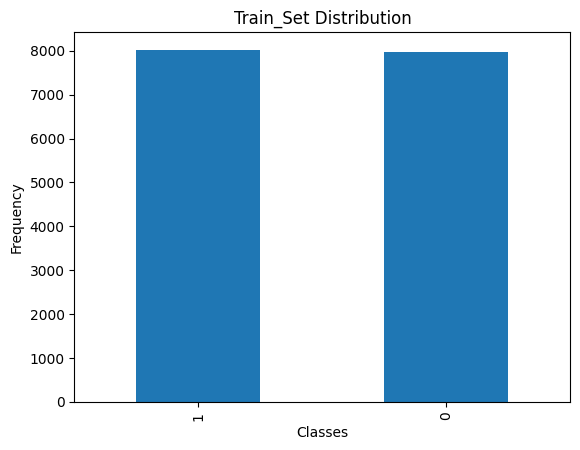

In [46]:
# Split the newly balanced dataset into 60% training
train_set_proportion = 0.6
train_set = balanced_df.sample(frac=train_set_proportion, random_state=42)

print(f"Train Set - Total Rows: {train_set.shape[0]}")
print(f"Train Set - Target Value Proportions:\n {train_set['target'].value_counts(normalize=True)}\n")
# 
balanced_df_remaining_after_train_set = balanced_df.drop(train_set.index)

print(f"Remaining Balanced Dataset - Total Rows: {balanced_df_remaining_after_train_set.shape[0]}")
print(f"Remaining Balanced Dataset - Target Value Proportions:\n {balanced_df_remaining_after_train_set['target'].value_counts(normalize=True)}\n")

# Double-check to ensure no overlap between train_set and test_set
assert not any(train_set.index.isin(balanced_df_remaining_after_train_set.index)), "There is overlap between train and test sets!"

print(train_set.info())
print(train_set.head(3))

print(balanced_df_remaining_after_train_set.info())

# Plotting the bar chart for target class distribution in the training set
train_set['target'].value_counts().plot(kind='bar')
plt.title('Train_Set Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

In [47]:
# Calculate the target proportion of fraudulent rows in the original dataset (0.149%)
realistic_fraudulent_ratio = master_df_all_fraud_rows.shape[0] / master_df_length
print(f"Realistic Fraudulent Ratio: {realistic_fraudulent_ratio}\n")

# Calculate the size of the test set (40% of the balanced dataset)
test_set_goal_total_size = int(len(balanced_df_remaining_after_train_set))
print(f"Test Set - Goal Total Size: {test_set_goal_total_size}\n")

# Calculate the number of fraudulent rows in the test set (0.149% of the test set size)
test_set_goal_fraudulent_rows = int(realistic_fraudulent_ratio * test_set_goal_total_size)
print(f"Test Set - Goal Fraudulent Rows: {test_set_goal_fraudulent_rows}\n")

# Calculate the number of fraudulent rows in the test set (rest will be non-fraudulent)
test_set_goal_non_fraudulent_rows = test_set_goal_total_size - test_set_goal_fraudulent_rows
print(f"Test Set - Goal Non-Fraudulent Rows: {test_set_goal_non_fraudulent_rows}\n")

# Sample the "test_set_goal_fraudulent_rows" from the "balanced_df_remaining_after_train_set" to create the fraud portion of the test set
test_set_fraudulent_rows_from_remaining_balanced_df = balanced_df_remaining_after_train_set[balanced_df_remaining_after_train_set['target'] == 1].sample(n=test_set_goal_fraudulent_rows, random_state=42)
print(f"Test Set - Final Size Fraudulent Rows: {test_set_fraudulent_rows_from_remaining_balanced_df.shape[0]}\n")

# Get the remaining non-fraudulent rows from the balanced dataset for the test set
balanced_df_remaining_non_fraud_rows = balanced_df_remaining_after_train_set[balanced_df_remaining_after_train_set['target'] == 0]
print(f"Balanced df - Remaining Non-Fraudulent Rows: {balanced_df_remaining_non_fraud_rows.shape[0]}\n")

# The remaining non-fraudulent rows in the balanced dataset will not be sufficient, calculate the left-over rows to fill
balanced_df_missing_non_fraud_rows = test_set_goal_non_fraudulent_rows - balanced_df_remaining_non_fraud_rows.shape[0]
print(f"Balanced df - Missing Non-Fraudulent Rows - to take from Master DF: {balanced_df_missing_non_fraud_rows}\n")

# Add all the remaining non-fraudulent rows from the "balanced_df_remaining_non_fraud_rows" to the test set, no sampling needed
test_set_remaining_non_fraud_from_balanced_df = balanced_df_remaining_non_fraud_rows
print(f"Test Set - Current Size (After Adding Remaining Non-Fraud Rows) {test_set_remaining_non_fraud_from_balanced_df.shape[0]}\n")

# Now take the remaining "balanced_df_missing_non_fraud_rows" from the "master_df" to fill the test set, but ensure, that the index is not duplicated a.k.a they are new and unseen non-fraud rows
test_set_missing_non_fraud_rows_from_master_df = master_df_remaining_non_fraud_rows.sample(n=balanced_df_missing_non_fraud_rows, random_state=42)

# Add the sampled non-fraudulent rows to the test set to create the final test set
test_set = pd.concat([test_set_fraudulent_rows_from_remaining_balanced_df, test_set_remaining_non_fraud_from_balanced_df, test_set_missing_non_fraud_rows_from_master_df])
print(f"Test Set - Final Size (After Adding Missing Non-Fraud Rows) {test_set.shape[0]}\n")

# Checking whether the training and test sets have duplicates
assert not any(train_set.index.isin(test_set.index)), "There is overlap between train and test sets!"

Realistic Fraudulent Ratio: 0.0014954633014180765

Test Set - Goal Total Size: 10666

Test Set - Goal Fraudulent Rows: 15

Test Set - Goal Non-Fraudulent Rows: 10651

Test Set - Final Size Fraudulent Rows: 15

Balanced df - Remaining Non-Fraudulent Rows: 5357

Balanced df - Missing Non-Fraudulent Rows - to take from Master DF: 5294

Test Set - Current Size (After Adding Remaining Non-Fraud Rows) 5357



Test Set - Final Size (After Adding Missing Non-Fraud Rows) 10666



In [48]:
# Generate Summary Output

print(f"Train Set - Total Rows: {train_set.shape[0]}")
print(f"Train Set - Target Value Proportions: {train_set['target'].value_counts(normalize=True)}")
print(f"Train Set - Target Value Count: {train_set['target'].value_counts()}")
print(f"Train Set - Duplicates in Index: {train_set.index.duplicated().sum()}\n")

print(f"Test Set - Total Rows: {test_set.shape[0]}")
print(f"Test Set - Target Value Proportions: {test_set['target'].value_counts(normalize=True)}")
print(f"Test Set - Target Value Count: {test_set['target'].value_counts()}")
print(f"Test Set - Duplicates in Index: {test_set.index.duplicated().sum()}\n")

print(f"Train & Test Set - Total Rows: {train_set.shape[0] + test_set.shape[0]}")
print(f"Train Set Proportion: {train_set.shape[0] / (train_set.shape[0] + test_set.shape[0]):.2%}")
print(f"Test Set Proportion: {test_set.shape[0] / (train_set.shape[0] + test_set.shape[0]):.2%}")

Train Set - Total Rows: 15998
Train Set - Target Value Proportions: target
1   0.5015
0   0.4985
Name: proportion, dtype: float64
Train Set - Target Value Count: target
1    8023
0    7975
Name: count, dtype: int64
Train Set - Duplicates in Index: 0

Test Set - Total Rows: 10666
Test Set - Target Value Proportions: target
0   0.9986
1   0.0014
Name: proportion, dtype: float64
Test Set - Target Value Count: target
0    10651
1       15
Name: count, dtype: int64
Test Set - Duplicates in Index: 0

Train & Test Set - Total Rows: 26664
Train Set Proportion: 60.00%
Test Set Proportion: 40.00%


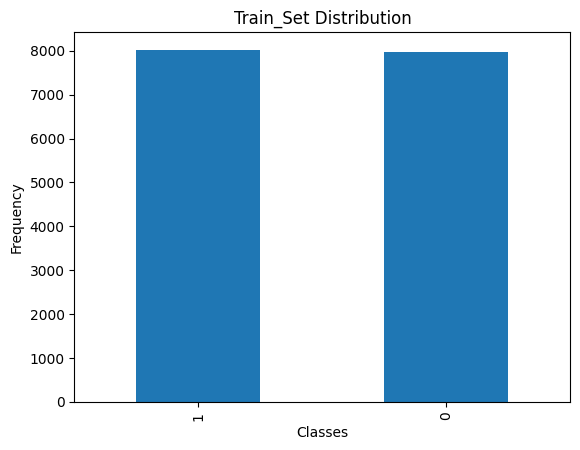

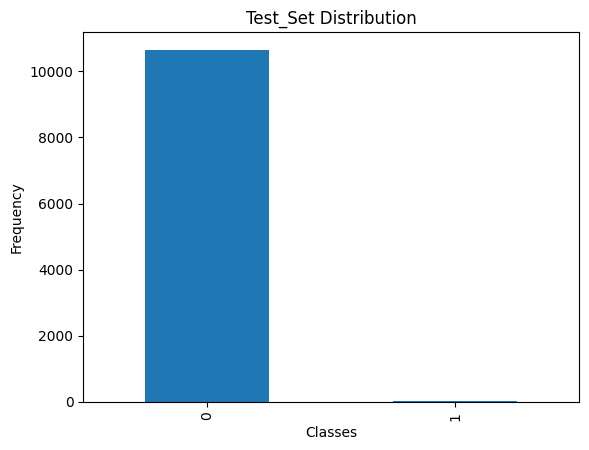

In [49]:
# Plot target class distributions in the final train and test sets
train_set['target'].value_counts().plot(kind='bar')
plt.title('Train_Set Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

test_set['target'].value_counts().plot(kind='bar')
plt.title('Test_Set Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

In [50]:
# Create backup copies of the training and testing sets
# This ensures the original stratified sets remain unchanged during preprocessing or experimentation
train_df_raw = train_set.copy()
test_df_raw = test_set.copy()

# Train Set - Exploratory Data Analysis (EDA)

In [51]:
# Get a refresh and feel for the training set
AdvancedEDA(train_df_raw).summary()

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 15998 entries, 5139232 to 6331602
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   transaction_id         15998 non-null  int64         
 1   date                   15998 non-null  datetime64[ns]
 2   amount                 15998 non-null  float64       
 3   use_chip               15998 non-null  object        
 4   merchant_id            15998 non-null  int64         
 5   merchant_city          15998 non-null  object        
 6   merchant_state         15998 non-null  object        
 7   zip                    15998 non-null  float64       
 8   errors                 15998 non-null  object        
 9   spending_category      15998 non-null  object        
 10  card_id                15998 non-null  int64         
 11  card_brand             15998 non-null  object        
 12  card_type              15998 non-null

transaction_id  amount  merchant_id        zip  card_id  \
5139232        16818340 30.9500        60600 46176.0000     1198   
3421030        13677235 11.6100        18563     0.0000     3673   
1176791         9594645 19.3600        20561 30101.0000     5797   

              card_number  cvv  num_cards_issued  credit_limit  \
5139232  4673279351880301  339                 2         12106   
3421030  5639527120868397  126                 1         25093   
1176791  4862436349200537   49                 2          2942   

         year_pin_last_changed  client_id  current_age  retirement_age  \
5139232                   2009        332           61              65   
3421030                   2006        386           48              64   
1176791                   2014       1559           56              67   

         birth_year  birth_month  latitude  longitude  per_capita_income  \
5139232        1958            7   39.5200   -85.7700              18324   
3421030        1971           11   42.2600   -71.8000              24506   
1176791        1963           12   34.0500   -84.6700              28862   

         yearly_income  total_debt  credit_score  num_credit_cards  target  
5139232          37362       21600           703                 4       0  
3421030          49967       62509           655                 1       0  
1176791          58846      126806           746                 3       0


>>> Numerical Columns Summary:


transaction_id     amount  merchant_id        zip    card_id  \
count      15998.0000 15998.0000   15998.0000 15998.0000 15998.0000   
mean    15651067.0000    76.4485   49786.8547 24805.0643  3445.3371   
std      4826147.7499   162.2315   26180.6131 32535.4337  1688.7023   
min      7479444.0000  -500.0000      33.0000     0.0000     0.0000   
25%     11397602.2500    11.3225   27092.0000     0.0000  2351.2500   
50%     16304029.0000    43.8300   49637.0000     0.0000  3571.0000   
75%     19464387.7500   100.0000   72421.5000 46048.5000  4876.7500   
max     23761072.0000  3416.6400  100188.0000 99504.0000  6134.0000   

                card_number        cvv  num_cards_issued  credit_limit  \
count            15998.0000 15998.0000        15998.0000    15998.0000   
mean  4800714747967574.0000   494.7215            1.5192    14696.1505   
std   1354386570835436.5000   289.3729            0.5176    11538.3186   
min    300609782832003.0000     0.0000            1.0000        0.0000   
25%   4489873116412364.0000   245.0000            1.0000     7500.0000   
50%   5117634817713280.0000   500.0000            2.0000    13016.0000   
75%   5573928816931767.0000   743.0000            2.0000    19913.0000   
max   6994217664929322.0000   999.0000            3.0000   141391.0000   

       year_pin_last_changed  client_id  current_age  retirement_age  \
count             15998.0000 15998.0000   15998.0000      15998.0000   
mean               2011.3472  1021.2215      54.9857         66.4942   
std                   2.9246   586.9852      15.6770          3.4960   
min                2002.0000     0.0000      23.0000         53.0000   
25%                2010.0000   509.0000      43.0000         65.0000   
50%                2011.0000  1058.0000      52.0000         66.0000   
75%                2013.0000  1531.0000      65.0000         68.0000   
max                2020.0000  1998.0000     101.0000         79.0000   

       birth_year  birth_month   latitude  longitude  per_capita_income  \
count  15998.0000   15998.0000 15998.0000 15998.0000         15998.0000   
mean    1964.1928       6.5913    37.2689   -91.7139         23507.5121   
std       15.6640       3.5797     5.1206    16.2698         11276.7099   
min     1918.0000       1.0000    21.3000  -158.1800             0.0000   
25%     1954.0000       3.0000    33.8400   -97.3300         16976.0000   
50%     1967.0000       7.0000    38.2100   -86.8000         20917.0000   
75%     1976.0000      10.0000    41.0300   -80.1600         26541.0000   
max     1996.0000      12.0000    48.5300   -68.6700        163145.0000   

       yearly_income  total_debt  credit_score  num_credit_cards     target  
count     15998.0000  15998.0000    15998.0000        15998.0000 15998.0000  
mean      45670.9197  55434.9583      714.6630            3.9698     0.5015  
std       23441.9810  50881.4469       65.0970            1.6056     0.5000  
min           1.0000      0.0000      488.0000            1.0000     0.0000  
25%       32126.0000  15336.0000      685.0000            3.0000     0.0000  
50%       40407.0000  49101.0000      716.0000            4.0000     1.0000  
75%       52908.0000  81825.0000      756.0000            5.0000     1.0000  
max      280199.0000 461854.0000      850.0000            9.0000     1.0000


-----

>>> Categorical Columns Summary:


use_chip merchant_city merchant_state     errors  \
count                15998         15998          15998      15998   
unique                   3          2097             74         10   
top     Online Transaction        ONLINE        Unknown  No Errors   
freq                  6189          6191           6191      15521   

        spending_category  card_brand card_type has_chip  gender  \
count               15998       15998     15998    15998   15998   
unique                108           4         3        2       2   
top     Department Stores  Mastercard     Debit      YES  Female   
freq                 1572        8532      9407    14488    8374   

                   address  
count                15998  
unique                1218  
top     836 Bayview Avenue  
freq                    48


>>> First 3 Rows of Categorical Columns:


use_chip merchant_city merchant_state     errors  \
5139232    Chip Transaction   Shelbyville             IN  No Errors   
3421030  Online Transaction        ONLINE        Unknown  No Errors   
1176791   Swipe Transaction       Acworth             GA  No Errors   

                  spending_category  card_brand card_type has_chip  gender  \
5139232   Miscellaneous Food Stores        Visa     Debit      YES    Male   
3421030     Taxicabs and Limousines  Mastercard     Debit      YES    Male   
1176791  Drug Stores and Pharmacies        Visa     Debit      YES  Female   

                      address  
5139232   8794 Catherine Lane  
3421030  3034 Third Boulevard  
1176791  607 George Boulevard


-----

>>> First 3 Rows of Entire DataFrame:


transaction_id                date  amount            use_chip  \
5139232        16818340 2015-10-17 12:21:00 30.9500    Chip Transaction   
3421030        13677235 2013-12-05 10:58:00 11.6100  Online Transaction   
1176791         9594645 2011-05-28 16:00:00 19.3600   Swipe Transaction   

         merchant_id merchant_city merchant_state        zip     errors  \
5139232        60600   Shelbyville             IN 46176.0000  No Errors   
3421030        18563        ONLINE        Unknown     0.0000  No Errors   
1176791        20561       Acworth             GA 30101.0000  No Errors   

                  spending_category  card_id  card_brand card_type  \
5139232   Miscellaneous Food Stores     1198        Visa     Debit   
3421030     Taxicabs and Limousines     3673  Mastercard     Debit   
1176791  Drug Stores and Pharmacies     5797        Visa     Debit   

              card_number    expires  cvv has_chip  num_cards_issued  \
5139232  4673279351880301 2023-07-01  339      YES                 2   
3421030  5639527120868397 2023-10-01  126      YES                 1   
1176791  4862436349200537 2023-08-01   49      YES                 2   

         credit_limit acct_open_date  year_pin_last_changed  client_id  \
5139232         12106     2009-02-01                   2009        332   
3421030         25093     2002-07-01                   2006        386   
1176791          2942     2003-12-01                   2014       1559   

         current_age  retirement_age  birth_year  birth_month  gender  \
5139232           61              65        1958            7    Male   
3421030           48              64        1971           11    Male   
1176791           56              67        1963           12  Female   

                      address  latitude  longitude  per_capita_income  \
5139232   8794 Catherine Lane   39.5200   -85.7700              18324   
3421030  3034 Third Boulevard   42.2600   -71.8000              24506   
1176791  607 George Boulevard   34.0500   -84.6700              28862   

         yearly_income  total_debt  credit_score  num_credit_cards  target  
5139232          37362       21600           703                 4       0  
3421030          49967       62509           655                 1       0  
1176791          58846      126806           746                 3       0

In [52]:
# Extract the interesting features to look at

# Columns to exclude from visualizations (ID Columns, Sensitive Columns, Longitude Latitude)
id_columns = [
    "transaction_id", "date", "merchant_id", "card_id",
    "card_number", "client_id"
]

sensitive_columns = ["cvv"]

logntitude_latitude = ["longitude", "latitude"]

target_column = ["target"]


columns_to_exclude = id_columns + sensitive_columns + logntitude_latitude + target_column

# Total column count
total_column_count = train_df_raw.shape[1]

# Helper function to filter and print lists vertically
def filter_and_print(name, columns):
    filtered = [col for col in columns if col not in columns_to_exclude]
    print(f"\n{name} ({len(filtered)}):")
    for col in filtered:
        print(f" - {col}")
    return filtered

# Categorize by dtype
target_column = ["target"]
categorical_columns = train_df_raw.select_dtypes(include='object').columns.tolist()
numeric_columns = train_df_raw.select_dtypes(include=['int', 'float']).columns.tolist() 
datetime_columns = train_df_raw.select_dtypes(include='datetime').columns.tolist()
bool_columns = train_df_raw.select_dtypes(include='bool').columns.tolist()


# Detect unclassified columns
all_detected = set(categorical_columns + numeric_columns + datetime_columns + bool_columns)
other_columns = [col for col in train_df_raw.columns if col not in all_detected]

# Filtered versions for EDA (excluding unhelpful columns)
categorical_eda_columns = filter_and_print("Categorical Columns (EDA)", categorical_columns + target_column)
numerical_eda_columns = filter_and_print("Numeric Columns (EDA)", numeric_columns + target_column)

# Final EDA column list (categorical + numeric only, both filtered)
all_eda_columns = categorical_eda_columns + numerical_eda_columns 

# Print final summary
print(f"\nAll EDA Columns ({len(all_eda_columns)}):")
for col in all_eda_columns:
    print(f" - {col}")

# Column coverage check
covered_columns_count = len(set(
    categorical_columns + numeric_columns + datetime_columns + bool_columns + other_columns
))
print(f"\nTotal Columns in DataFrame: {total_column_count}")
print(f"Total Columns Covered by Categories: {covered_columns_count}")
print(f"Coverage (%): {covered_columns_count / total_column_count * 100:.2f}%")


Categorical Columns (EDA) (10):
 - use_chip
 - merchant_city
 - merchant_state
 - errors
 - spending_category
 - card_brand
 - card_type
 - has_chip
 - gender
 - address

Numeric Columns (EDA) (14):
 - amount
 - zip
 - num_cards_issued
 - credit_limit
 - year_pin_last_changed
 - current_age
 - retirement_age
 - birth_year
 - birth_month
 - per_capita_income
 - yearly_income
 - total_debt
 - credit_score
 - num_credit_cards

All EDA Columns (24):
 - use_chip
 - merchant_city
 - merchant_state
 - errors
 - spending_category
 - card_brand
 - card_type
 - has_chip
 - gender
 - address
 - amount
 - zip
 - num_cards_issued
 - credit_limit
 - year_pin_last_changed
 - current_age
 - retirement_age
 - birth_year
 - birth_month
 - per_capita_income
 - yearly_income
 - total_debt
 - credit_score
 - num_credit_cards

Total Columns in DataFrame: 36
Total Columns Covered by Categories: 36
Coverage (%): 100.00%


In [53]:
# Invoke the custom class as a variable, to make it easier to call the prepared functions. 
train_df_eda = AdvancedEDA(train_df_raw)

## EDA - Categorical Distributions

In [54]:
# Check the cardinality of the categorical features with a preview of their unique values
train_df_eda.categorical_cardinality()

Cardinality of categorical features:
use_chip                3
merchant_city        2097
merchant_state         74
errors                 10
spending_category     108
card_brand              4
card_type               3
has_chip                2
gender                  2
address              1218
dtype: int64

use_chip: 3 unique values
Unique values: Chip Transaction, Online Transaction, Swipe Transaction
Sample (3 values): ['Chip Transaction', 'Swipe Transaction', 'Swipe Transaction']

merchant_city: 2097 unique values
Too many categories to print.
Sample (3 values): ['Buffalo', 'Gunter', 'Port au Prince']

merchant_state: 74 unique values
Too many categories to print.
Sample (3 values): ['NY', 'TX', 'Haiti']

errors: 10 unique values
Unique values: No Errors, Technical Glitch, Insufficient Balance, Bad CVV, Bad Card Number, Bad PIN, Bad Expiration, Bad PIN,Insufficient Balance, Bad CVV,Technical Glitch, Bad CVV,Insufficient Balance
Sample (3 values): ['No Errors', 'No Errors', 'No Err

In [55]:
# Splitting all categorical columns into two lists based on cardinality, for easier batch visualization
visualize_low_cardinality_columns = ["use_chip", "card_brand", "card_type", "has_chip", "gender", "target"]
visualize_high_cardinality_columns = ["merchant_city", "errors", "merchant_state", "spending_category", "address"]

### Low Cardinality Categorical Columns

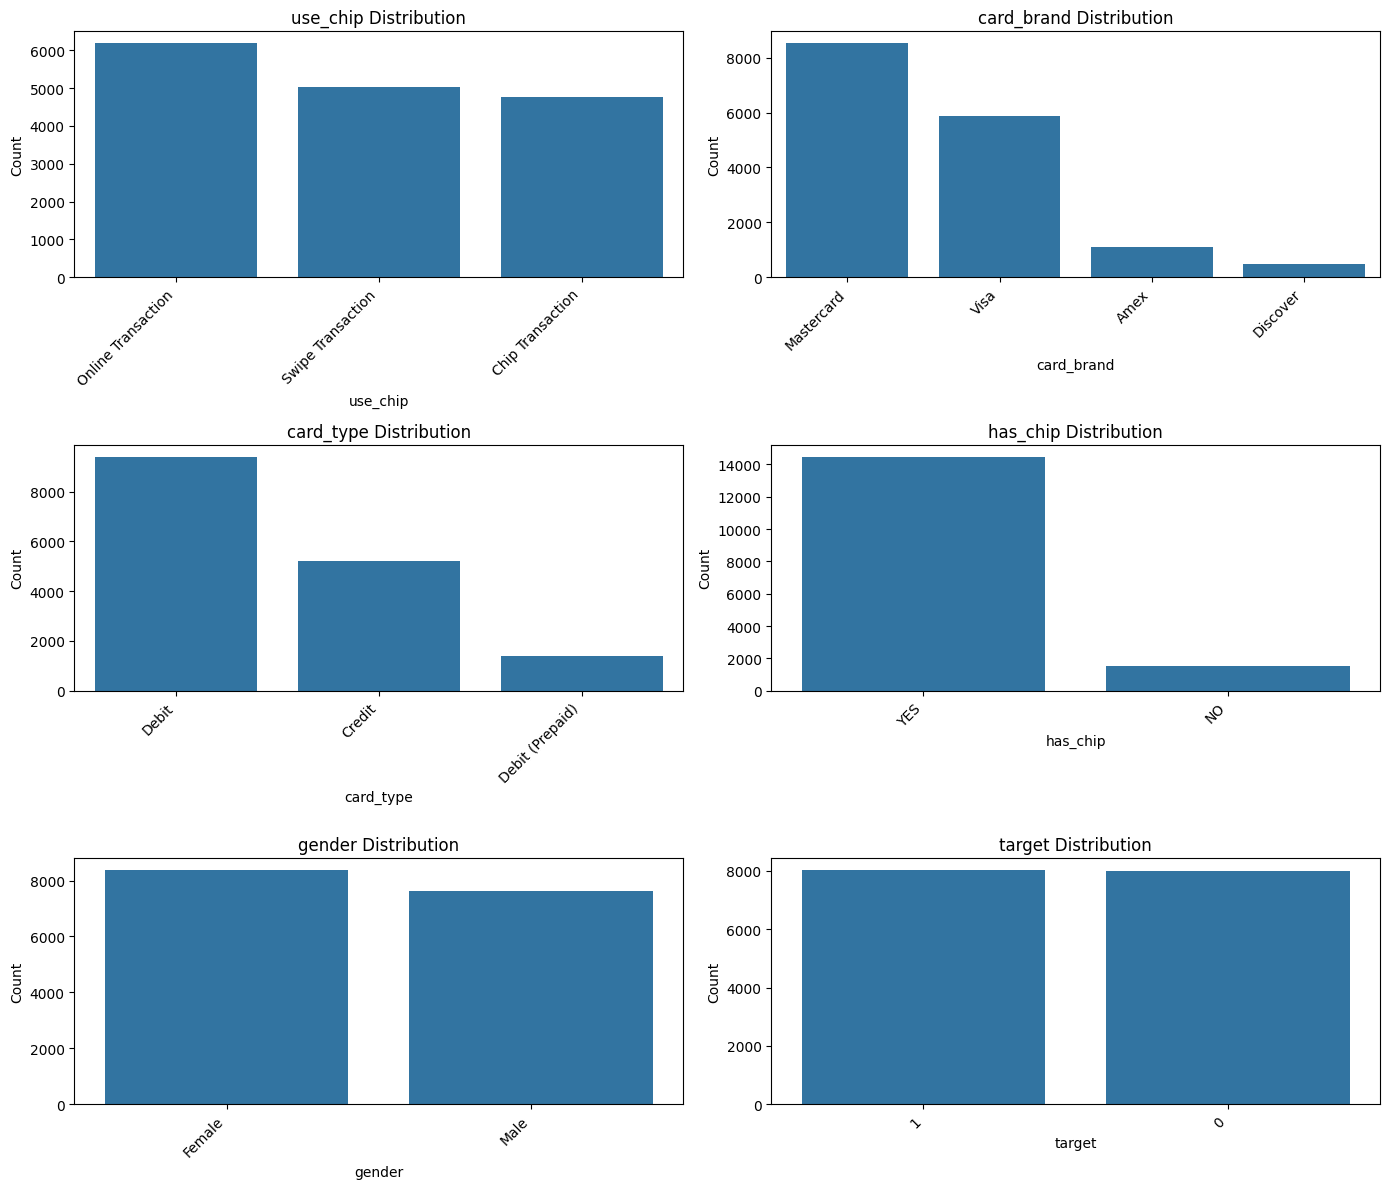

In [56]:
# Visualize the low cardinality categorical columns, no need for top_n
train_df_eda.plot_categorical_distribution(visualize_low_cardinality_columns, top_n=None, target_column=None, target_value=None)     

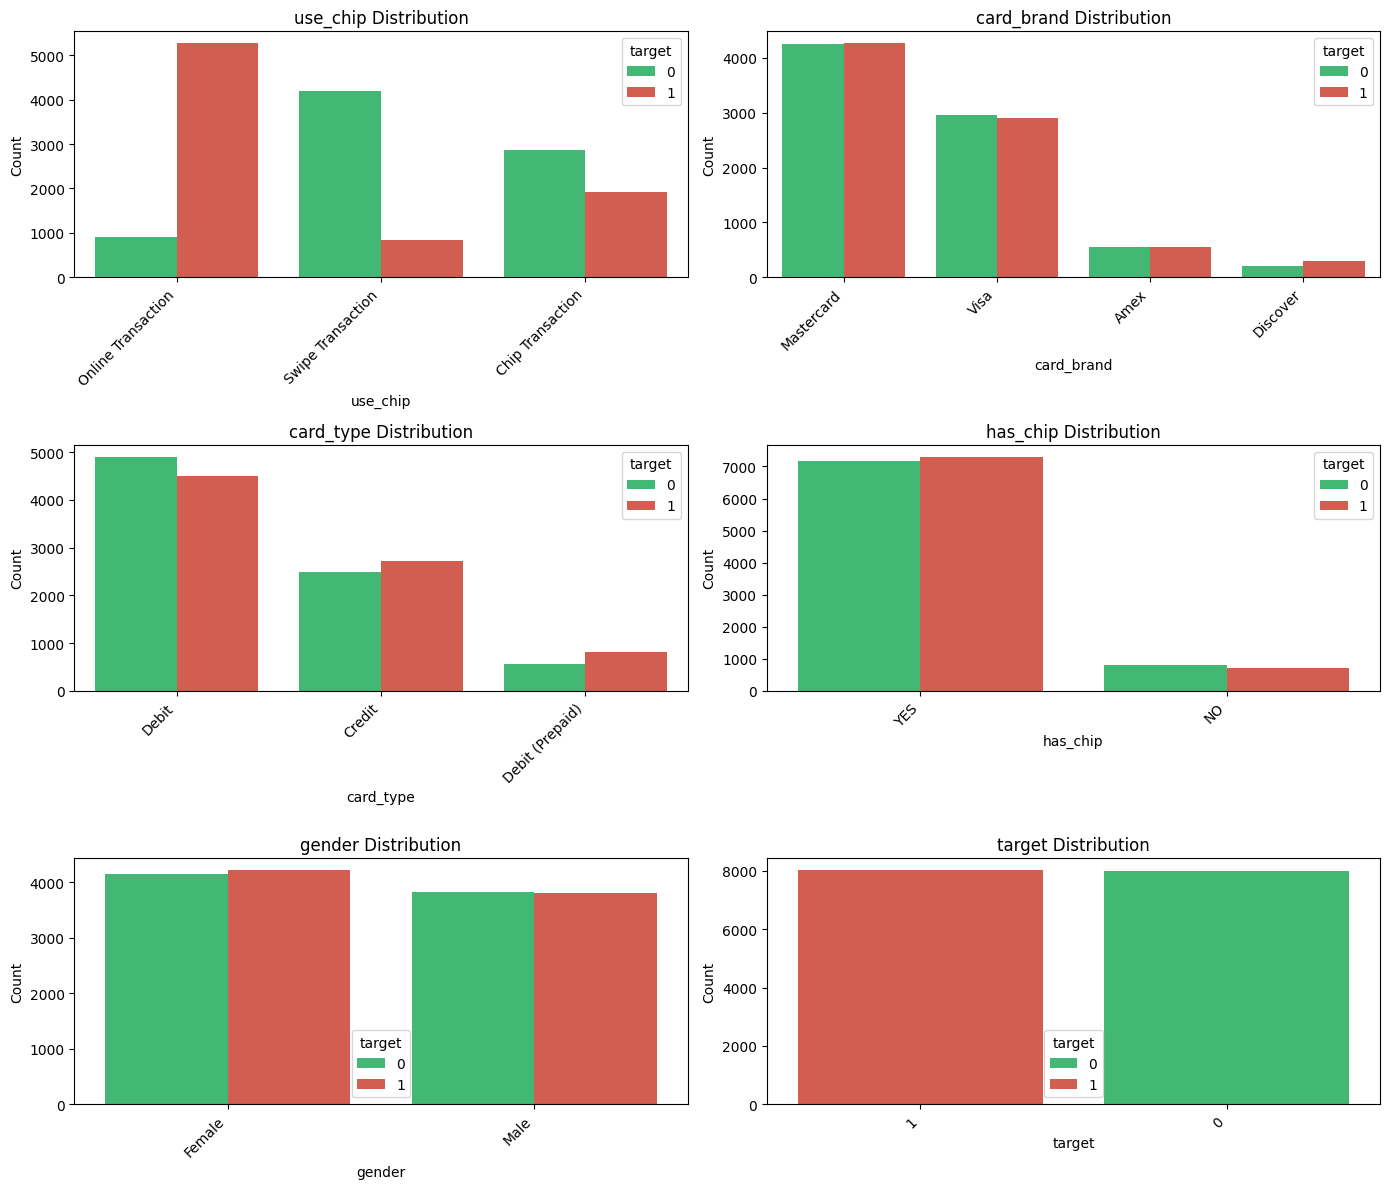

In [57]:
# Visualize the low cardinality categorical columns, group by target
train_df_eda.plot_categorical_distribution(visualize_low_cardinality_columns, top_n=None, target_column="target", target_value=None)    

### High Cardinality Categorical Columns

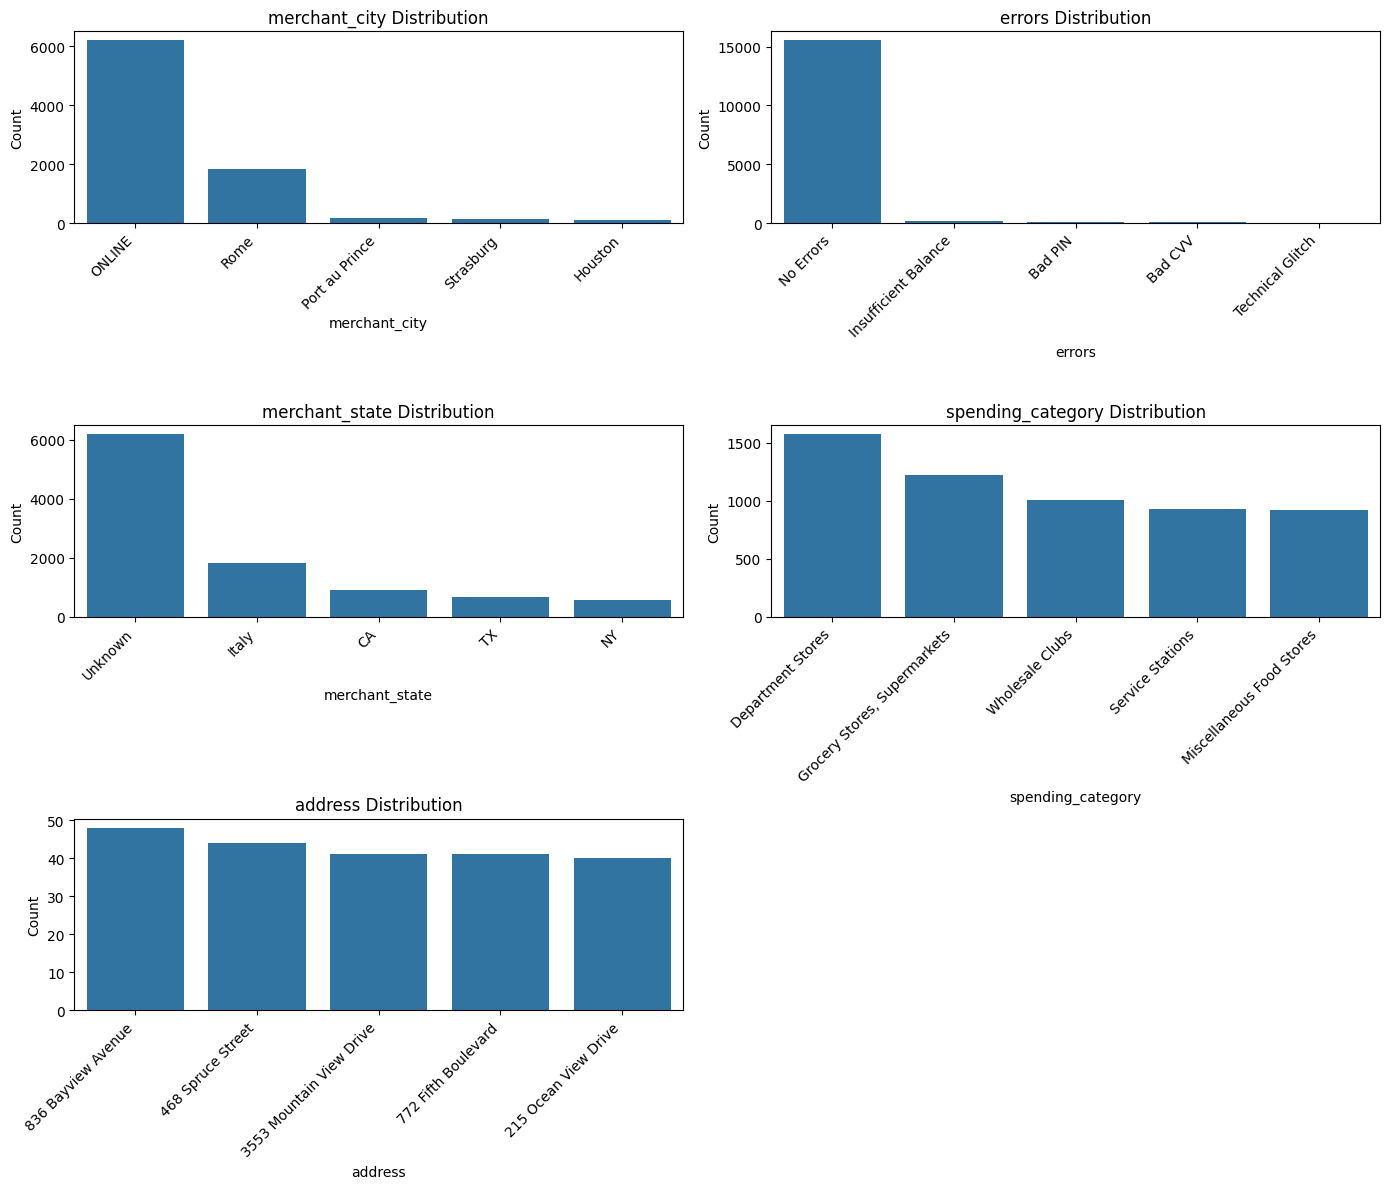

In [58]:
# Visualize the high cardinality categorical columns, top_n=5 necessary to avoid overcrowding of plots
train_df_eda.plot_categorical_distribution(columns=visualize_high_cardinality_columns, top_n=5)

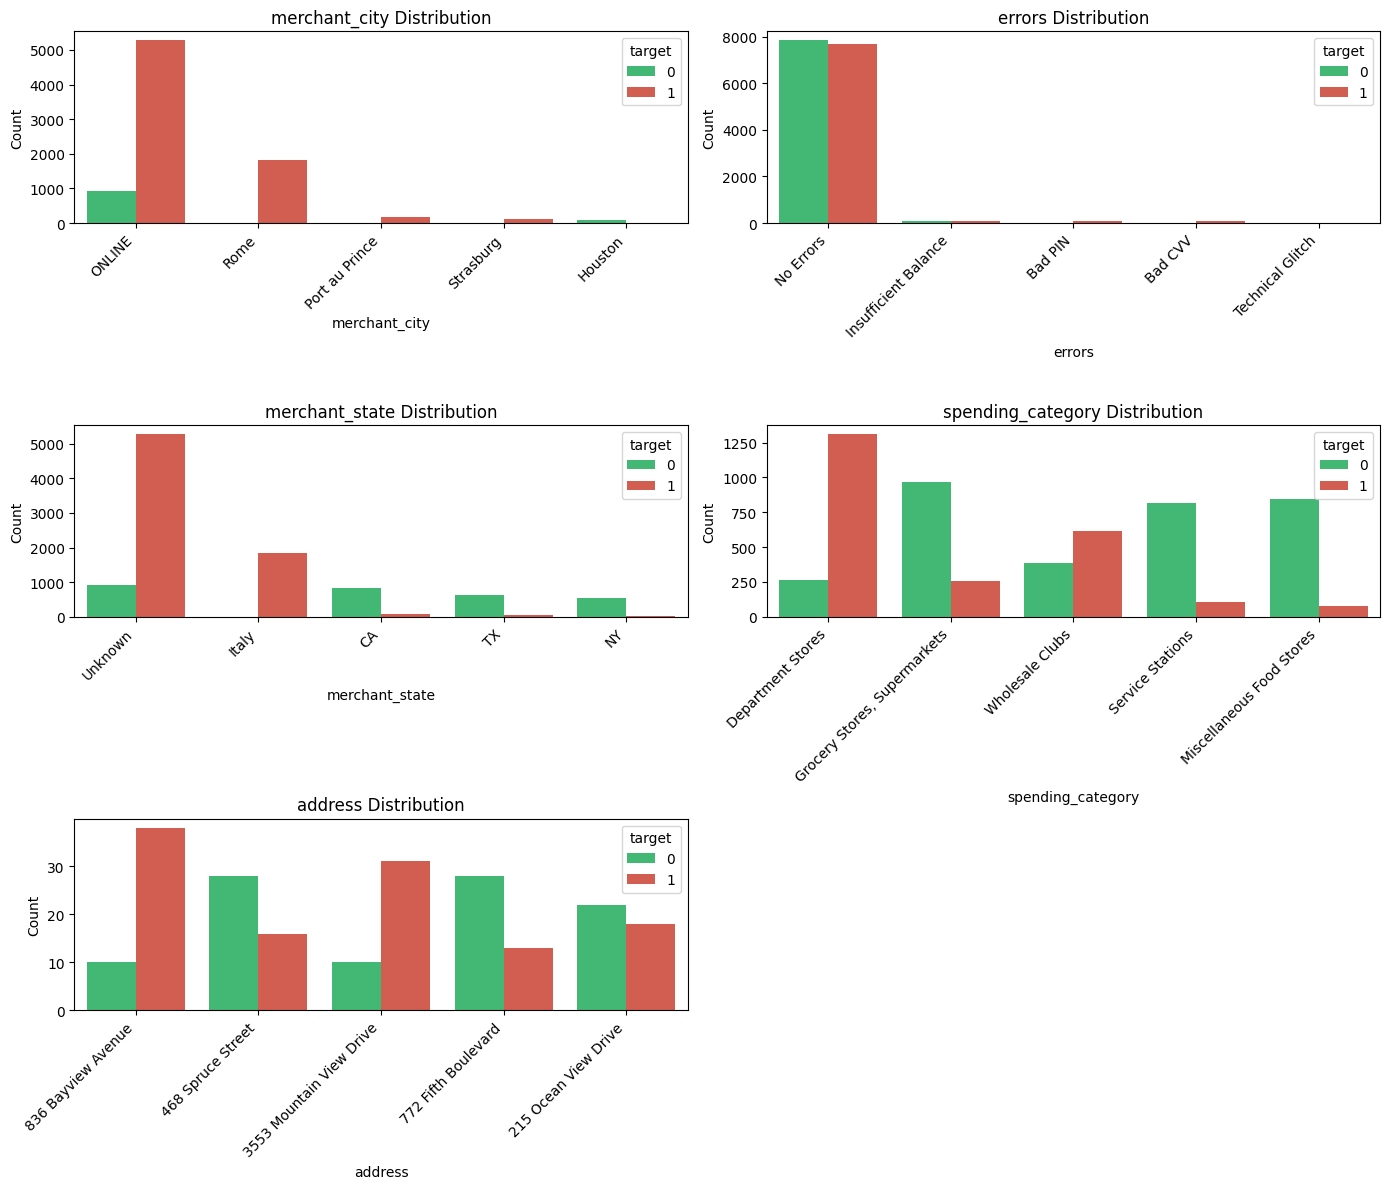

In [59]:
# Visualize the high cardinality categorical columns, group by target for better insights
train_df_eda.plot_categorical_distribution(columns=visualize_high_cardinality_columns, top_n=5, target_column="target")

## EDA - Numeric Distributions

### Histograms

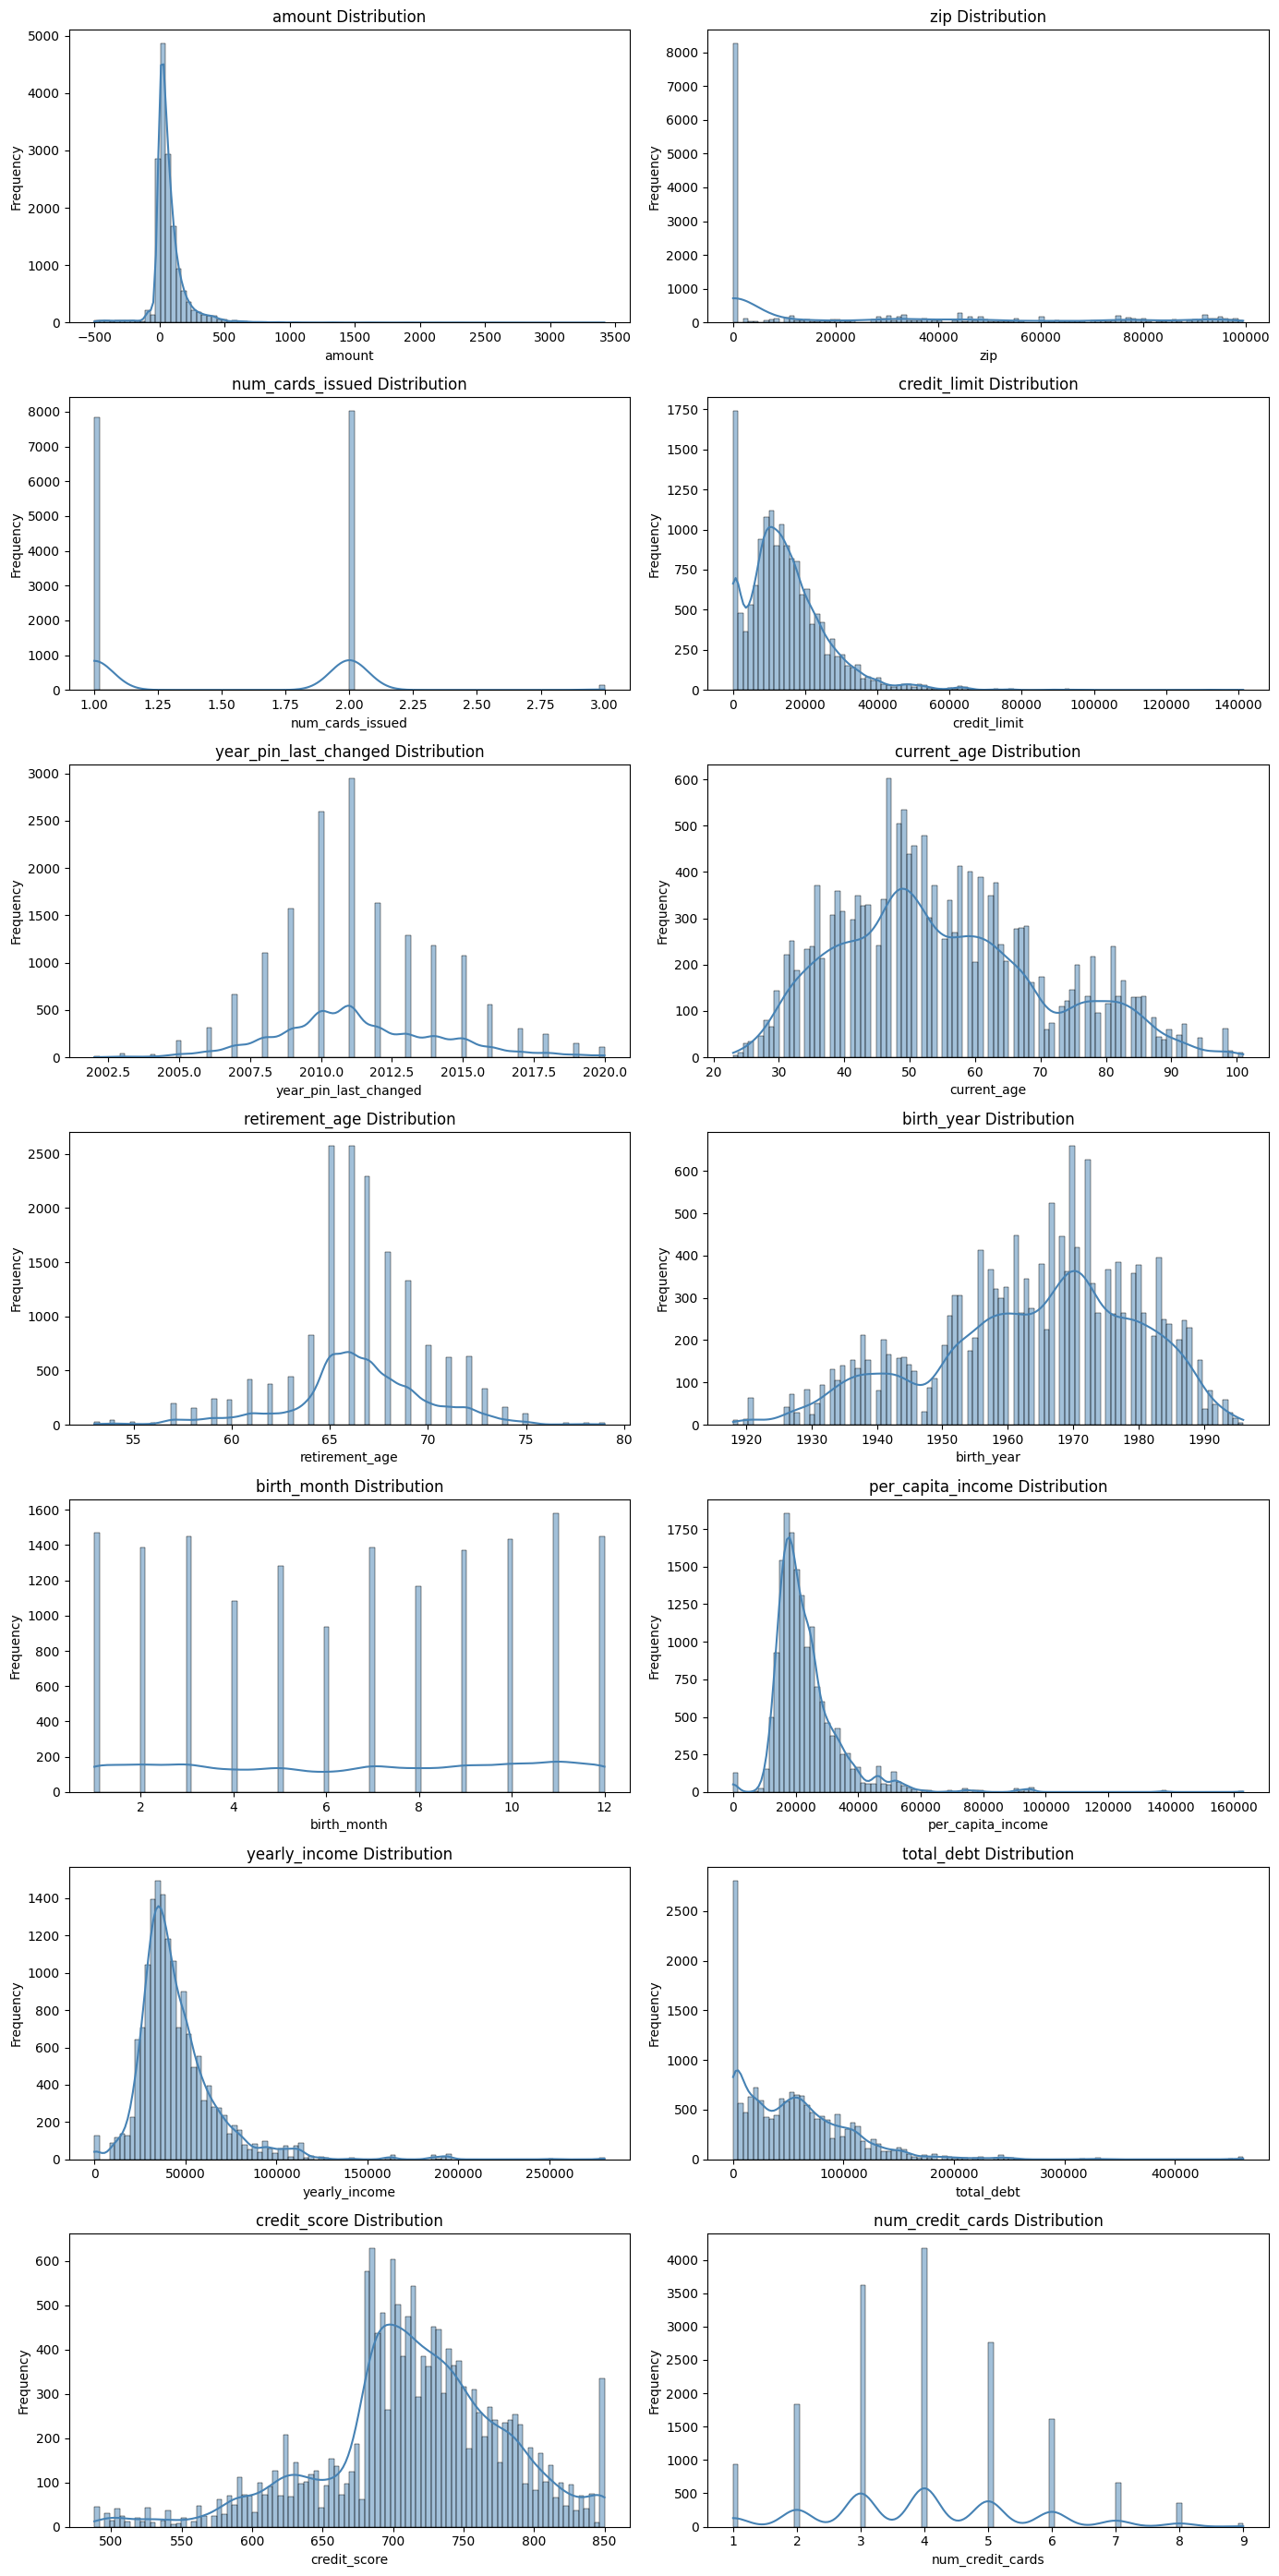

In [60]:
# Inspect the general distribution, untargeted

train_df_eda.plot_histograms(
    columns=numerical_eda_columns,
    bins=100
)

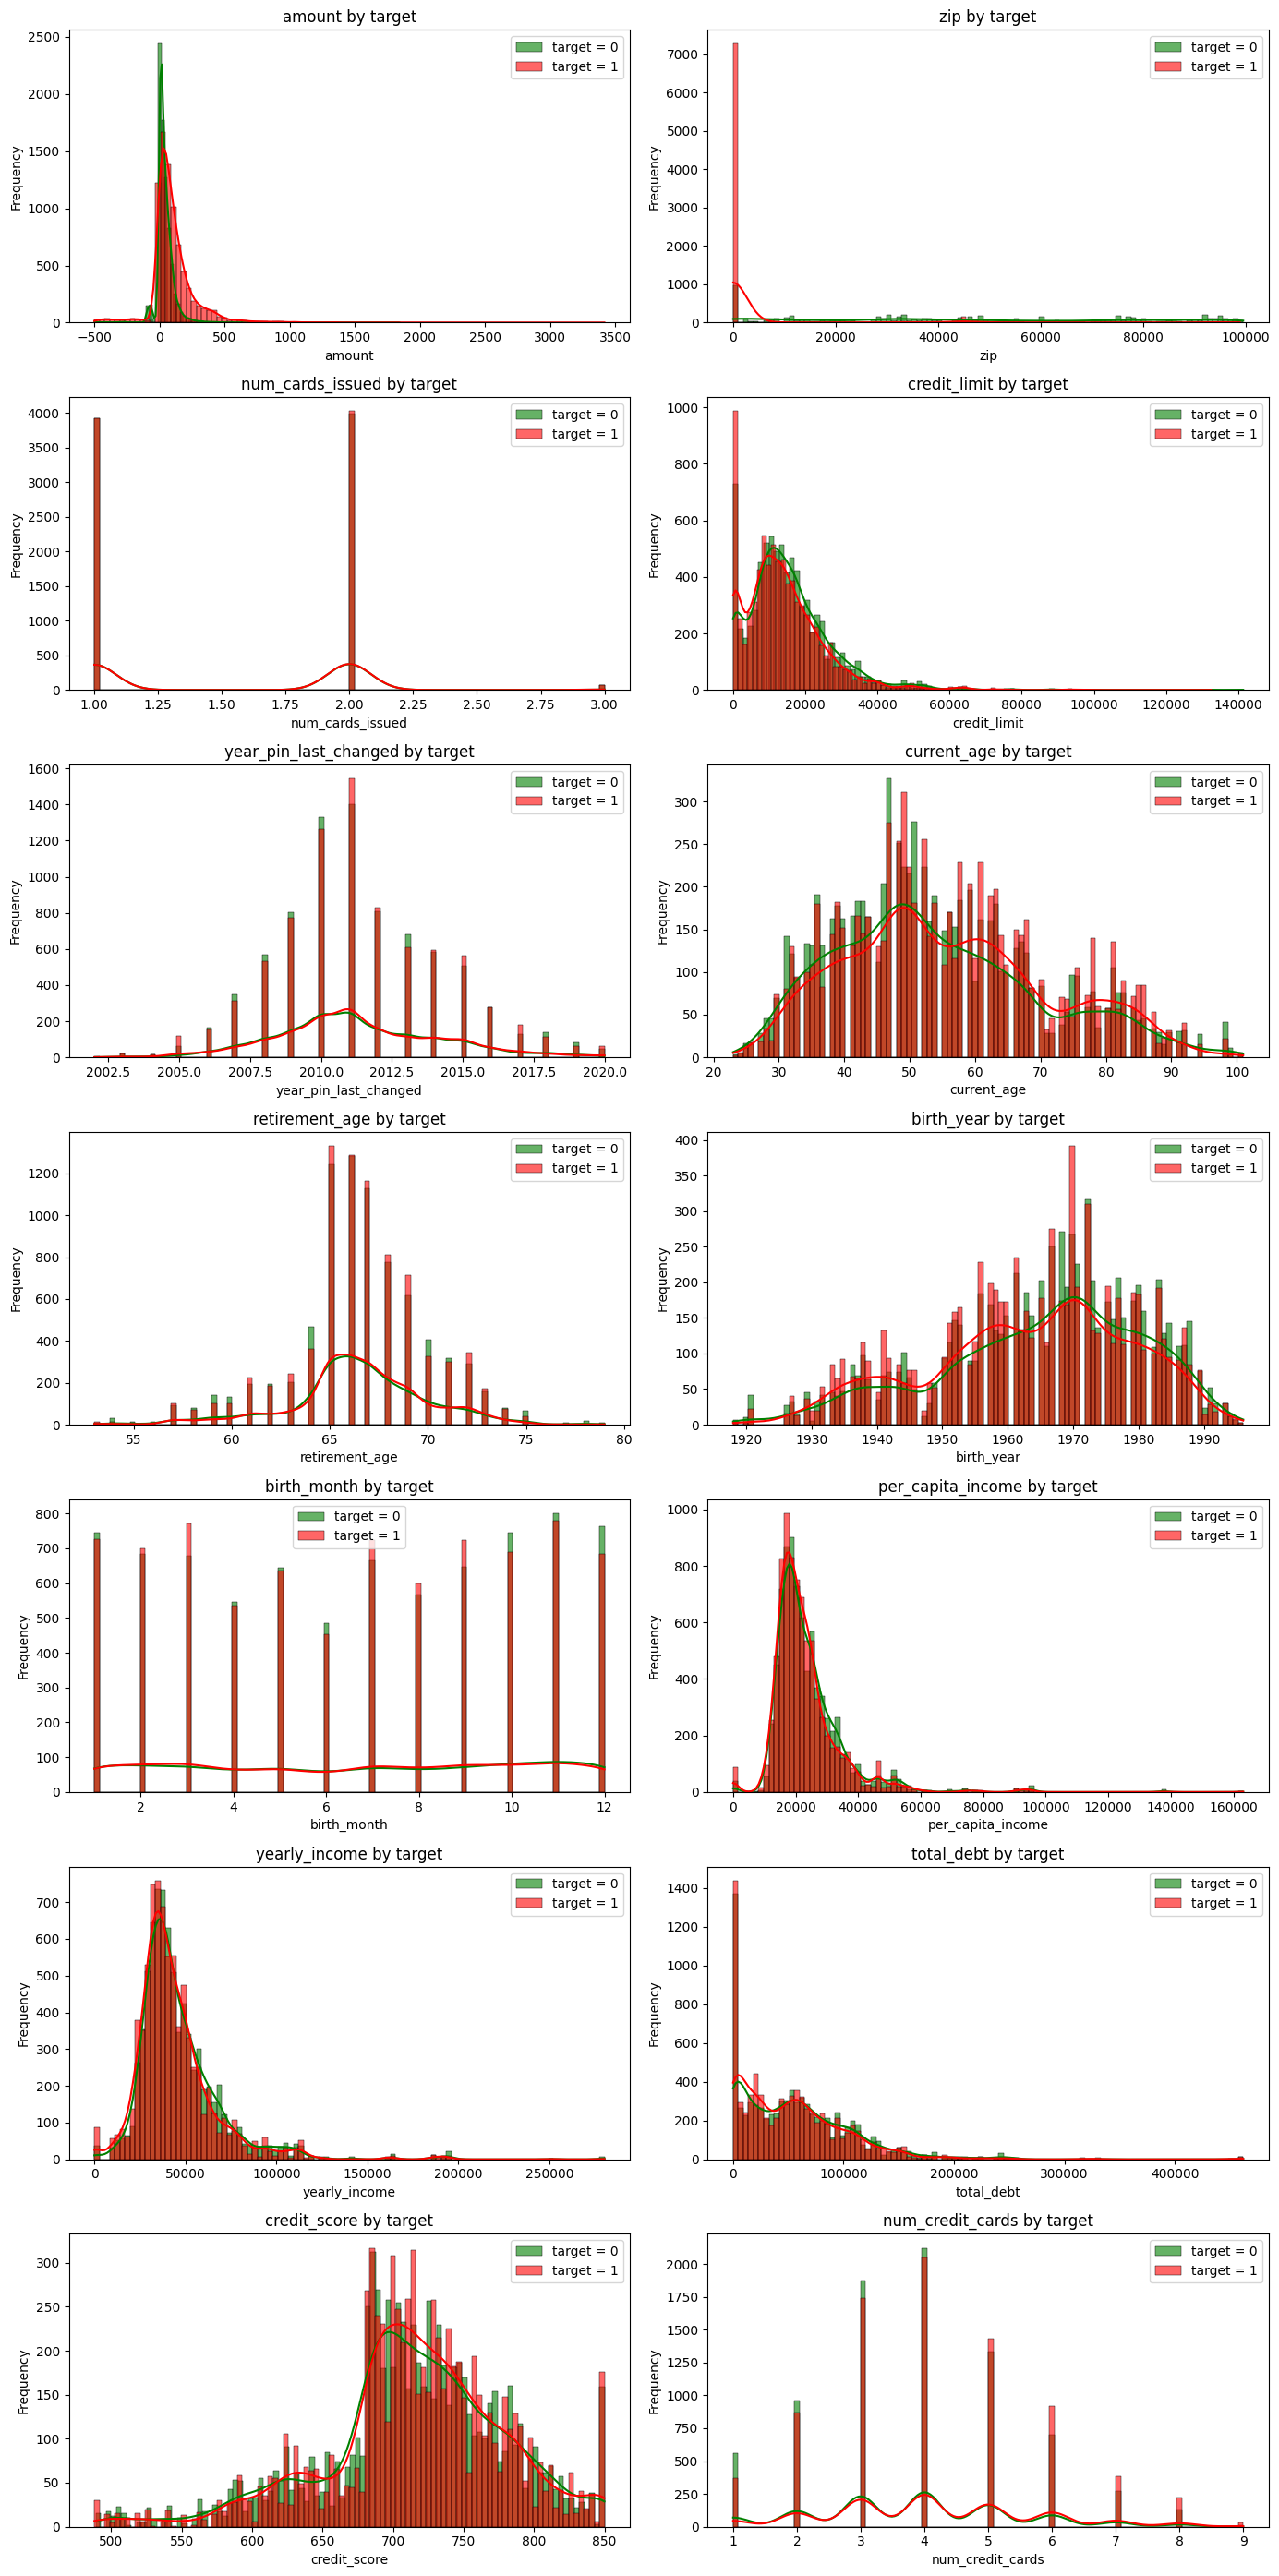

In [61]:
# Inspect the distribution, visually distinguished between target

train_df_eda.plot_histograms(
    columns=numerical_eda_columns,
    bins=100,
    target_column="target"
)

In [62]:
# Analyze the numerical columns for skewness classify them into bins
skewness_results = train_df_eda.check_skewness(columns_to_check=numerical_eda_columns)


>>> Decision Boundaries for Skewness:
1. Highly Skewed: Skewness outside the range of [-1, 1]
2. Moderately Skewed: Skewness in [-1, -0.5] or [0.5, 1]
3. Mildly Skewed: Skewness within [-0.5, 0.5]


>>> Highly Skewed (in descending order):
Column: [amount] | Skewness: [5.75] | Label: [Highly Skewed]
Column: [per_capita_income] | Skewness: [3.39] | Label: [Highly Skewed]
Column: [yearly_income] | Skewness: [2.89] | Label: [Highly Skewed]
Column: [credit_limit] | Skewness: [2.00] | Label: [Highly Skewed]
Column: [total_debt] | Skewness: [1.86] | Label: [Highly Skewed]

>>> Moderately Skewed (in descending order):
Column: [zip] | Skewness: [0.99] | Label: [Moderately Skewed]
Column: [credit_score] | Skewness: [-0.54] | Label: [Moderately Skewed]

>>> Mildly Skewed (in descending order):
Column: [current_age] | Skewness: [0.47] | Label: [Mildly Skewed]
Column: [year_pin_last_changed] | Skewness: [0.35] | Label: [Mildly Skewed]
Column: [num_credit_cards] | Skewness: [0.33] | Label: [Mildly

### Scatter Plots

<Figure size 1800x1000 with 0 Axes>

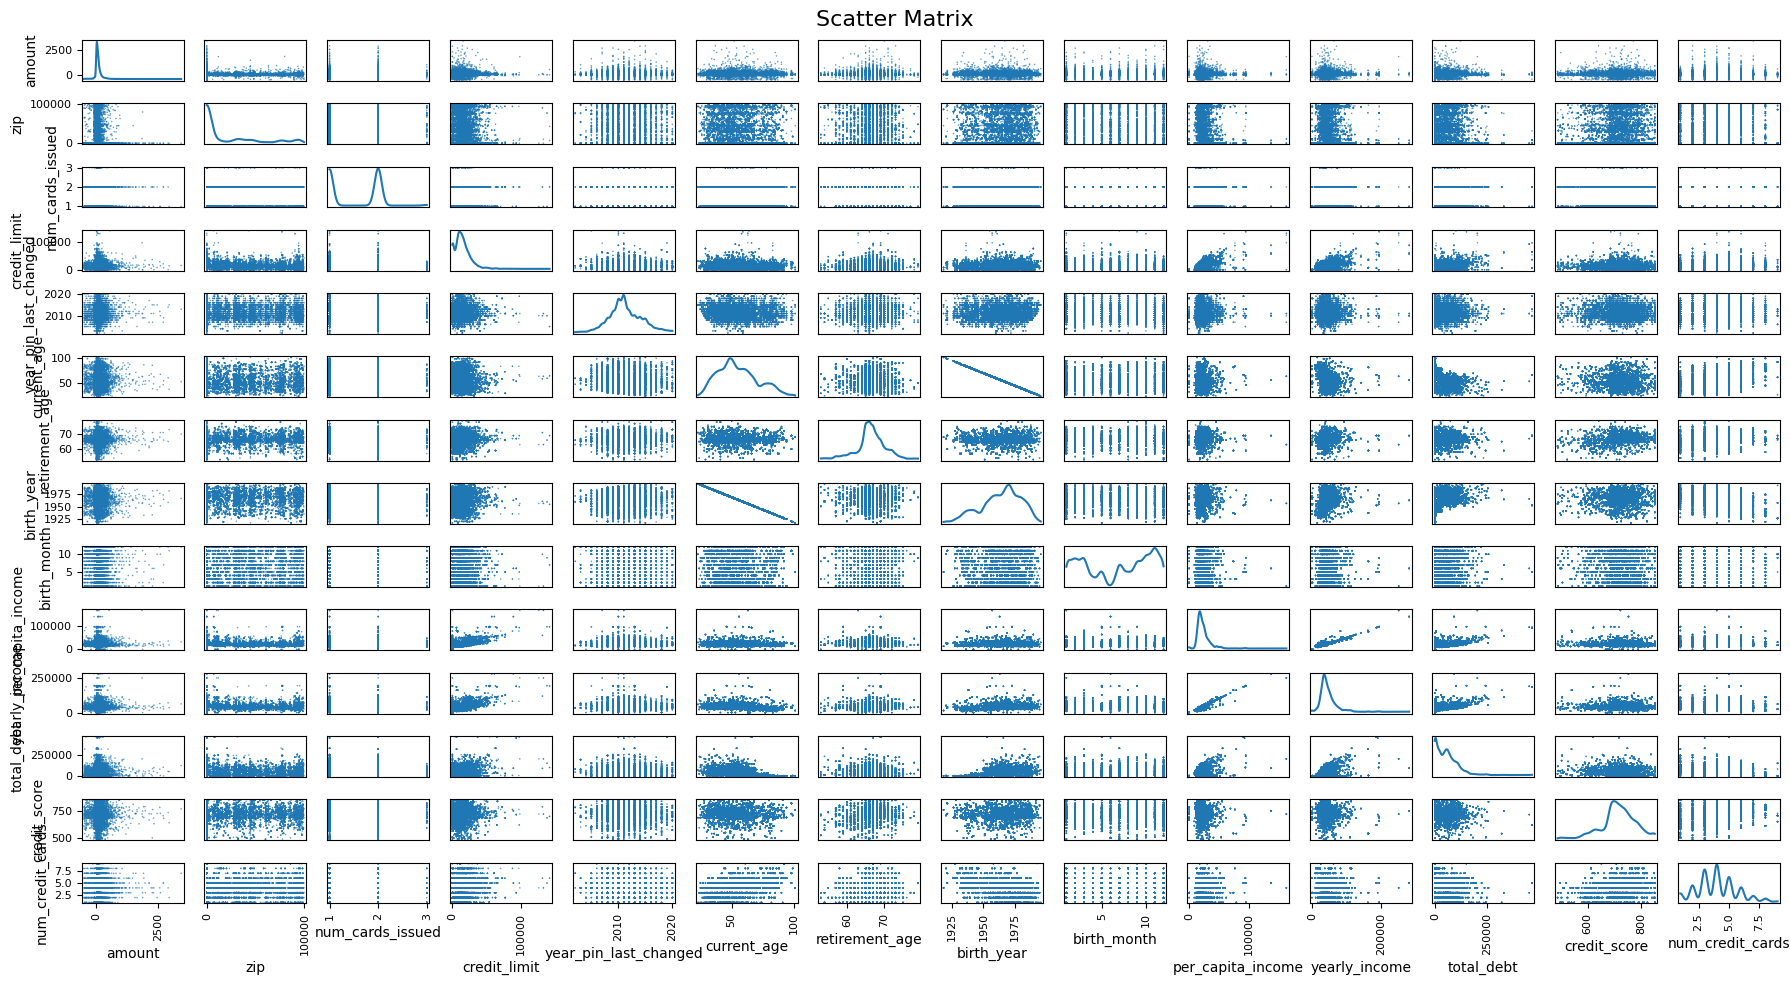

In [63]:
# Scatter Plotting all numerical columns
train_df_eda.plot_scatter_matrix(numerical_eda_columns, diagonal='kde', alpha=0.7, s=5)

### Correlation Heatmap

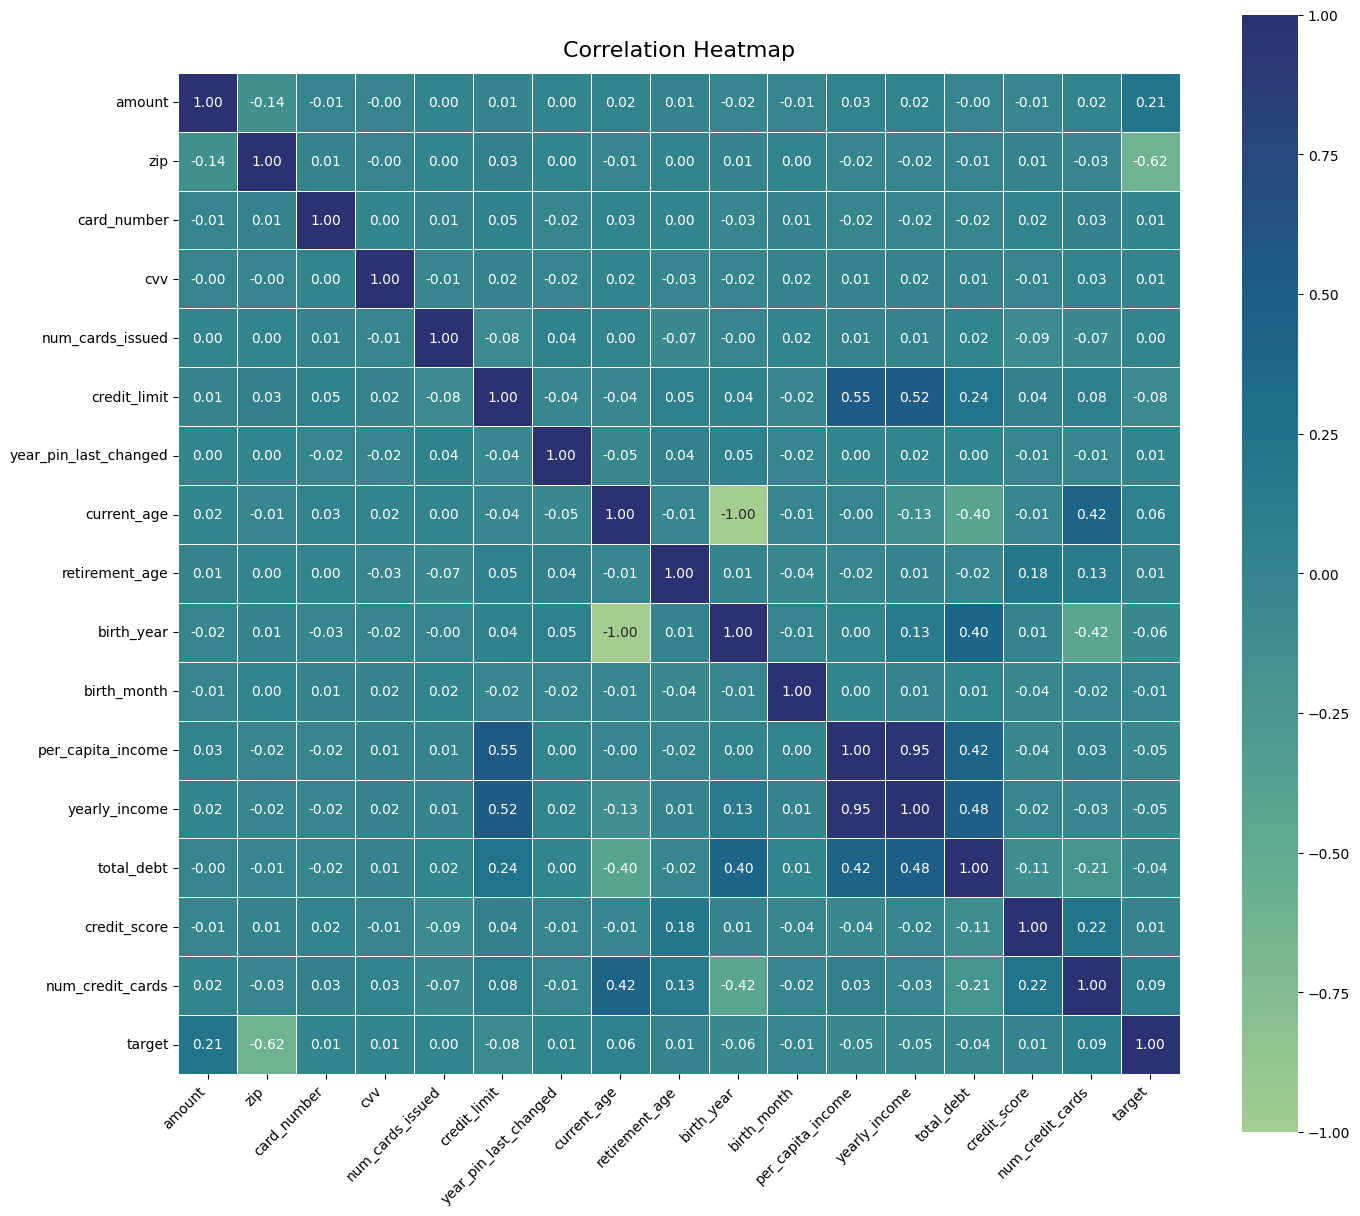

amount     zip  card_number     cvv  num_cards_issued  \
amount                 1.0000 -0.1420      -0.0052 -0.0038            0.0005   
zip                   -0.1420  1.0000       0.0148 -0.0013            0.0027   
card_number           -0.0052  0.0148       1.0000  0.0007            0.0147   
cvv                   -0.0038 -0.0013       0.0007  1.0000           -0.0083   
num_cards_issued       0.0005  0.0027       0.0147 -0.0083            1.0000   
credit_limit           0.0099  0.0326       0.0454  0.0152           -0.0756   
year_pin_last_changed  0.0037  0.0012      -0.0242 -0.0201            0.0393   
current_age            0.0162 -0.0125       0.0288  0.0224            0.0037   
retirement_age         0.0086  0.0013       0.0009 -0.0280           -0.0656   
birth_year            -0.0159  0.0130      -0.0287 -0.0232           -0.0040   
birth_month           -0.0075  0.0036       0.0108  0.0154            0.0172   
per_capita_income      0.0302 -0.0155      -0.0157  0.0127            0.0148   
yearly_income          0.0233 -0.0192      -0.0186  0.0155            0.0135   
total_debt            -0.0043 -0.0055      -0.0243  0.0121            0.0203   
credit_score          -0.0088  0.0095       0.0241 -0.0070           -0.0926   
num_credit_cards       0.0211 -0.0267       0.0345  0.0251           -0.0692   
target                 0.2112 -0.6195       0.0069  0.0076            0.0035   

                       credit_limit  year_pin_last_changed  current_age  \
amount                       0.0099                 0.0037       0.0162   
zip                          0.0326                 0.0012      -0.0125   
card_number                  0.0454                -0.0242       0.0288   
cvv                          0.0152                -0.0201       0.0224   
num_cards_issued            -0.0756                 0.0393       0.0037   
credit_limit                 1.0000                -0.0411      -0.0440   
year_pin_last_changed       -0.0411                 1.0000      -0.0524   
current_age                 -0.0440                -0.0524       1.0000   
retirement_age               0.0510                 0.0389      -0.0146   
birth_year                   0.0440                 0.0526      -0.9997   
birth_month                 -0.0162                -0.0239      -0.0109   
per_capita_income            0.5483                 0.0047      -0.0021   
yearly_income                0.5161                 0.0159      -0.1334   
total_debt                   0.2391                 0.0037      -0.4008   
credit_score                 0.0389                -0.0101      -0.0104   
num_credit_cards             0.0826                -0.0131       0.4240   
target                      -0.0753                 0.0059       0.0572   

                       retirement_age  birth_year  birth_month  \
amount                         0.0086     -0.0159      -0.0075   
zip                            0.0013      0.0130       0.0036   
card_number                    0.0009     -0.0287       0.0108   
cvv                           -0.0280     -0.0232       0.0154   
num_cards_issued              -0.0656     -0.0040       0.0172   
credit_limit                   0.0510      0.0440      -0.0162   
year_pin_last_changed          0.0389      0.0526      -0.0239   
current_age                   -0.0146     -0.9997      -0.0109   
retirement_age                 1.0000      0.0146      -0.0350   
birth_year                     0.0146      1.0000      -0.0053   
birth_month                   -0.0350     -0.0053       1.0000   
per_capita_income             -0.0199      0.0014       0.0044   
yearly_income                  0.0142      0.1322       0.0113   
total_debt                    -0.0160      0.4006       0.0055   
credit_score                   0.1764      0.0112      -0.0354   
num_credit_cards               0.1290     -0.4237      -0.0179   
target                         0.0107     -0.0573      -0.0122   

                       per_capita_income  

In [64]:
# Correlation Heatmpa, excluding id columns
AdvancedEDA(train_df_raw).plot_correlation_heatmap(id_columns=["transaction_id", "merchant_id", "card_id", "client_id", "latitude", "longitude"])

# Prepare for Model Training - Feature Engineering & Transformations

## Train Set - Transformations

In [65]:
# Re-Confirm correct dataframe and shape
print(train_df_raw.shape)

(15998, 36)


### Train Set - Feature Engineering

Reasoning

- Critical Errors: [Common Fraud Types](https://www.chargebackgurus.com/blog/credit-card-decline-codes?utm_source=chatgpt.com), [Common Fraud Error Codes](https://kinsta.com/blog/list-of-credit-card-declined-codes/?utm_source=chatgpt.com)

In [66]:
# Function for feature engineering on the training set
# Adds derived features and saves reusable artifacts for test set transformation

def apply_feature_engineering_for_training_set(
    raw_training_df,
    target_column="target"
):
    training_df = raw_training_df.copy()

    # ---- Date/time features ----
    training_df['month_of_transaction'] = training_df['date'].dt.month
    training_df['weekday_of_transaction'] = training_df['date'].dt.dayofweek
    training_df['hour_of_transaction'] = training_df['date'].dt.hour
    season_map = {12:4,1:4,2:4,3:1,4:1,5:1,6:2,7:2,8:2,9:3,10:3,11:3}
    training_df['season_of_transaction'] = training_df['month_of_transaction'].map(season_map)

    # ---- Transaction timing ----
    training_df = training_df.sort_values(by=['client_id','date'])
    training_df['seconds_since_last_transaction'] = (
        training_df.groupby('client_id')['date']
        .diff().dt.total_seconds().fillna(0)
    )
    training_df['is_first_transaction'] = (training_df['seconds_since_last_transaction'] < 0).astype(int)

    # ---- Account & PIN age ----
    training_df['account_age_in_days'] = (training_df['date'] - training_df['acct_open_date']).dt.days.fillna(0)
    training_df['pin_change_date'] = pd.to_datetime(
        training_df['year_pin_last_changed'].astype(str), format='%Y', errors='coerce'
    )
    training_df['days_since_pin_change'] = (training_df['date'] - training_df['pin_change_date']).dt.days.fillna(0).clip(lower=0)
    training_df['years_until_retirement'] = (training_df['retirement_age'] - training_df['current_age']).clip(lower=0)

    # ---- Financial ratios ----
    training_df['purchase_to_credit_limit_ratio'] = (
        training_df['amount'] / training_df['credit_limit'].replace(0, np.nan)
    ).fillna(0)
    training_df['zero_credit_limit_flag'] = (training_df['credit_limit'] == 0).astype(int)
    training_df['credit_limit_to_debt_ratio'] = (
        training_df['credit_limit'] / training_df['total_debt'].replace(0, np.nan)
    ).fillna(0)
    training_df['zero_debt_flag'] = (training_df['total_debt'] == 0).astype(int)

    # ---- Error features ----
    important_errors = {"Bad Pin","Bad CVV","Insufficient Balance"}
    training_df['count_of_important_errors'] = training_df['errors'].apply(
        lambda s: sum(1 for err in s.split(',') if err.strip() in important_errors)
    )
    training_df['total_number_of_errors'] = training_df['errors'].apply(
        lambda s: 0 if s=='No Errors' else s.count(',')+1
    )
    training_df['had_any_errors'] = (training_df['errors'] != 'No Errors').astype(int)

    # ---- Save artifacts for test set ----
    feature_engineer_artifacts = {}
    grp = training_df.groupby('merchant_id')
    feature_engineer_artifacts['average_amount_per_merchant'] = grp['amount'].mean()
    feature_engineer_artifacts['merchant_fraud_rate'] = grp[target_column].mean()
    feature_engineer_artifacts['merchant_total_fraud_cases'] = grp[target_column].sum()

    # Quantiles for binning transaction amounts
    amt = training_df['amount']
    feature_engineer_artifacts['amount_quantiles'] = {
        'low': amt.quantile(0.10),
        'medium': amt.quantile(0.25),
        'high': amt.quantile(0.75),
        'very_high': amt.quantile(0.90)
    }

    # Static thresholds for FICO-based credit score binning
    feature_engineer_artifacts['fico_score_thresholds'] = {
        'poor': 300, 'fair': 580, 'good': 670,
        'very_good': 740, 'exceptional': 800
    }

    # ---- Apply merchant aggregates and bins ----
    training_df['average_amount_per_merchant'] = (
        training_df['merchant_id']
        .map(feature_engineer_artifacts['average_amount_per_merchant']).fillna(0)
    )
    training_df['merchant_fraud_rate'] = (
        training_df['merchant_id']
        .map(feature_engineer_artifacts['merchant_fraud_rate'])
        .fillna(feature_engineer_artifacts['merchant_fraud_rate'].mean())
    )
    training_df['merchant_total_fraud_cases'] = (
        training_df['merchant_id']
        .map(feature_engineer_artifacts['merchant_total_fraud_cases']).fillna(0)
    )

    # Binning function for transaction amount
    def _bin_amount(val):
        q = feature_engineer_artifacts['amount_quantiles']
        if val <= q['low']: return 0
        elif val <= q['medium']: return 1
        elif val <= q['high']: return 2
        elif val <= q['very_high']: return 3
        else: return 4
    training_df['transaction_magnitude'] = training_df['amount'].apply(_bin_amount)

    # Binning function for credit score
    def _bin_fico(val):
        th = feature_engineer_artifacts['fico_score_thresholds']
        if val <= th['poor']: return 0
        elif val <= th['fair']: return 1
        elif val <= th['good']: return 2
        elif val <= th['very_good']: return 3
        elif val <= th['exceptional']: return 4
        else: return 5
    training_df['credit_score_rating'] = training_df['credit_score'].apply(_bin_fico)

    # Replace infinite values and missing values with 0
    training_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    training_df.fillna(0, inplace=True)

    return training_df, feature_engineer_artifacts

In [67]:
# Validate Shape before Engineering
train_df_raw.shape

(15998, 36)

In [68]:
# Invoke Function on train_df_raw
train_df_engineered, training_feature_engineer_artifacts = apply_feature_engineering_for_training_set(
    raw_training_df=train_df_raw,
    target_column="target"
    )

In [69]:
# Validate success
train_df_engineered.shape

(15998, 58)

### Train Set - Drop Features after Engineering 

In [70]:
# Drop all irrelevant columns to reduce feature space and potential noise

id_columns_to_drop = ["transaction_id", "merchant_id", "card_id", "card_number", "cvv", "client_id"]
datetime_columns_to_drop = ["date", "expires", "acct_open_date", "year_pin_last_changed", "pin_change_date", "birth_year", "birth_month"]
location_columns_to_drop = ["longitude", "latitude"]

all_columns_to_drop_after_engineering = id_columns_to_drop + datetime_columns_to_drop + location_columns_to_drop

train_df_dropped = train_df_engineered.drop(columns=all_columns_to_drop_after_engineering,errors="ignore")

In [71]:
# Confirm Dropping
train_df_dropped.shape

(15998, 43)

### Train Set - Label Encoding

Objects to Label Encode (6 Columns)
- "use_chip" (3 Uniques)
- "has_chip" (2 Uniques)
- "card_brand" (4 Uniques)
- "card_type" (3 Uniques)
- "gender" (2 Uniques)


In [72]:
from sklearn.preprocessing import LabelEncoder

# Columns to label encode
columns_to_label_encode = [
    "use_chip",
    "has_chip",
    "card_brand",
    "card_type",
    "gender"
]

# Dictionary to store encoders per column
label_encoders = {}

# Make a copy to work on
train_df_label_encoded = train_df_dropped.copy()

# Apply Label Encoding per column
for col in columns_to_label_encode:
    le = LabelEncoder()
    train_df_label_encoded[col] = le.fit_transform(train_df_label_encoded[col])
    label_encoders[col] = le  # Save encoder for use on test set

    # Print mappings for transparency
    print(f"Label Encoding for column: {col}")
    print(dict(zip(le.classes_, le.transform(le.classes_))))
    print("-" * 40)


Label Encoding for column: use_chip
{'Chip Transaction': np.int64(0), 'Online Transaction': np.int64(1), 'Swipe Transaction': np.int64(2)}
----------------------------------------
Label Encoding for column: has_chip
{'NO': np.int64(0), 'YES': np.int64(1)}
----------------------------------------
Label Encoding for column: card_brand
{'Amex': np.int64(0), 'Discover': np.int64(1), 'Mastercard': np.int64(2), 'Visa': np.int64(3)}
----------------------------------------
Label Encoding for column: card_type
{'Credit': np.int64(0), 'Debit': np.int64(1), 'Debit (Prepaid)': np.int64(2)}
----------------------------------------
Label Encoding for column: gender
{'Female': np.int64(0), 'Male': np.int64(1)}
----------------------------------------


### Train Set - Target Encode
Decision to only use target encoding to reduce dimensionality and thus computational cost and overfitting.

We will apply this encoding onto the train and test data seperately, to avoid "Target leakage".

- "merchant_city" (12173 Uniques)
- "merchant_state" (200 Uniques)
- "errors" (23 Unqiues)
- "address" (1219 Uniques)
- "zip" (Currently Numerical)
- "spending_category" (108 Uniques)

In [73]:
from category_encoders import TargetEncoder

# Define the columns to target-encode and specify their new names
te_column_rename_map = {
    "merchant_city": "merchant_city_te",
    "merchant_state": "merchant_state_te",
    "errors": "errors_te",
    "address": "address_te",
    "zip": "zip_te",
    "spending_category": "spending_category_te"
}

# Initialize the target encoder with safe handling of unknown or missing values
target_encoder = TargetEncoder(
    cols=list(te_column_rename_map.keys()),
    handle_unknown="value",
    handle_missing="value"
)

# Preview the raw categorical columns before encoding
print("Before target encoding:")
print(train_df_label_encoded[list(te_column_rename_map.keys())].head(2), "\n")

# Fit the encoder on the training data and apply the transformation
train_df_encoded = target_encoder.fit_transform(
    train_df_label_encoded,
    train_df_label_encoded["target"]
)

# Rename the encoded columns for clarity
train_df_encoded.rename(
    columns=te_column_rename_map,
    inplace=True
)

# Preview the encoded columns to confirm the rename was successful
print("After target encoding and rename:")
print(train_df_encoded[list(te_column_rename_map.values())].head(2), "\n")

Before target encoding:
        merchant_city merchant_state     errors          address       zip  \
1431851   Scarborough             ME  No Errors  858 Plum Avenue 4074.0000   
5171666      Falmouth             ME  No Errors  858 Plum Avenue 4105.0000   

                             spending_category  
1431851  Drinking Places (Alcoholic Beverages)  
5171666                        Wholesale Clubs   

After target encoding and rename:
         merchant_city_te  merchant_state_te  errors_te  address_te  zip_te  \
1431851            0.4304             0.1695     0.4944      0.4859  0.4304   
5171666            0.5664             0.1695     0.4944      0.4859  0.5664   

         spending_category_te  
1431851                0.3755  
5171666                0.6128   



### Train Set - Normalization

In [74]:
# Once again check for skewness in preperation for the normalization.
# This time including the engineered features
Train_df_skewness = AdvancedEDA(train_df_encoded).check_skewness()


>>> Decision Boundaries for Skewness:
1. Highly Skewed: Skewness outside the range of [-1, 1]
2. Moderately Skewed: Skewness in [-1, -0.5] or [0.5, 1]
3. Mildly Skewed: Skewness within [-0.5, 0.5]


>>> Highly Skewed (in descending order):
Column: [purchase_to_credit_limit_ratio] | Skewness: [69.93] | Label: [Highly Skewed]
Column: [zero_credit_limit_flag] | Skewness: [14.81] | Label: [Highly Skewed]
Column: [credit_limit_to_debt_ratio] | Skewness: [10.89] | Label: [Highly Skewed]
Column: [errors_te] | Skewness: [8.18] | Label: [Highly Skewed]
Column: [count_of_important_errors] | Skewness: [7.47] | Label: [Highly Skewed]
Column: [average_amount_per_merchant] | Skewness: [7.26] | Label: [Highly Skewed]
Column: [amount] | Skewness: [5.75] | Label: [Highly Skewed]
Column: [total_number_of_errors] | Skewness: [5.62] | Label: [Highly Skewed]
Column: [had_any_errors] | Skewness: [5.53] | Label: [Highly Skewed]
Column: [zero_debt_flag] | Skewness: [3.81] | Label: [Highly Skewed]
Column: [pe

In [75]:
# List of continuous features we’ll normalize to help the model learn better
# We apply a log1p split later, so these should be the truly skewed, continuous columns

columns_to_normalize = [
    "amount",                  
    'years_until_retirement',           # Years left until user’s assumed retirement age
    'days_since_pin_change',            # Days since PIN was last updated
    'credit_limit',                     # User’s credit limit, varies widely
    'total_debt',                       # Outstanding debt, often heavy-tailed
    'purchase_to_credit_limit_ratio',   # How big the purchase is relative to limit
    'credit_limit_to_debt_ratio',       # Credit vs. debt balance ratio
    'average_amount_per_merchant',      # Mean spend at each merchant (from train data)
    'merchant_fraud_rate',              # Proportion of fraud at each merchant (from train data)
    'seconds_since_last_transaction',   # Time since prior transaction, in seconds
    'account_age_in_days',              # How old the account is, relative to txn date
    'merchant_total_fraud_cases',       # Raw count of fraud events per merchant
    'per_capita_income',                # User’s income per household member
    'yearly_income',                    # User’s annual income
    'count_of_important_errors',        # Number of critical errors in this txn
    'total_number_of_errors'            # Total number of error codes in this txn
]


columns_to_sign_split = ["amount"]


def normalize_features(
    df,
    columns_to_normalize,
    columns_to_sign_split
):
    """
    Normalize a set of skewed features in two ways:
      • For any column in `columns_to_sign_split`, do a positive/negative log1p split
      • For all other columns in `columns_to_normalize`, clamp negatives to zero and do a single log1p
    After transformation, drop the original raw columns.
    """
    df = df.copy()

    for col in columns_to_normalize:
        # 1) Fill any NaNs with zero so log1p won’t break
        values = df[col].fillna(0)

        if col in columns_to_sign_split:
            # ––––– Signed split for columns that truly can go negative –––––
            # Positive part: log1p of all non-negative values
            positive_part = values.clip(lower=0)
            df[f"{col}_positive"] = np.log1p(positive_part)

            # Negative part: log1p of absolute of all non-positive values
            negative_part = values.clip(upper=0).abs()
            df[f"{col}_negative"] = np.log1p(negative_part)

        else:
            # ––––– Single-branch log for columns that should never be negative –––––
            # Clamp negatives to 0, then log1p
            clamped = values.clip(lower=0)
            df[f"{col}_log"] = np.log1p(clamped)

    # Drop the original columns now that we have their transformed versions
    return df.drop(columns=columns_to_normalize, errors='ignore')


# Apply function
train_df_logged = normalize_features(
    train_df_encoded,
    columns_to_normalize=columns_to_normalize,
    columns_to_sign_split=columns_to_sign_split)

In [76]:
# Confirm the renaming and splitting of amount
train_df_logged.columns

Index(['use_chip', 'merchant_city_te', 'merchant_state_te', 'zip_te',
       'errors_te', 'spending_category_te', 'card_brand', 'card_type',
       'has_chip', 'num_cards_issued', 'current_age', 'retirement_age',
       'gender', 'address_te', 'credit_score', 'num_credit_cards', 'target',
       'month_of_transaction', 'weekday_of_transaction', 'hour_of_transaction',
       'season_of_transaction', 'is_first_transaction',
       'zero_credit_limit_flag', 'zero_debt_flag', 'had_any_errors',
       'transaction_magnitude', 'credit_score_rating', 'amount_positive',
       'amount_negative', 'years_until_retirement_log',
       'days_since_pin_change_log', 'credit_limit_log', 'total_debt_log',
       'purchase_to_credit_limit_ratio_log', 'credit_limit_to_debt_ratio_log',
       'average_amount_per_merchant_log', 'merchant_fraud_rate_log',
       'seconds_since_last_transaction_log', 'account_age_in_days_log',
       'merchant_total_fraud_cases_log', 'per_capita_income_log',
       'yearly_

<Axes: xlabel='amount_positive', ylabel='Count'>

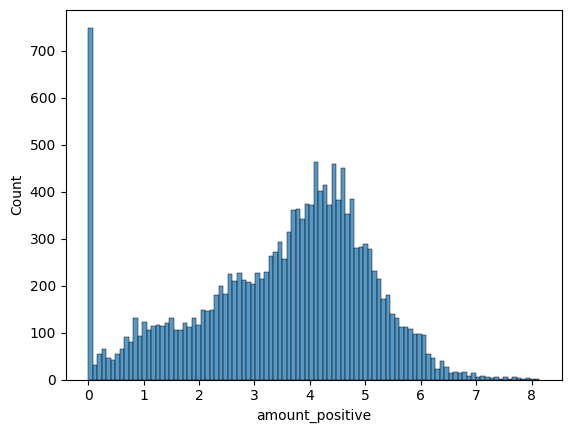

In [77]:
# Verify the normalized distribution
sns.histplot(train_df_logged['amount_positive'], bins=100)

In [78]:
# Final check regarding the datatypes and missing rows
train_df_logged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15998 entries, 1431851 to 5448467
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   use_chip                            15998 non-null  int64  
 1   merchant_city_te                    15998 non-null  float64
 2   merchant_state_te                   15998 non-null  float64
 3   zip_te                              15998 non-null  float64
 4   errors_te                           15998 non-null  float64
 5   spending_category_te                15998 non-null  float64
 6   card_brand                          15998 non-null  int64  
 7   card_type                           15998 non-null  int64  
 8   has_chip                            15998 non-null  int64  
 9   num_cards_issued                    15998 non-null  int64  
 10  current_age                         15998 non-null  int64  
 11  retirement_age                      15

In [79]:
# Final copy for model training
train_df = train_df_logged.copy()

In [80]:
# Final version of the training dataframe
AdvancedEDA(train_df).summary()

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 15998 entries, 1431851 to 5448467
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   use_chip                            15998 non-null  int64  
 1   merchant_city_te                    15998 non-null  float64
 2   merchant_state_te                   15998 non-null  float64
 3   zip_te                              15998 non-null  float64
 4   errors_te                           15998 non-null  float64
 5   spending_category_te                15998 non-null  float64
 6   card_brand                          15998 non-null  int64  
 7   card_type                           15998 non-null  int64  
 8   has_chip                            15998 non-null  int64  
 9   num_cards_issued                    15998 non-null  int64  
 10  current_age                         15998 non-null  int64  
 11  retirement_age    

use_chip  merchant_city_te  merchant_state_te  zip_te  errors_te  \
1431851         2            0.4304             0.1695  0.4304     0.4944   
5171666         0            0.5664             0.1695  0.5664     0.4944   
5172693         1            0.8520             0.8520  0.8814     0.4944   

         spending_category_te  card_brand  card_type  has_chip  \
1431851                0.3755           2          1         1   
5171666                0.6128           2          0         1   
5172693                0.9435           2          0         1   

         num_cards_issued  current_age  retirement_age  gender  address_te  \
1431851                 2           33              69       1      0.4859   
5171666                 1           33              69       1      0.4859   
5172693                 1           33              69       1      0.4859   

         credit_score  num_credit_cards  target  month_of_transaction  \
1431851           763                 4       0                     9   
5171666           763                 4       1                    10   
5172693           763                 4       1                    10   

         weekday_of_transaction  hour_of_transaction  season_of_transaction  \
1431851                       0                   22                      3   
5171666                       4                   10                      3   
5172693                       4                   16                      3   

         is_first_transaction  zero_credit_limit_flag  zero_debt_flag  \
1431851                     0                       0               0   
5171666                     0                       0               0   
5172693                     0                       0               0   

         had_any_errors  transaction_magnitude  credit_score_rating  \
1431851               0                      2                    4   
5171666               0                      1                    4   
5172693               0                      2                    4   

         amount_positive  amount_negative  years_until_retirement_log  \
1431851           4.0811           0.0000                      3.6109   
5171666           1.8132           0.0000                      3.6109   
5172693           4.1300           0.0000                      3.6109   

         days_since_pin_change_log  credit_limit_log  total_debt_log  \
1431851                     5.5413           10.3575         10.4968   
5171666                     6.5043            9.7757         10.4968   
5172693                     6.5043            9.7757         10.4968   

         purchase_to_credit_limit_ratio_log  credit_limit_to_debt_ratio_log  \
1431851                              0.0018                          0.6259   
5171666                              0.0003                          0.3962   
5172693                              0.0035                          0.3962   

         average_amount_per_merchant_log  merchant_fraud_rate_log  \
1431851                           4.0811                   0.0000   
5171666                           1.8132                   0.6931   
5172693                           4.1264                   0.6931   

         seconds_since_last_transaction_log  account_age_in_days_log  \
1431851                              0.0000                   5.4116   
5171666                             18.6856                   8.0003   
5172693                              9.9888                   8.0003   

         merchant_total_fraud_cases_log  per_capita_income_log  \
1431851                          0.0000                10.2832   
5171666                          0.6931                10.2832   
5172693                          2.5649                10.2832   

         yearly_income_log  count_of_important_errors_log  \
1431851            10.9956                         0.0000   
5171666            10.9956                         0.0000   
5172693            10


>>> Numerical Columns Summary:


use_chip  merchant_city_te  merchant_state_te     zip_te  errors_te  \
count 15998.0000        15998.0000         15998.0000 15998.0000 15998.0000   
mean      1.0164            0.6348             0.5057     0.6633     0.5011   
std       0.7829            0.2823             0.3989     0.2337     0.0469   
min       0.0000            0.0116             0.0170     0.2262     0.4363   
25%       0.0000            0.4040             0.0794     0.4240     0.4944   
50%       1.0000            0.8520             0.8520     0.8814     0.4944   
75%       2.0000            0.8520             0.8520     0.8814     0.4944   
max       2.0000            1.0000             1.0000     1.0000     0.9773   

       spending_category_te  card_brand  card_type   has_chip  \
count            15998.0000  15998.0000 15998.0000 15998.0000   
mean                 0.4976      2.1961     0.7609     0.9056   
std                  0.3167      0.7979     0.5957     0.2924   
min                  0.0000      0.0000     0.0000     0.0000   
25%                  0.2100      2.0000     0.0000     1.0000   
50%                  0.5252      2.0000     1.0000     1.0000   
75%                  0.8333      3.0000     1.0000     1.0000   
max                  1.0000      3.0000     2.0000     1.0000   

       num_cards_issued  current_age  retirement_age     gender  address_te  \
count        15998.0000   15998.0000      15998.0000 15998.0000  15998.0000   
mean             1.5192      54.9857         66.4942     0.4766      0.5116   
std              0.5176      15.6770          3.4960     0.4995      0.1017   
min              1.0000      23.0000         53.0000     0.0000      0.1919   
25%              1.0000      43.0000         65.0000     0.0000      0.4383   
50%              2.0000      52.0000         66.0000     0.0000      0.5012   
75%              2.0000      65.0000         68.0000     1.0000      0.5785   
max              3.0000     101.0000         79.0000     1.0000      0.8208   

       credit_score  num_credit_cards     target  month_of_transaction  \
count    15998.0000        15998.0000 15998.0000            15998.0000   
mean       714.6630            3.9698     0.5015                6.5214   
std         65.0970            1.6056     0.5000                3.4126   
min        488.0000            1.0000     0.0000                1.0000   
25%        685.0000            3.0000     0.0000                4.0000   
50%        716.0000            4.0000     1.0000                7.0000   
75%        756.0000            5.0000     1.0000                9.0000   
max        850.0000            9.0000     1.0000               12.0000   

       weekday_of_transaction  hour_of_transaction  season_of_transaction  \
count              15998.0000           15998.0000             15998.0000   
mean                   3.0869              12.2012                 2.4606   
std                    2.0262               4.4653                 1.1170   
min                    0.0000               0.0000                 1.0000   
25%                    1.0000               9.0000                 1.0000   
50%                    3.0000              12.0000                 2.0000   
75%                    5.0000              15.0000                 3.0000   
max                    6.0000              23.0000                 4.0000   

       is_first_transaction  zero_credit_limit_flag  zero_debt_flag  \
count            15998.0000              15998.0000      15998.0000   
mean                 0.0000                  0.0045          0.0573   
std                  0.0000                  0.0669          0.2323   
min                  0.0000                  0.0000          0.0000   
25%                  0.0000                  0.0000          0.0000   
50%                  0.0000                  0.0000          0.0000   
75%                  0.0000                  0.0000          0.0000   
max                  0.0000                  1.0000          1.0000  


-----
>>> No Categorical Columns Found

-----

>>> First 3 Rows of Entire DataFrame:


use_chip  merchant_city_te  merchant_state_te  zip_te  errors_te  \
1431851         2            0.4304             0.1695  0.4304     0.4944   
5171666         0            0.5664             0.1695  0.5664     0.4944   
5172693         1            0.8520             0.8520  0.8814     0.4944   

         spending_category_te  card_brand  card_type  has_chip  \
1431851                0.3755           2          1         1   
5171666                0.6128           2          0         1   
5172693                0.9435           2          0         1   

         num_cards_issued  current_age  retirement_age  gender  address_te  \
1431851                 2           33              69       1      0.4859   
5171666                 1           33              69       1      0.4859   
5172693                 1           33              69       1      0.4859   

         credit_score  num_credit_cards  target  month_of_transaction  \
1431851           763                 4       0                     9   
5171666           763                 4       1                    10   
5172693           763                 4       1                    10   

         weekday_of_transaction  hour_of_transaction  season_of_transaction  \
1431851                       0                   22                      3   
5171666                       4                   10                      3   
5172693                       4                   16                      3   

         is_first_transaction  zero_credit_limit_flag  zero_debt_flag  \
1431851                     0                       0               0   
5171666                     0                       0               0   
5172693                     0                       0               0   

         had_any_errors  transaction_magnitude  credit_score_rating  \
1431851               0                      2                    4   
5171666               0                      1                    4   
5172693               0                      2                    4   

         amount_positive  amount_negative  years_until_retirement_log  \
1431851           4.0811           0.0000                      3.6109   
5171666           1.8132           0.0000                      3.6109   
5172693           4.1300           0.0000                      3.6109   

         days_since_pin_change_log  credit_limit_log  total_debt_log  \
1431851                     5.5413           10.3575         10.4968   
5171666                     6.5043            9.7757         10.4968   
5172693                     6.5043            9.7757         10.4968   

         purchase_to_credit_limit_ratio_log  credit_limit_to_debt_ratio_log  \
1431851                              0.0018                          0.6259   
5171666                              0.0003                          0.3962   
5172693                              0.0035                          0.3962   

         average_amount_per_merchant_log  merchant_fraud_rate_log  \
1431851                           4.0811                   0.0000   
5171666                           1.8132                   0.6931   
5172693                           4.1264                   0.6931   

         seconds_since_last_transaction_log  account_age_in_days_log  \
1431851                              0.0000                   5.4116   
5171666                             18.6856                   8.0003   
5172693                              9.9888                   8.0003   

         merchant_total_fraud_cases_log  per_capita_income_log  \
1431851                          0.0000                10.2832   
5171666                          0.6931                10.2832   
5172693                          2.5649                10.2832   

         yearly_income_log  count_of_important_errors_log  \
1431851            10.9956                         0.0000   
5171666            10.9956                         0.0000   
5172693            10

## Test Set - Transformations

In [81]:
# Now inspecting the test set before transformations
test_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10666 entries, 8522515 to 2039757
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   transaction_id         10666 non-null  int64         
 1   date                   10666 non-null  datetime64[ns]
 2   amount                 10666 non-null  float64       
 3   use_chip               10666 non-null  object        
 4   merchant_id            10666 non-null  int64         
 5   merchant_city          10666 non-null  object        
 6   merchant_state         10666 non-null  object        
 7   zip                    10666 non-null  float64       
 8   errors                 10666 non-null  object        
 9   spending_category      10666 non-null  object        
 10  card_id                10666 non-null  int64         
 11  card_brand             10666 non-null  object        
 12  card_type              10666 non-null  object        
 13

In [82]:
# Confirming shape before transformation
test_df_raw.shape

(10666, 36)

In [83]:
def apply_transformations_for_test_set(
    raw_test_df,
    feature_engineer_artifacts,
    columns_to_drop,
    label_encoders_dict,
    trained_target_encoder,
    columns_to_normalize,
    columns_to_sign_split
):
    """
    Apply the same transformations to the test set as used for the training set.
    """

    # Work on a copy to preserve the original test set
    df = raw_test_df.copy()

    # --- Feature engineering ---
    df['month_of_transaction'] = df['date'].dt.month
    df['weekday_of_transaction'] = df['date'].dt.dayofweek
    df['hour_of_transaction'] = df['date'].dt.hour

    season_map = {12:4,1:4,2:4,3:1,4:1,5:1,6:2,7:2,8:2,9:3,10:3,11:3}
    df['season_of_transaction'] = df['month_of_transaction'].map(season_map)

    df = df.sort_values(by=['client_id','date'])
    df['seconds_since_last_transaction'] = (
        df.groupby('client_id')['date']
          .diff().dt.total_seconds()
          .fillna(0)
    )
    df['is_first_transaction'] = (df['seconds_since_last_transaction'] < 0).astype(int)

    df['account_age_in_days'] = (df['date'] - df['acct_open_date']).dt.days
    df['pin_change_date'] = pd.to_datetime(
        df['year_pin_last_changed'].astype(str),
        format='%Y', errors='coerce'
    )
    df['days_since_pin_change'] = (df['date'] - df['pin_change_date']).dt.days.clip(lower=0)
    df['years_until_retirement'] = df['retirement_age'] - df['current_age'].clip(lower=0)

    df['purchase_to_credit_limit_ratio'] = (
        df['amount'] / df['credit_limit'].replace(0, np.nan)
    ).fillna(0)
    df['zero_credit_limit_flag'] = (df['credit_limit'] == 0).astype(int)

    df['credit_limit_to_debt_ratio'] = (
        df['credit_limit'] / df['total_debt'].replace(0, np.nan)
    ).fillna(0)
    df['zero_debt_flag'] = (df['total_debt'] == 0).astype(int)

    important_errors = {"Bad Pin", "Bad CVV", "Insufficient Balance"}
    df['count_of_important_errors'] = df['errors'].apply(
        lambda s: sum(1 for e in s.split(',') if e.strip() in important_errors)
    )
    df['total_number_of_errors'] = df['errors'].apply(
        lambda s: 0 if s == 'No Errors' else s.count(',') + 1
    )
    df['had_any_errors'] = (df['errors'] != 'No Errors').astype(int)

    # --- Apply artifacts from training ---
    df['average_amount_per_merchant'] = (
        df['merchant_id']
          .map(feature_engineer_artifacts['average_amount_per_merchant'])
          .fillna(0)
    )
    df['merchant_fraud_rate'] = (
        df['merchant_id']
          .map(feature_engineer_artifacts['merchant_fraud_rate'])
          .fillna(feature_engineer_artifacts['merchant_fraud_rate'].mean())
    )
    df['merchant_total_fraud_cases'] = (
        df['merchant_id']
          .map(feature_engineer_artifacts['merchant_total_fraud_cases'])
          .fillna(0)
    )

    def _bin_amount(x):
        q = feature_engineer_artifacts['amount_quantiles']
        if x <= q['low']: return 0
        if x <= q['medium']: return 1
        if x <= q['high']: return 2
        if x <= q['very_high']: return 3
        return 4
    df['transaction_magnitude'] = df['amount'].apply(_bin_amount)

    def _bin_fico(x):
        th = feature_engineer_artifacts['fico_score_thresholds']
        if x <= th['poor']: return 0
        if x <= th['fair']: return 1
        if x <= th['good']: return 2
        if x <= th['very_good']: return 3
        if x <= th['exceptional']: return 4
        return 5
    df['credit_score_rating'] = df['credit_score'].apply(_bin_fico)

    # --- Drop unnecessary columns ---
    df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

    # --- Label encode small categoricals ---
    for col, encoder in label_encoders_dict.items():
        mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        df[col] = df[col].map(mapping).fillna(-1).astype(int)

    # --- Target encode high-cardinality categoricals ---
    df = trained_target_encoder.transform(df)

    # --- Normalize selected numeric features ---
    df = normalize_features(
        df,
        columns_to_normalize,
        columns_to_sign_split
    )

    # --- Final cleanup ---
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    return df

In [84]:
# Apply the full set of transformations to the raw test set
# Includes feature engineering, encoding, normalization, and cleanup
test_df = apply_transformations_for_test_set(
    raw_test_df=test_df_raw,
    feature_engineer_artifacts=training_feature_engineer_artifacts,
    columns_to_drop=all_columns_to_drop_after_engineering,
    label_encoders_dict=label_encoders,
    trained_target_encoder=target_encoder,
    columns_to_normalize=columns_to_normalize,
    columns_to_sign_split=columns_to_sign_split
)

# Rename target-encoded columns for clarity
test_df.rename(columns=te_column_rename_map, inplace=True)

# Review the final structure of the transformed test set
print(test_df.shape)
print(test_df.info())
test_df.head()

(10666, 44)
<class 'pandas.core.frame.DataFrame'>
Index: 10666 entries, 774655 to 7525457
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   use_chip                            10666 non-null  int64  
 1   merchant_city_te                    10666 non-null  float64
 2   merchant_state_te                   10666 non-null  float64
 3   zip_te                              10666 non-null  float64
 4   errors_te                           10666 non-null  float64
 5   spending_category_te                10666 non-null  float64
 6   card_brand                          10666 non-null  int64  
 7   card_type                           10666 non-null  int64  
 8   has_chip                            10666 non-null  int64  
 9   num_cards_issued                    10666 non-null  int64  
 10  current_age                         10666 non-null  int64  
 11  retirement_age             

use_chip  merchant_city_te  merchant_state_te  zip_te  errors_te  \
774655          2            0.4304             0.1695  0.4304     0.4944   
790613          2            0.5015             0.1695  0.5015     0.4944   
1423996         2            0.4304             0.1695  0.4304     0.4944   
2663417         1            0.8520             0.8520  0.8814     0.4944   
2667509         2            0.4304             0.1695  0.4304     0.4944   

         spending_category_te  card_brand  card_type  has_chip  \
774655                 0.3690           2          0         1   
790613                 0.8340           2          0         1   
1423996                0.3620           2          1         1   
2663417                0.4403           2          1         1   
2667509                0.0561           2          0         1   

         num_cards_issued  current_age  retirement_age  gender  address_te  \
774655                  1           33              69       1      0.4859   
790613                  1           33              69       1      0.4859   
1423996                 2           33              69       1      0.4859   
2663417                 2           33              69       1      0.4859   
2667509                 1           33              69       1      0.4859   

         credit_score  num_credit_cards  target  month_of_transaction  \
774655            763                 4       0                    12   
790613            763                 4       0                    12   
1423996           763                 4       0                     9   
2663417           763                 4       0                     2   
2667509           763                 4       0                     2   

         weekday_of_transaction  hour_of_transaction  season_of_transaction  \
774655                        1                   14                      4   
790613                        1                   13                      4   
1423996                       4                   14                      3   
2663417                       0                    1                      4   
2667509                       1                   15                      4   

         is_first_transaction  zero_credit_limit_flag  zero_debt_flag  \
774655                      0                       0               0   
790613                      0                       0               0   
1423996                     0                       0               0   
2663417                     0                       0               0   
2667509                     0                       0               0   

         had_any_errors  transaction_magnitude  credit_score_rating  \
774655                0                      2                    4   
790613                0                      2                    4   
1423996               0                      2                    4   
2663417               0                      3                    4   
2667509               0                      2                    4   

         amount_positive  amount_negative  years_until_retirement_log  \
774655            2.8385           0.0000                      3.6109   
790613            4.0845           0.0000                      3.6109   
1423996           3.3576           0.0000                      3.6109   
2663417           4.6626           0.0000                      3.6109   
2667509           3.9431           0.0000                      3.6109   

         days_since_pin_change_log  credit_limit_log  total_debt_log  \
774655                      0.0000            9.7757         10.4968   
790613                      0.0000            9.7757         10.4968   
1423996                     5.5294           10.3575         10.4968   
2663417                     6.6412           10.3575         10.4968   
2667509                     0.0000            9.7757         10.4968   

         purchase_to_credit_

## Creating X_test/train and y_test/train set

In [85]:
# Training Set
y_train = train_df["target"]
X_train = train_df.drop(columns=["target"])

# Test Set
y_test = test_df["target"]
X_test = test_df.drop(columns=["target"])

# Quick shape check to make sure everything lines up
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")

# Check for missing values in each feature set
print("\nMissing values in X_train by column:")
print(X_train.isna().sum())

print("\nMissing values in X_test by column:")
print(X_test.isna().sum())

X_train: (15998, 43), y_train: (15998,)
X_test:  (10666, 43),  y_test:  (10666,)

Missing values in X_train by column:
use_chip                              0
merchant_city_te                      0
merchant_state_te                     0
zip_te                                0
errors_te                             0
spending_category_te                  0
card_brand                            0
card_type                             0
has_chip                              0
num_cards_issued                      0
current_age                           0
retirement_age                        0
gender                                0
address_te                            0
credit_score                          0
num_credit_cards                      0
month_of_transaction                  0
weekday_of_transaction                0
hour_of_transaction                   0
season_of_transaction                 0
is_first_transaction                  0
zero_credit_limit_flag                0
z

## Saving Final Training & Test Sets to CSV

In [86]:
import os

# Ensure the directory exists
os.makedirs(processed_data_dir, exist_ok=True)

# Save train and test sets
X_train.to_csv(os.path.join(processed_data_dir, 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(processed_data_dir, 'X_test.csv'), index=False)

y_train.to_csv(os.path.join(processed_data_dir, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(processed_data_dir, 'y_test.csv'), index=False)

# Save column datatypes
column_dtypes = X_train.dtypes.reset_index()
column_dtypes.columns = ['Column', 'DataType']
column_dtypes.to_csv(os.path.join(processed_data_dir, 'Columns_Datatype_X.csv'), index=False)

## Re-Importing Training & Test Sets

For convenience sake, so we do not need to re-run the Data Preperation Code everytime we were tuning / running the modelling section of the code

In [87]:
import pandas as pd
from pathlib import Path

# Dynamically locate the project root (the directory containing this script)
try:
    base_dir = Path(__file__).parent.resolve()
except NameError:
    # Fallback when running in a notebook
    base_dir = Path.cwd()

# Define the directory where the processed CSVs live
processed_data_dir = base_dir / "Processed Dataset"

# Verify the directory exists
if not processed_data_dir.exists():
    raise FileNotFoundError(f"No such directory: {processed_data_dir!r}")

# Load the feature matrices and target vectors from CSV
X_train = pd.read_csv(processed_data_dir / "X_train.csv")
X_test  = pd.read_csv(processed_data_dir / "X_test.csv")
y_train = pd.read_csv(processed_data_dir / "y_train.csv").squeeze()  # squeeze as its one column and avoids errors for model training
y_test  = pd.read_csv(processed_data_dir / "y_test.csv").squeeze()

print("Loaded shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test : {X_test.shape}")
print(f"  y_test : {y_test.shape}")

Loaded shapes:
  X_train: (15998, 43)
  y_train: (15998,)
  X_test : (10666, 43)
  y_test : (10666,)


# Training the Models

## Loading the required Modules

In [88]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_validate
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_squared_error,
    make_scorer,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    PrecisionRecallDisplay
)
from sklearn.base import clone

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier


## Baseline Model

### Baseline - Logistic Regression

We will start with a baseline model to assess its performance and understand how much we can improve its predictive capabilities.

In [89]:
# Initialize and train the logistic regression model baseline model using the training data
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


/home/ucloud/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     10651
           1       0.01      0.93      0.02        15

    accuracy                           0.88     10666
   macro avg       0.51      0.91      0.48     10666
weighted avg       1.00      0.88      0.93     10666



<Figure size 600x600 with 0 Axes>

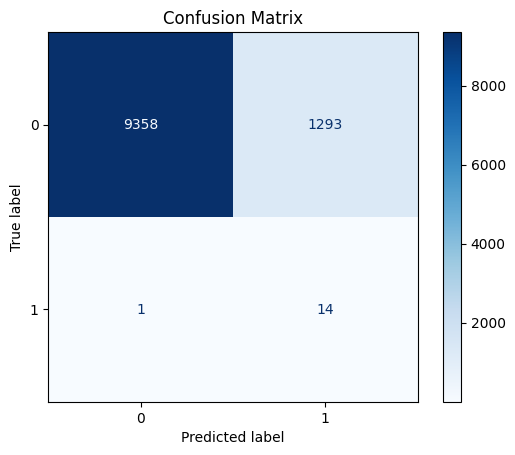

In [90]:
# Generate predictions on the test set
y_pred = log_reg.predict(X_test)

# Print standard classification metrics (precision, recall, f1-score, support)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

The model is not very reliable, as it produces a high number of false positives. Our goal, therefore, is to maximize recall while also striving to achieve the best possible level of precision

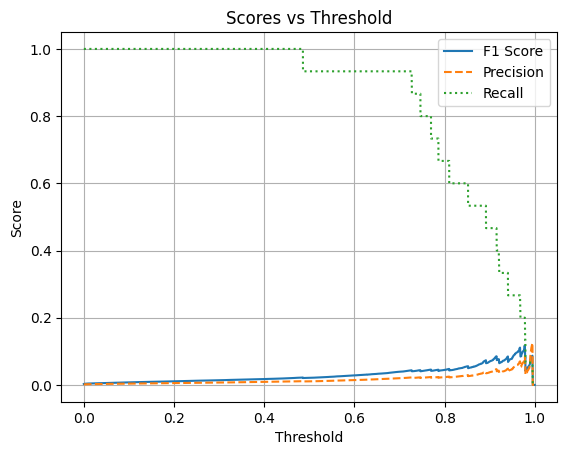

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get predicted probabilities for the positive class
y_probs_lr = log_reg.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds for the model
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_lr)

# Calculate F1 score at each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Plot F1 score, precision, and recall against decision thresholds
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle=':')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Scores vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


--- Threshold: 0.53 ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     10651
           1       0.01      0.93      0.02        15

    accuracy                           0.89     10666
   macro avg       0.51      0.91      0.48     10666
weighted avg       1.00      0.89      0.94     10666



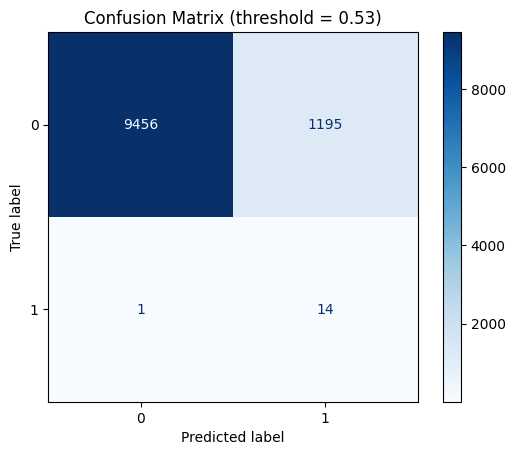


--- Threshold: 0.55 ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     10651
           1       0.01      0.93      0.02        15

    accuracy                           0.89     10666
   macro avg       0.51      0.91      0.48     10666
weighted avg       1.00      0.89      0.94     10666



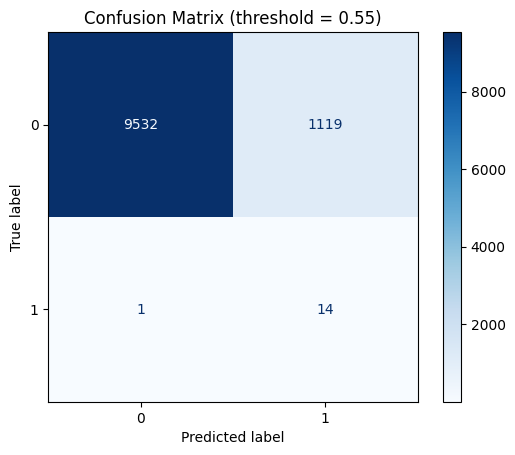


--- Threshold: 0.56 ---
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     10651
           1       0.01      0.93      0.03        15

    accuracy                           0.90     10666
   macro avg       0.51      0.92      0.49     10666
weighted avg       1.00      0.90      0.95     10666



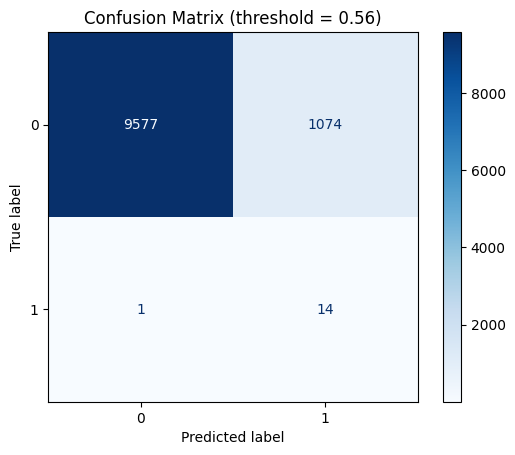


--- Threshold: 0.58 ---
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     10651
           1       0.01      0.93      0.03        15

    accuracy                           0.90     10666
   macro avg       0.51      0.92      0.49     10666
weighted avg       1.00      0.90      0.95     10666



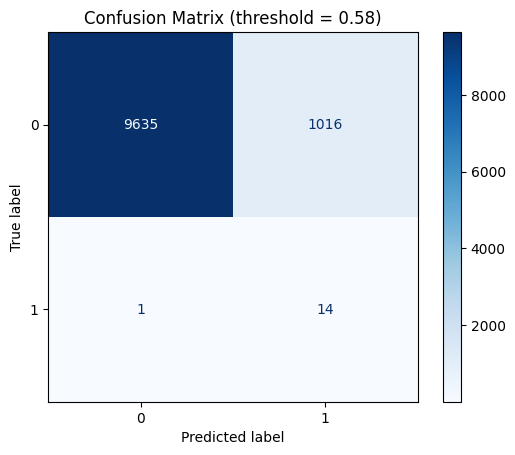


--- Threshold: 0.6 ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     10651
           1       0.01      0.93      0.03        15

    accuracy                           0.91     10666
   macro avg       0.51      0.92      0.49     10666
weighted avg       1.00      0.91      0.95     10666



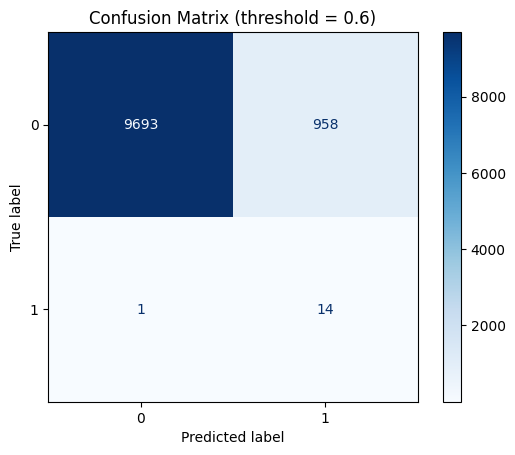

In [92]:
# Compute precision, recall, and threshold values from the test set
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test, y_probs_lr)

# Define a list of thresholds to evaluate
thresholds_to_test = [0.53, 0.55, 0.56, 0.58, 0.6]

# Evaluate model performance at each selected threshold
for threshold in thresholds_to_test:
    y_pred = (y_probs_lr >= threshold).astype(int)

    print(f"\n--- Threshold: {threshold} ---")
    print(classification_report(y_test, y_pred, zero_division=0))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f"Confusion Matrix (threshold = {threshold})")
    plt.show()

## Logistic Regression

we will start defining the pipeline:

a) Standard Scaler - As PCA is sensitive to feature scale

b) Dimensionality reduction with PCA - To reduce the feature Space

b) Classification using LogisticRegression. 

#### Building Tuned Model

In [93]:
# Creating the pipeline and listing the parameters to tune
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ('pca', PCA()),
    ('logreg', LogisticRegression(max_iter=1000))
])

param_grid = {
    'pca__n_components': [36], # Tried Parameters: 1, 20, 29, 30, 32, 33, 35, 36, 37, 38, 39
    'logreg__C': [0.1], # Tried Parameters: 0.01, 0.1, 1, 10
    'logreg__penalty': ['l2'], # Tried Parameters: elastic net
    'logreg__solver': ['liblinear'], # Tried Parameters: 'saga', 'liblinear', 'newton-cg', 'sag', 'lsqr', 'lbfgs'
}

In [94]:
# Applying the Gridsearch, scoring on recall
grid = GridSearchCV(pipeline, param_grid, cv=6, scoring='recall')
grid.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logreg__C': [0.1], 'logreg__penalty': ['l2'],
                         'logreg__solver': ['liblinear'],
                         'pca__n_components': [36]},
             scoring='recall')

When GridSearchCV is applied with 6-fold cross-validation (cv=6) and max_iter=1000, here's what happens for each hyperparameter combination:

Step 1: The training data is standardized.

Step 2: PCA is applied to reduce dimensionality to the specified number of components.

Step 3: Logistic Regression is trained on the transformed data.

Training iterations: For each fold, the logistic regression model may perform up to 1000 iterations to converge to optimal weights.

Cross-validation: Since 6 folds are used, each combination is trained and evaluated 6 times.

Total iterations per combination: Up to 6 × 1000 = 6,000 iterations.

If the grid contains 120 combinations, this results in a total of up to 720,000 training iterations across the entire grid search.

This process ensures a thorough evaluation of each hyperparameter set, but it can be computationally intensive depending on the number of combinations and data size.

#### Best Hyperparameters and Scores

In [95]:
# Extract best parameters and score
best_params = grid.best_params_
best_score = grid.best_score_

# Convert to DataFrame for pretty display
results_df = pd.DataFrame([{
    'PCA Components': best_params['pca__n_components'],
    'Regularization (C)': best_params['logreg__C'],
    'Penalty': best_params['logreg__penalty'],
    'Solver': best_params['logreg__solver'],
    'Best Recall Score (CV)': round(best_score, 4)
}])

# Display the table
print(results_df)

   PCA Components  Regularization (C) Penalty     Solver  \
0              36              0.1000      l2  liblinear   

   Best Recall Score (CV)  
0                  0.9796  


#### Overfitting Analysis

From now on, when we want to assess whether the model is overfitting, we will use StratifiedKFold — a method particularly useful for cross-validation, as introduced in the “Measuring Accuracy Using Cross-Validation” section of the book.

In [96]:
# Recreate the Best Pipeline 
best_pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=grid.best_params_['pca__n_components'])),
    ('logreg', LogisticRegression(
        C=grid.best_params_['logreg__C'],
        penalty='l2',
        solver=grid.best_params_['logreg__solver'],
        max_iter=10000
    ))
])

In [97]:
# Set up stratified K-fold cross-validation to maintain class balance across folds
skfolds = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
train_f1s, val_f1s = [], []
train_accs, val_accs = [], []
train_recalls, val_recalls = [], []

# Perform cross-validation using the provided pipeline
for train_index, test_index in skfolds.split(X_train, y_train):
    # Split data into training and validation folds
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = X_train.iloc[test_index]
    y_val_fold = y_train.iloc[test_index]

    # Clone the model to ensure independence across folds
    clone_model = clone(best_pipeline_lr)
    clone_model.fit(X_train_fold, y_train_fold)

    # Predict and store metrics for both train and validation sets
    y_train_pred = clone_model.predict(X_train_fold)
    y_val_pred = clone_model.predict(X_val_fold)

    train_f1s.append(f1_score(y_train_fold, y_train_pred))
    val_f1s.append(f1_score(y_val_fold, y_val_pred))

    train_accs.append(accuracy_score(y_train_fold, y_train_pred))
    val_accs.append(accuracy_score(y_val_fold, y_val_pred))

    train_recalls.append(recall_score(y_train_fold, y_train_pred))
    val_recalls.append(recall_score(y_val_fold, y_val_pred))

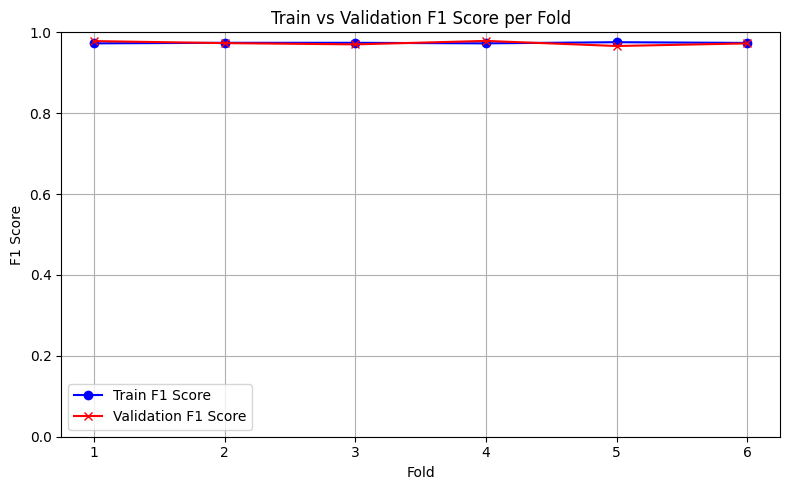

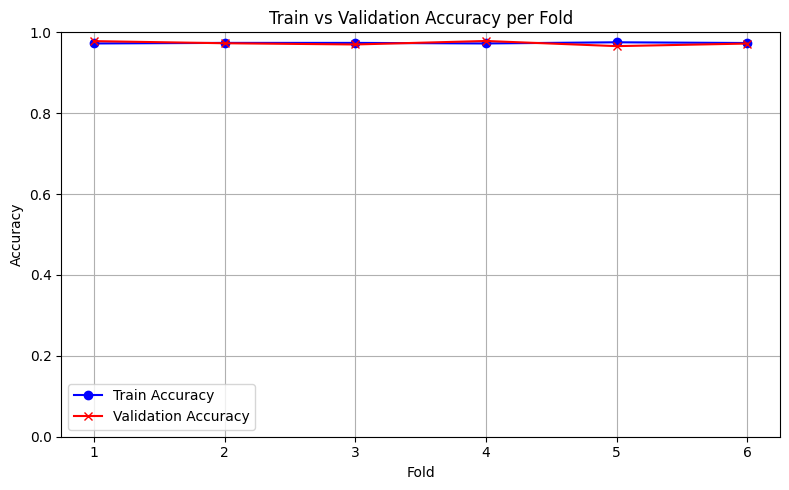

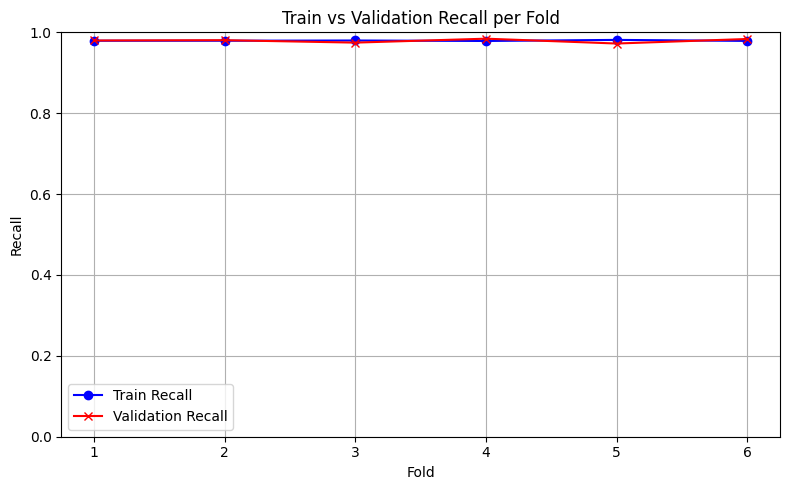

In [98]:
# Plotting Metric Scorings per Fold

def plot_metric(train, val, metric_name):
    folds = range(1, len(train)+1)
    plt.figure(figsize=(8,5))
    plt.plot(folds, train, marker='o', label=f"Train {metric_name}", color='blue')
    plt.plot(folds, val, marker='x', label=f"Validation {metric_name}", color='red')
    plt.title(f"Train vs Validation {metric_name} per Fold")
    plt.xlabel("Fold")
    plt.ylabel(metric_name)
    plt.ylim(0, 1)
    plt.xticks(folds)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric(train_f1s, val_f1s, "F1 Score")
plot_metric(train_accs, val_accs, "Accuracy")
plot_metric(train_recalls, val_recalls, "Recall")

Since the performance across the three evaluated metrics—accuracy, recall, and F1-score—shows no significant difference between the training and validation sets, the model does not appear to suffer from overfitting. This indicates that the model has good generalization capabilities, maintaining stable performance even on unseen data, such as the validation set.


#### Testing the Tuned Model

In [99]:
# Final Model Evaluation 
best_pipeline_lr.fit(X_train, y_train)
y_probs_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]

We want to see how the Confusion Matrix changes based on the diffenrent thresholds. Since our primary objective is to maximize recall while still optimizing the other parameters, we can use a graph that compares these metrics across different threshold levels, helping us identify the optimal threshold for the model.

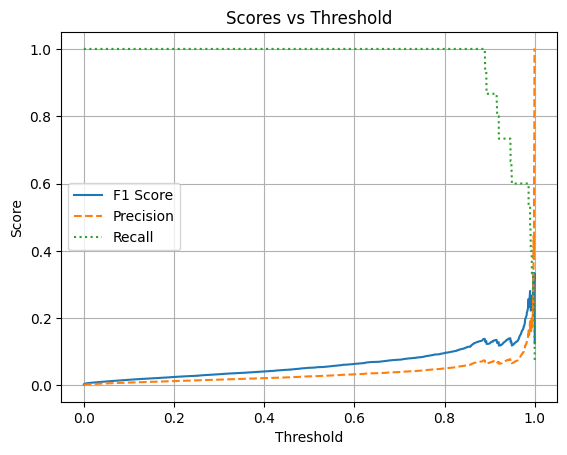

In [100]:
# Calculate precision, recall, and thresholds from predicted probabilities
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_lr)

# Compute F1 scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Plot F1 score, precision, and recall across different thresholds
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle=':')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Scores vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


--- Threshold: 0.88 ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10651
           1       0.07      1.00      0.13        15

    accuracy                           0.98     10666
   macro avg       0.54      0.99      0.56     10666
weighted avg       1.00      0.98      0.99     10666



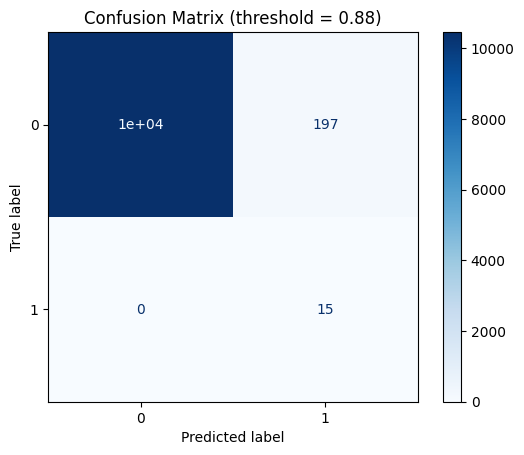


--- Threshold: 0.93 ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10651
           1       0.07      0.73      0.12        15

    accuracy                           0.99     10666
   macro avg       0.53      0.86      0.56     10666
weighted avg       1.00      0.99      0.99     10666



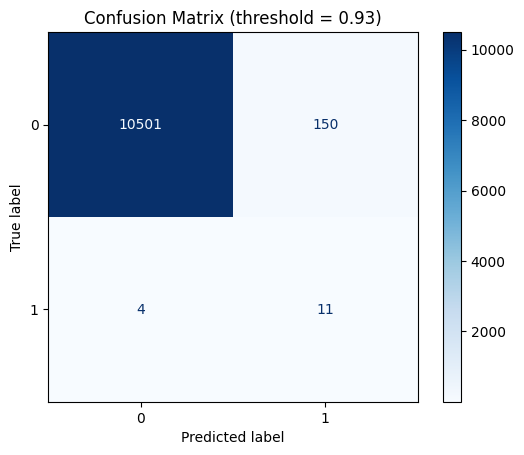


--- Threshold: 0.95 ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10651
           1       0.07      0.60      0.12        15

    accuracy                           0.99     10666
   macro avg       0.53      0.79      0.56     10666
weighted avg       1.00      0.99      0.99     10666



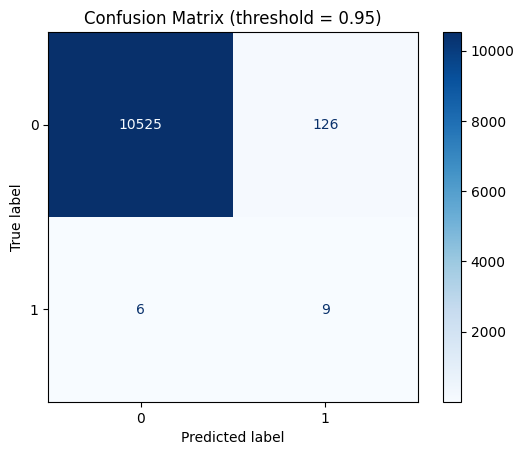

In [101]:
# Evaluate model performance at selected thresholds
precisions_lr, recalls_lr, thresholds = precision_recall_curve(y_test, y_probs_lr)

thresholds_to_test = [0.88, 0.93, 0.95]

for threshold in thresholds_to_test:
    # Apply threshold to convert probabilities to binary predictions
    y_pred = (y_probs_lr >= threshold).astype(int)

    print(f"\n--- Threshold: {threshold} ---")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Display confusion matrix for each threshold
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f"Confusion Matrix (threshold = {threshold})")
    plt.show()

The most interesting thresholds are [0.88, 0.93, 0.95], as these represent the points where, for the same number of false negatives, we can significantly reduce the number of false positives. This demonstrates how model tuning has greatly enhanced its performance, making it more reliable.

## XGBOOST

### Baseline - XGBOOST

In [102]:
# Initialize and train an XGBoost classifier on the training data
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

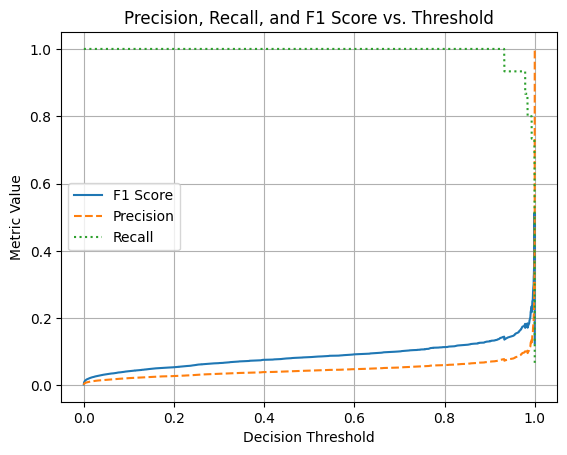


--- Evaluation at Threshold = 0.9000 ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10651
           1       0.07      1.00      0.13        15

    accuracy                           0.98     10666
   macro avg       0.54      0.99      0.56     10666
weighted avg       1.00      0.98      0.99     10666



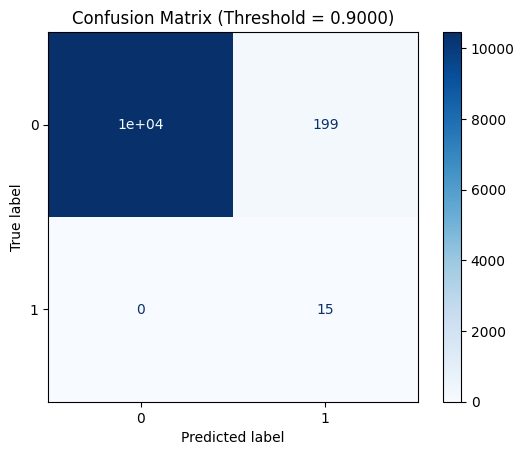


--- Evaluation at Threshold = 0.9300 ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10651
           1       0.08      1.00      0.14        15

    accuracy                           0.98     10666
   macro avg       0.54      0.99      0.57     10666
weighted avg       1.00      0.98      0.99     10666



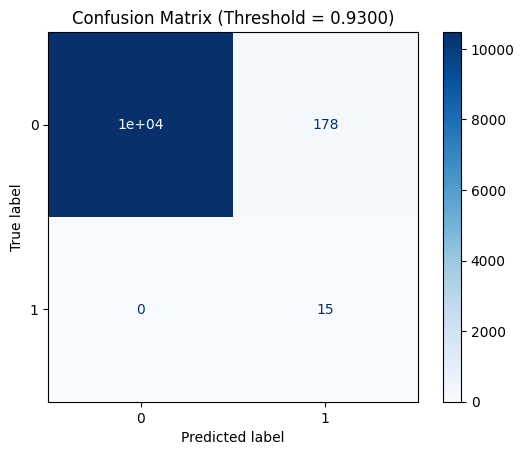


--- Evaluation at Threshold = 0.9500 ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10651
           1       0.08      0.93      0.15        15

    accuracy                           0.98     10666
   macro avg       0.54      0.96      0.57     10666
weighted avg       1.00      0.98      0.99     10666



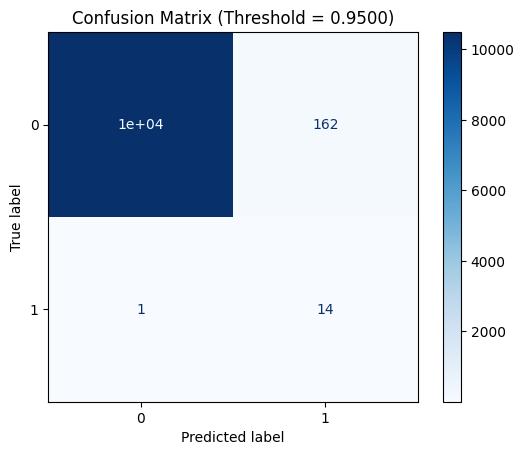

In [103]:
# Obtain predicted probabilities for the positive class (1)
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Compute precision, recall, and the corresponding decision thresholds
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(
    y_test,
    y_probs_xgb
)

# Calculate the F1 score at each threshold
f1_scores_xgb = 2 * (precisions_xgb * recalls_xgb) / (
    precisions_xgb + recalls_xgb + 1e-10
)

# Plot F1, precision, and recall as functions of the decision threshold
plt.plot(thresholds_xgb, f1_scores_xgb[:-1], label='F1 Score')
plt.plot(thresholds_xgb, precisions_xgb[:-1], linestyle='--', label='Precision')
plt.plot(thresholds_xgb, recalls_xgb[:-1],    linestyle=':',  label='Recall')

# Label axes and add a title
plt.xlabel('Decision Threshold')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, and F1 Score vs. Threshold')

# Display legend and grid for readability
plt.legend()
plt.grid(True)
plt.show()

# Define a set of thresholds to evaluate with confusion matrices
thresholds_to_test = [0.9, 0.93, 0.95 ]

# For each chosen threshold:
#  1) compute binary predictions
#  2) print the classification report
#  3) display the corresponding confusion matrix
for threshold in thresholds_to_test:
    y_pred = (y_probs_xgb >= threshold).astype(int)
    
    print(f"\n--- Evaluation at Threshold = {threshold:.4f} ---")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        cmap='Blues'
    )
    plt.title(f"Confusion Matrix (Threshold = {threshold:.4f})")
    plt.show()

Although the model’s overall reliability is limited, the baseline XGBoost model generates almost no false positives—outperforming the logistic regression baseline in that respect—yet it still exhibits only a slightly lower rate of false positives.

### Tuned - XGBOOST

We will start defining the pipeline:

a) classification using XGBoostClassifier.

b) Test different parameters via the GridSearchCV

#### Building Tuned Model

In [104]:
# Define the pipeline
pipeline = Pipeline([ 
    ('xgbclassifier', XGBClassifier())  # XGBClassifier
])

# Define the hyperparameter grid
param_grid = {
    'xgbclassifier__max_depth': [20], # Tried Parameters: 1, 2, 3, 5, 9, 11, 15, 20, 21, 22
    'xgbclassifier__n_estimators': [250], # Tried Parameters: 250, 260, 300, 100
    'xgbclassifier__learning_rate': [0.9], # Tried Parameters: 0.05, 0.09, 0.9, 1, 2
    'xgbclassifier__subsample': [0.9], # Tried Parameters: 0.9 0.05, 1, 2
    'xgbclassifier__colsample_bytree': [0.6], #Tried Parameters: 0.3, 0.5, 0.6, 1
    'xgbclassifier__gamma': [0.5], # Tried Parameters: 0.3, 0.5, 0.6, 1
}

#### Stratified K-Folds

In [105]:
# Define number of cross-validation folds to test
folds_range = [20]  # Tried Parameters: 5, 10, 15, 20, 25

# Store grid search results
results = []

# Run GridSearchCV for each fold count
for folds in folds_range:
    print(f"Testing with {folds} folds...")
    
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='recall',   # Focus on recall due to class imbalance
        cv=skf,
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    results.append({
        'folds': folds,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    })

# Display the results as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Testing with 20 folds...
Fitting 20 folds for each of 1 candidates, totalling 20 fits


   folds  best_score                                        best_params
0     20      0.9920  {'xgbclassifier__colsample_bytree': 0.6, 'xgbc...


We have implemented:
- StratifiedKFold: used to ensure that each fold has the same proportion (approximately) of each target class to validate the outcome.

#### Best Hyperparameters and Scores

In [106]:
# Find the best fold number based on the highest best score
best_result = max(results, key=lambda x: x['best_score'])

# Extract best parameters and score
best_params = best_result['best_params']
best_score = best_result['best_score']
results_df = pd.DataFrame([{
    'Number of Folds': best_result['folds'],
    'Best Parameters': best_params,
    'Best recall Score': round(best_score, 4)
}])

# Display the table
print(results_df)


   Number of Folds                                    Best Parameters  \
0               20  {'xgbclassifier__colsample_bytree': 0.6, 'xgbc...   

   Best recall Score  
0             0.9920  


In [107]:
print(best_params)

{'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.9, 'xgbclassifier__max_depth': 20, 'xgbclassifier__n_estimators': 250, 'xgbclassifier__subsample': 0.9}


In [108]:
# Extract best parameters
best_params = best_result['best_params']

best_pipeline_xgb = Pipeline([
    ('xgbclassifier', XGBClassifier(
        max_depth=best_params['xgbclassifier__max_depth'],
        n_estimators=best_params['xgbclassifier__n_estimators'],
        learning_rate=best_params['xgbclassifier__learning_rate'],
        subsample=best_params['xgbclassifier__subsample'],
        colsample_bytree=best_params['xgbclassifier__colsample_bytree'],
        gamma=best_params['xgbclassifier__gamma']
    ))
])

# Display the pipeline
print(best_pipeline_xgb)

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.9,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strate

#### Overfitting Analysis

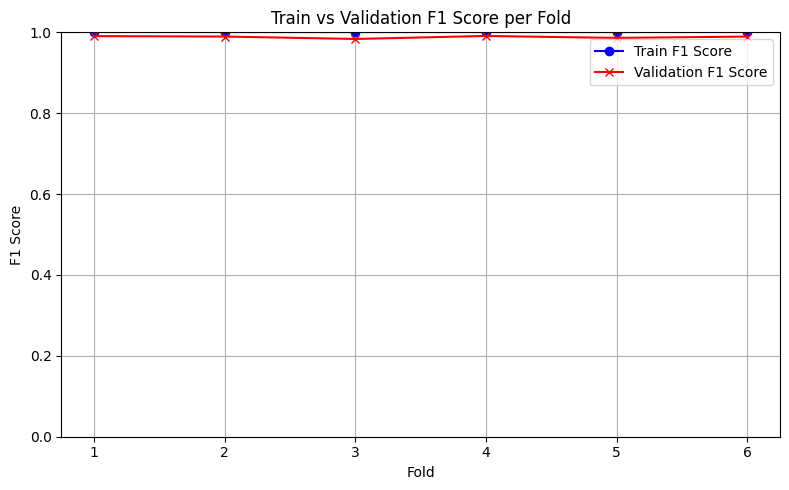

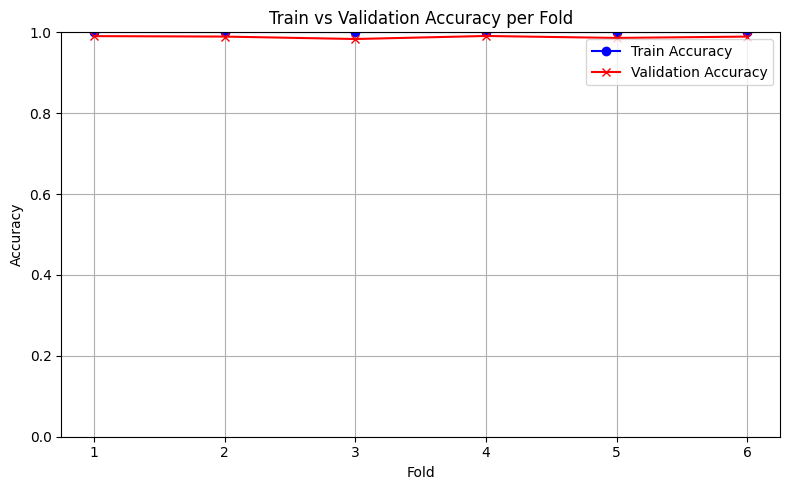

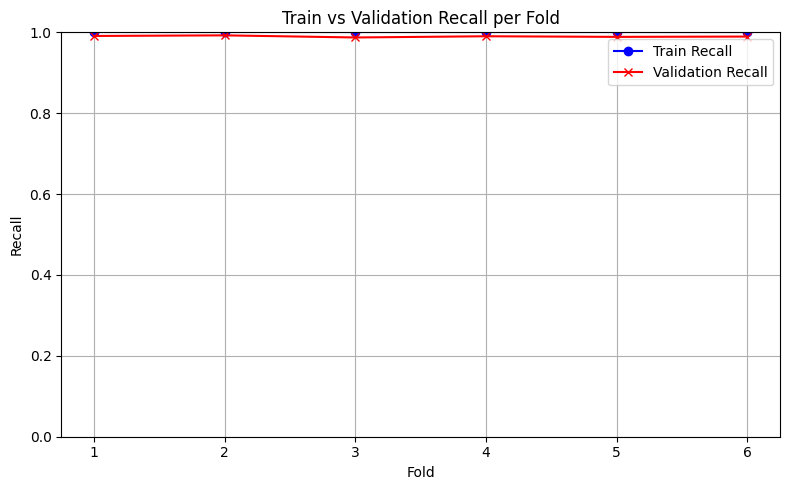

In [109]:
# StratifiedKFold cross-validation setup
skfolds = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
train_f1s, val_f1s = [], []
train_accs, val_accs = [], []
train_recalls, val_recalls = [], []

# Loop through the splits
for train_index, test_index in skfolds.split(X_train, y_train):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = X_train.iloc[test_index]
    y_val_fold = y_train.iloc[test_index]

    # Clone the model to prevent overwriting the best pipeline
    clone_model = clone(best_pipeline_xgb)
    clone_model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_train_pred = clone_model.predict(X_train_fold)
    y_val_pred = clone_model.predict(X_val_fold)

    # Append scores for each fold
    train_f1s.append(f1_score(y_train_fold, y_train_pred))
    val_f1s.append(f1_score(y_val_fold, y_val_pred))

    train_accs.append(accuracy_score(y_train_fold, y_train_pred))
    val_accs.append(accuracy_score(y_val_fold, y_val_pred))

    train_recalls.append(recall_score(y_train_fold, y_train_pred))
    val_recalls.append(recall_score(y_val_fold, y_val_pred))

# Function to plot metrics
def plot_metric(train, val, metric_name):
    folds = range(1, len(train)+1)
    plt.figure(figsize=(8,5))
    plt.plot(folds, train, marker='o', label=f"Train {metric_name}", color='blue')
    plt.plot(folds, val, marker='x', label=f"Validation {metric_name}", color='red')
    plt.title(f"Train vs Validation {metric_name} per Fold")
    plt.xlabel("Fold")
    plt.ylabel(metric_name)
    plt.ylim(0, 1)
    plt.xticks(folds)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting the metrics
plot_metric(train_f1s, val_f1s, "F1 Score")
plot_metric(train_accs, val_accs, "Accuracy")
plot_metric(train_recalls, val_recalls, "Recall")

#### Testing the Tuned Model

In [110]:
# Final Model Evaluation
best_pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.9,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=250, n_jobs=None,
                               num_parallel_tree=None, ...))])

Inspecting the Precision Recall Curve

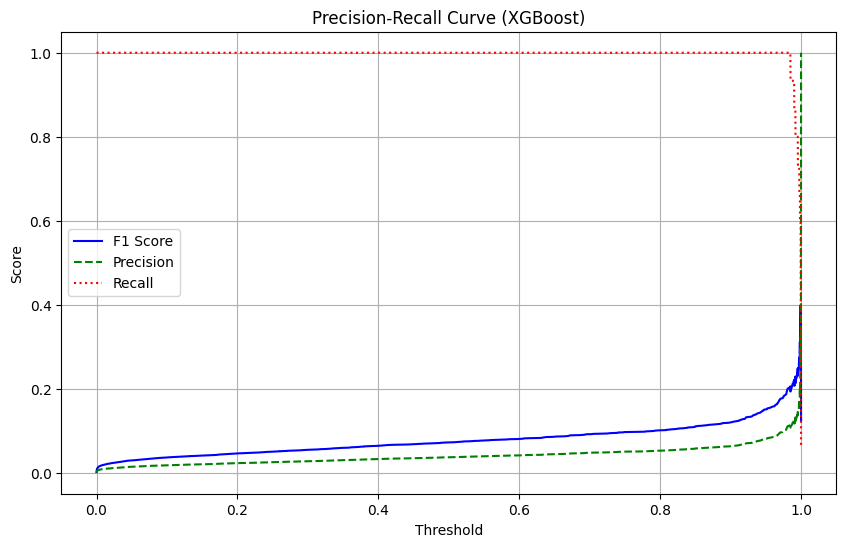

In [111]:
# Generate predicted probabilities for the positive class using the best XGBoost pipeline
y_probs = best_pipeline_xgb.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate F1 scores at each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Plot precision, recall, and F1 score across thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='blue')
plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--', color='green')
plt.plot(thresholds, recalls[:-1], label='Recall', linestyle=':', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

Inspecting the Confusion Matrix


----------------------- Threshold: 0.984 -----------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10651
           1       0.11      1.00      0.21        15

    accuracy                           0.99     10666
   macro avg       0.56      0.99      0.60     10666
weighted avg       1.00      0.99      0.99     10666



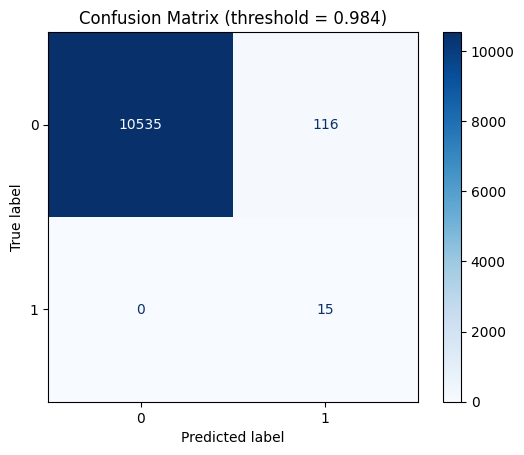


----------------------- Threshold: 0.991 -----------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10651
           1       0.12      0.87      0.21        15

    accuracy                           0.99     10666
   macro avg       0.56      0.93      0.60     10666
weighted avg       1.00      0.99      0.99     10666



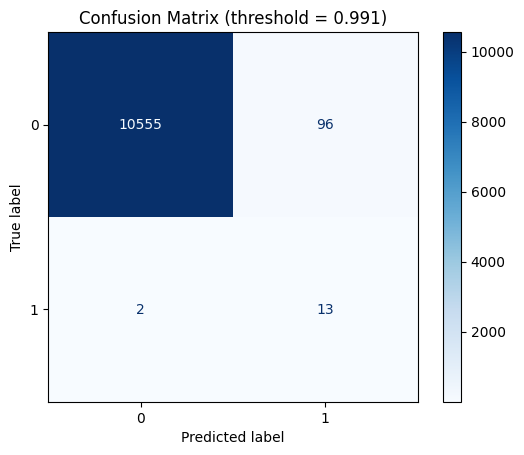


----------------------- Threshold: 0.73 -----------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     10651
           1       0.05      1.00      0.10        15

    accuracy                           0.97     10666
   macro avg       0.53      0.99      0.54     10666
weighted avg       1.00      0.97      0.99     10666



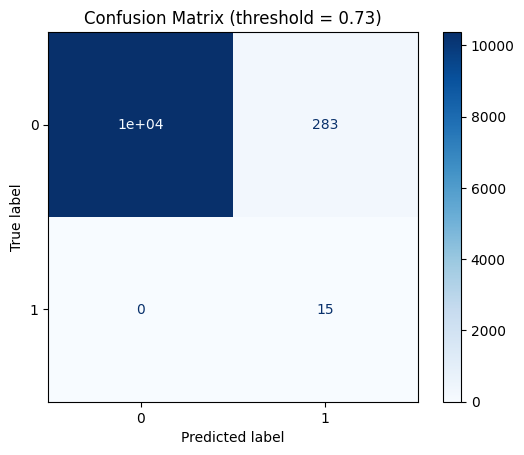


----------------------- Threshold: 0.75 -----------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     10651
           1       0.05      1.00      0.10        15

    accuracy                           0.97     10666
   macro avg       0.53      0.99      0.54     10666
weighted avg       1.00      0.97      0.99     10666



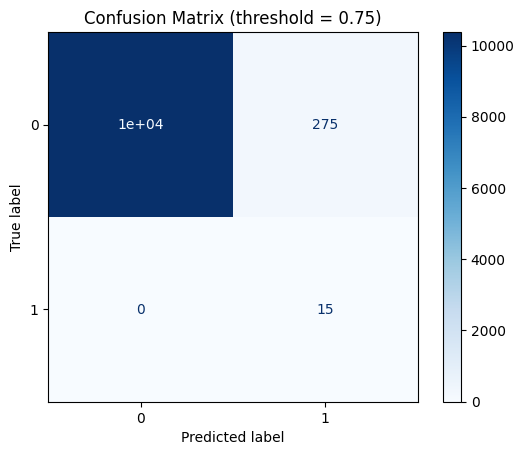


----------------------- Threshold: 0.8 -----------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10651
           1       0.05      1.00      0.10        15

    accuracy                           0.98     10666
   macro avg       0.53      0.99      0.54     10666
weighted avg       1.00      0.98      0.99     10666



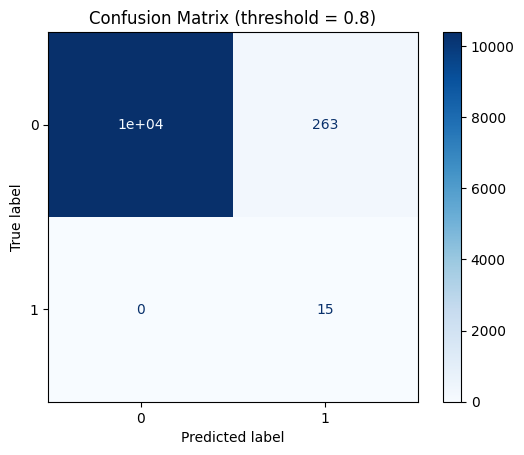

In [112]:
# Get predicted probabilities for the positive class
y_probs = best_pipeline_xgb.predict_proba(X_test)[:, 1]

# Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Evaluate model performance at selected thresholds
thresholds_to_test = [0.984, 0.991, 0.73, 0.75, 0.8]  # Previously tried: 0.021, 0.09, 0.1, 0.37, 0.42

for threshold in thresholds_to_test:
    y_pred = (y_probs >= threshold).astype(int)

    print(f"\n----------------------- Threshold: {threshold} -----------------------")
    print(classification_report(y_test, y_pred, zero_division=0))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f"Confusion Matrix (threshold = {threshold})")
    plt.show()

## SVM

Support Vector Classification (SVC) can employ two primary kernel functions to model nonlinear relationships—namely, the polynomial kernel and the Gaussian radial basis function (RBF) kernel. Due to the substantial computational overhead associated with each kernel, we implement them as two separate models. This separation facilitates a focused comparison of their respective behaviors and performance under identical experimental conditions.

### Baseline - SVM - Polynomial Kernel

In [113]:
# Create a pipeline with a polynomial kernel SVM classifier
poly_kernel_svm_clf = Pipeline([
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

# Train the SVM model on the training set
poly_kernel_svm_clf.fit(X_train, y_train)

# Generate predictions on the test set
predictions_svm_bl = poly_kernel_svm_clf.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     10651
           1       0.01      0.87      0.01        15

    accuracy                           0.80     10666
   macro avg       0.50      0.83      0.45     10666
weighted avg       1.00      0.80      0.89     10666



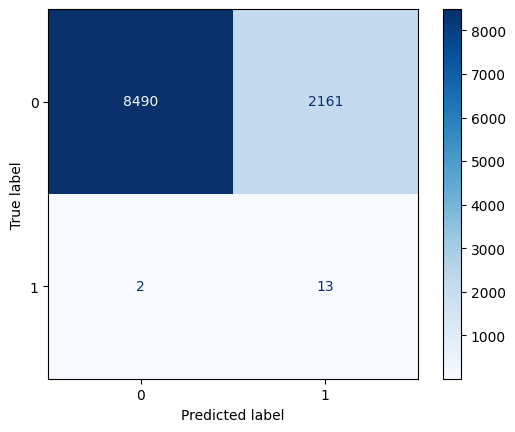

In [114]:
# Checking the predictions using a classification report
print(classification_report(y_test, predictions_svm_bl))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_svm_bl, cmap='Blues')
plt.show()

### Tuned - SVM - Polynomial Kernel 

PIPELINE:

1) Polynomial Feature Expansion

Apply a polynomial transformation to the original input features, generating higher-order and interaction terms that enable the model to capture non-linear relationships.

2) Dimensionality Reduction (PCA)

Use Principal Component Analysis to project the expanded feature set onto a lower-dimensional subspace. This step reduces model complexity, mitigates overfitting, and improves computational efficiency.

3) Support Vector Classification (SVC)

Train an SVC with a polynomial kernel on the PCA-transformed data, leveraging the non-linear feature mapping while keeping the final feature space manageable.

#### Building Tuned Model

In [115]:
# Define a pipeline combining polynomial features, scaling, PCA, and a polynomial kernel SVM
base_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ('PCA', PCA()),
    ('svm_clf', SVC(kernel='poly', probability=True))
])

# Parameter grid for grid search (selected combinations based on prior trials)
param_grid_svm = { 
    'poly_features__degree': [2], # Tried Parameters: 2, 3, 4
    'PCA__n_components': [5],  # Tried Parameters: 2, 3, 4, 5, 6, 10
    'svm_clf__coef0': [0.5],     # Tried Parameters: 0.4, 0.5, 0.6
    'svm_clf__C': [0.5]         # Tried Parameters: 1, 0.7, 0.4, 0.5, 0.3
}

# Cross-validation fold options
fold_options = [7]  # Tried Parameters: 5, 7, 8, 10

# Initialize containers to store search results and track best configuration
all_results = []
best_overall_model = None
best_overall_score = -np.inf
best_overall_params = None
best_fold = None

#### Best Hyperparameters and Scores

In [116]:
# Run GridSearchCV for each fold setting in fold_options
for cv_folds in fold_options:
    print(f"\nRunning GridSearchCV with {cv_folds} folds...")
    
    grid_search = GridSearchCV(
        base_pipeline,
        param_grid=param_grid_svm,
        cv=cv_folds,
        scoring='recall',  # Optimizing for recall due to class imbalance
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)

    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"Best recall with {cv_folds} folds: {best_score:.4f}")
    print("Best params:", best_params)

    # Store results for this fold
    all_results.append({
        'folds': cv_folds,
        'score': best_score,
        'params': best_params,
        'model': grid_search.best_estimator_
    })

    # Update overall best model if performance improves
    if best_score > best_overall_score:
        best_overall_score = best_score
        best_overall_model = grid_search.best_estimator_
        best_overall_params = best_params
        best_fold = cv_folds


Running GridSearchCV with 7 folds...
Fitting 7 folds for each of 1 candidates, totalling 7 fits


Best recall with 7 folds: 0.9285
Best params: {'PCA__n_components': 5, 'poly_features__degree': 2, 'svm_clf__C': 0.5, 'svm_clf__coef0': 0.5}


In [117]:
# Display the best cross-validation configuration based on recall
print(f"Folds: {best_fold}")
print(f"Recall: {best_overall_score:.4f}")
print("Best Parameters:", best_overall_params)

Folds: 7
Recall: 0.9285
Best Parameters: {'PCA__n_components': 5, 'poly_features__degree': 2, 'svm_clf__C': 0.5, 'svm_clf__coef0': 0.5}


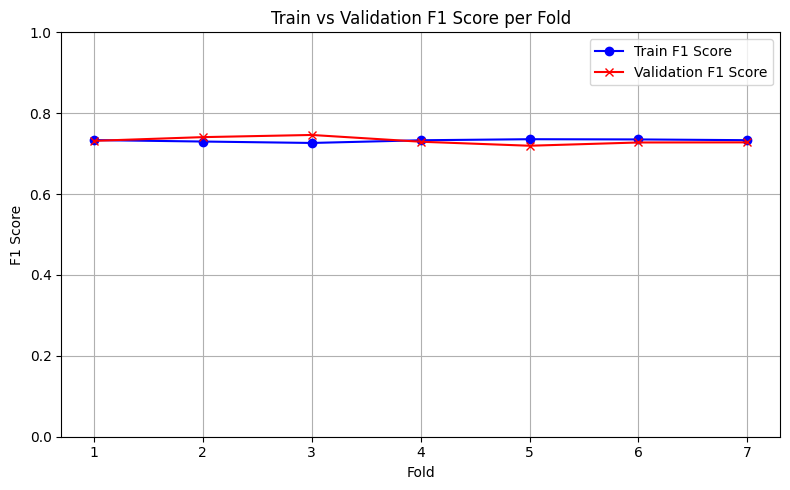

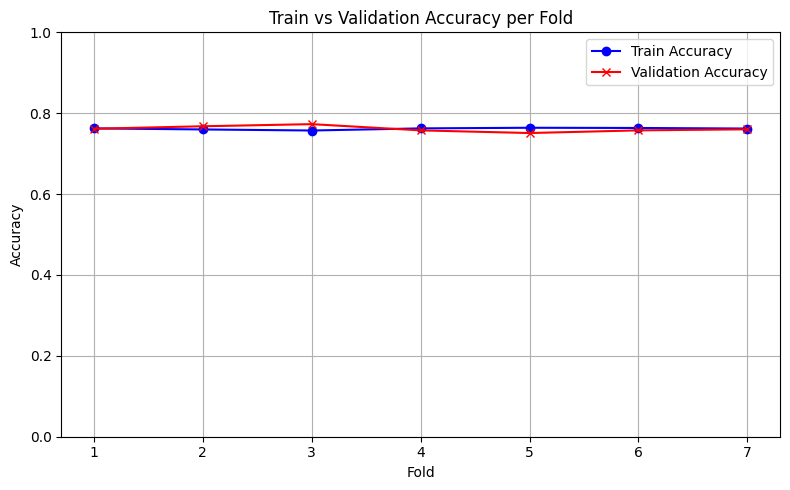

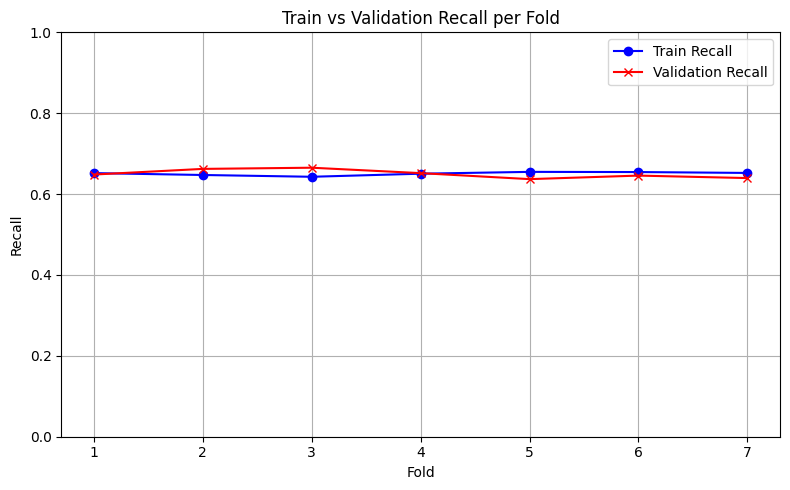

In [118]:
# Rebuild the best-performing SVM pipeline using the optimal hyperparameters
best_pipeline_svm = Pipeline([
    ('poly_features', PolynomialFeatures(
        degree=best_overall_params['poly_features__degree'],
        include_bias=False)),
    ('PCA', PCA(n_components=best_overall_params['PCA__n_components'])),
    ('svm_clf', SVC(
        kernel='poly',
        coef0=best_overall_params['svm_clf__coef0'],
        C=best_overall_params['svm_clf__C'],
        probability=True
    ))
])

# Set up stratified K-fold cross-validation with the best number of folds
skfolds = StratifiedKFold(n_splits=best_fold, shuffle=True, random_state=42)

# Lists to store training and validation metrics for each fold
train_f1s, val_f1s = [], []
train_accs, val_accs = [], []
train_recalls, val_recalls = [], []

# Evaluate the model across folds
for train_index, test_index in skfolds.split(X_train, y_train):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = X_train.iloc[test_index]
    y_val_fold = y_train.iloc[test_index]

    clone_model = clone(best_pipeline_svm)
    clone_model.fit(X_train_fold, y_train_fold)

    y_train_pred = clone_model.predict(X_train_fold)
    y_val_pred = clone_model.predict(X_val_fold)

    train_f1s.append(f1_score(y_train_fold, y_train_pred))
    val_f1s.append(f1_score(y_val_fold, y_val_pred))

    train_accs.append(accuracy_score(y_train_fold, y_train_pred))
    val_accs.append(accuracy_score(y_val_fold, y_val_pred))

    train_recalls.append(recall_score(y_train_fold, y_train_pred))
    val_recalls.append(recall_score(y_val_fold, y_val_pred))

# Plot performance metrics per fold for visual comparison
def plot_metric(train, val, metric_name):
    folds = range(1, len(train) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(folds, train, marker='o', label=f"Train {metric_name}", color='blue')
    plt.plot(folds, val, marker='x', label=f"Validation {metric_name}", color='red')
    plt.title(f"Train vs Validation {metric_name} per Fold")
    plt.xlabel("Fold")
    plt.ylabel(metric_name)
    plt.ylim(0, 1)
    plt.xticks(folds)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric(train_f1s, val_f1s, "F1 Score")
plot_metric(train_accs, val_accs, "Accuracy")
plot_metric(train_recalls, val_recalls, "Recall")

#### Testing the Tuned Model

In [119]:
# Fit the best SVM pipeline on the full training set
best_pipeline_svm.fit(X_train, y_train)

# Generate predictions on the test set using the optimized model
y_pred_svm_clf_opt = best_pipeline_svm.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     10651
           1       0.00      0.20      0.00        15

    accuracy                           0.87     10666
   macro avg       0.50      0.53      0.47     10666
weighted avg       1.00      0.87      0.93     10666



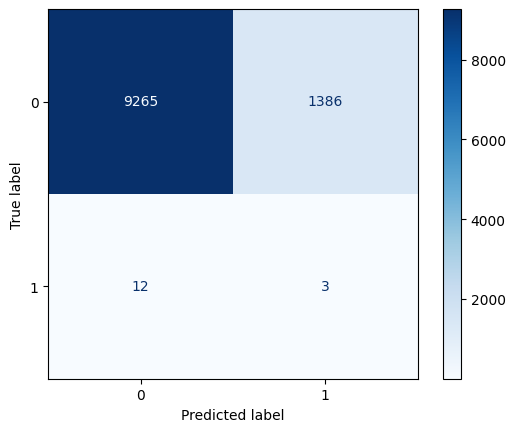

In [120]:
# Check the predictions using a classification report
print(classification_report(y_test, y_pred_svm_clf_opt))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm_clf_opt, cmap='Blues')
plt.show()


### Baseline - SVM - Gaussian (RBF) Kernel

In [121]:
# Create a pipeline with an RBF kernel SVM classifier
rbf_kernel_svm_clf = Pipeline([ 
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])

# Train the RBF SVM on the full training set
rbf_kernel_svm_clf.fit(X_train, y_train)

# Predict on the test set using the trained RBF SVM
predictions_svm_rbf = rbf_kernel_svm_clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10651
           1       0.00      1.00      0.00        15

    accuracy                           0.00     10666
   macro avg       0.00      0.50      0.00     10666
weighted avg       0.00      0.00      0.00     10666



/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


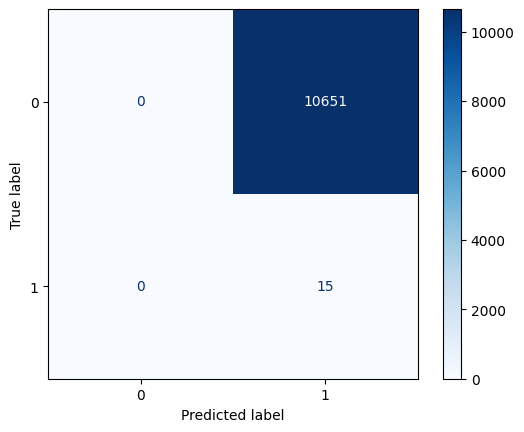

In [122]:
# Print classification metrics for the RBF SVM model
print(classification_report(y_test, predictions_svm_rbf))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions_svm_rbf, cmap='Blues')
plt.show()

### Tuned - SVM - Gaussian (RBF) Kernel

#### Building Tuned Model

In [123]:
# Define a pipeline with scaling, PCA, and RBF kernel SVM
base_pipeline = Pipeline([
    ("Scaler", StandardScaler()), 
    ('PCA', PCA()),
    ('svm_clf', SVC(kernel='rbf', probability=True))
])

# Grid search parameter options (based on previous trials)
param_grid_svm = { 
    'PCA__n_components': [1], # Tried Parameters: 0.5, 1, 2, 3, 5
    'svm_clf__gamma': [50],  # Tried Parameters: 1, 5, 10, 15, 20, 40, 50, 60
    'svm_clf__C': [0.4]      # Tried Parameters: 0.3, 0.4, 0.5, 1
}

# Number of CV folds to test
fold_options = [7]

# Initialize tracking for grid search results
all_results = []
best_overall_model = None
best_overall_score = -np.inf
best_overall_params = None
best_fold = None

#### Best Hyperparameters and Scores

In [124]:
from sklearn.metrics import recall_score

# Perform GridSearchCV across the specified fold configurations
for cv_folds in fold_options:
    print(f"\nRunning GridSearchCV with {cv_folds} folds...")

    grid_search = GridSearchCV(
        base_pipeline,
        param_grid=param_grid_svm,
        cv=cv_folds,
        scoring='recall',  # Prioritizing recall due to class imbalance
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)

    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"Best recall with {cv_folds} folds: {best_score:.4f}")
    print("Best params:", best_params)

    # Store results for this fold configuration
    all_results.append({
        'folds': cv_folds,
        'score': best_score,
        'params': best_params,
        'model': grid_search.best_estimator_
    })

    # Track the overall best model
    if best_score > best_overall_score:
        best_overall_score = best_score
        best_overall_model = grid_search.best_estimator_
        best_overall_params = best_params
        best_fold = cv_folds


Running GridSearchCV with 7 folds...
Fitting 7 folds for each of 1 candidates, totalling 7 fits


Best recall with 7 folds: 0.9270
Best params: {'PCA__n_components': 1, 'svm_clf__C': 0.4, 'svm_clf__gamma': 50}


In [125]:
# Display the best model configuration based on cross-validated recall
print(f"Folds: {best_fold}")
print(f"Recall: {best_overall_score:.4f}")
print("Best Parameters:", best_overall_params)

Folds: 7
Recall: 0.9270
Best Parameters: {'PCA__n_components': 1, 'svm_clf__C': 0.4, 'svm_clf__gamma': 50}


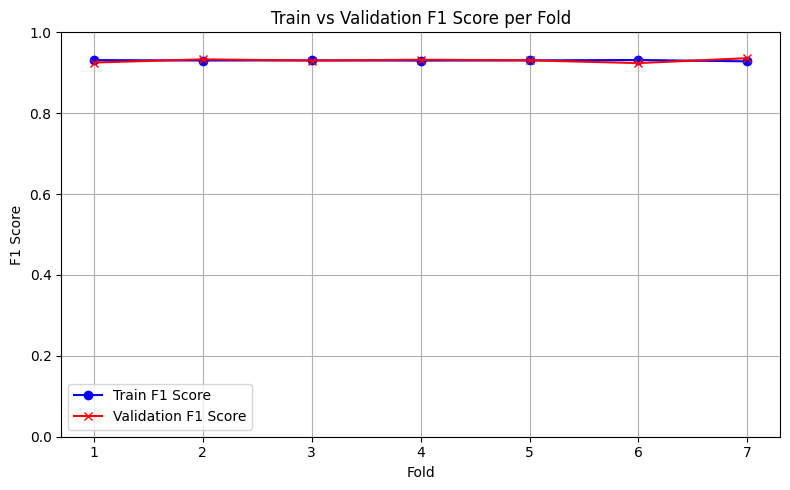

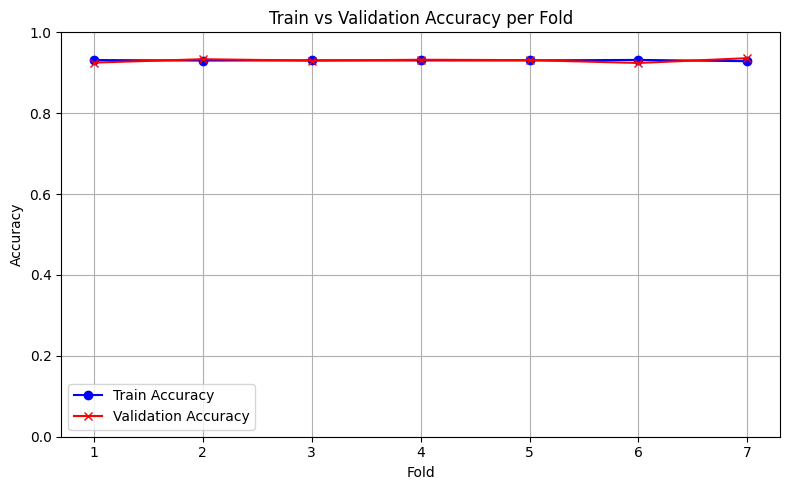

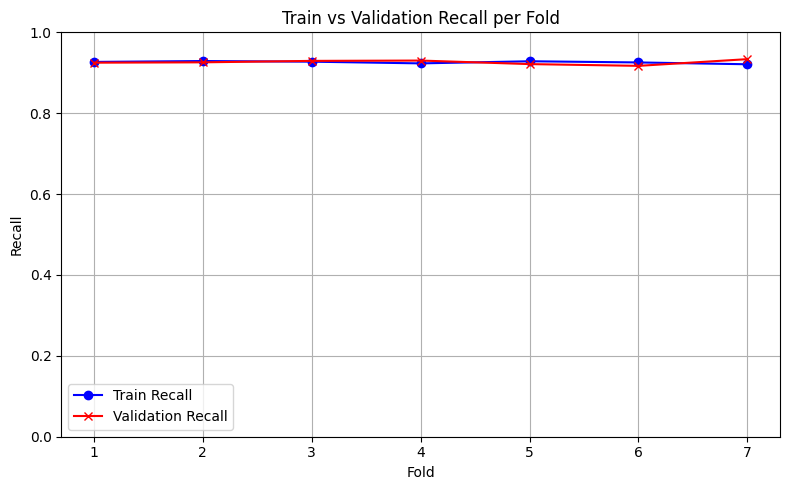

In [126]:
# Build the final RBF SVM pipeline using the best hyperparameters
best_pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('PCA', PCA(n_components=best_overall_params['PCA__n_components'])),
    ('svm_clf', SVC(
        kernel='rbf',
        gamma=best_overall_params['svm_clf__gamma'],
        C=best_overall_params['svm_clf__C'],
        probability=True
    ))
])

# Stratified K-fold setup for consistent class distribution across folds
skfolds = StratifiedKFold(n_splits=best_fold, shuffle=True, random_state=42)

# Initialize lists to store training and validation metrics
train_f1s, val_f1s = [], []
train_accs, val_accs = [], []
train_recalls, val_recalls = [], []

# Evaluate model performance across folds
for train_index, test_index in skfolds.split(X_train, y_train):
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_val_fold = X_train.iloc[test_index]
    y_val_fold = y_train.iloc[test_index]

    clone_model = clone(best_pipeline_svm)
    clone_model.fit(X_train_fold, y_train_fold)

    y_train_pred = clone_model.predict(X_train_fold)
    y_val_pred = clone_model.predict(X_val_fold)

    train_f1s.append(f1_score(y_train_fold, y_train_pred))
    val_f1s.append(f1_score(y_val_fold, y_val_pred))

    train_accs.append(accuracy_score(y_train_fold, y_train_pred))
    val_accs.append(accuracy_score(y_val_fold, y_val_pred))

    train_recalls.append(recall_score(y_train_fold, y_train_pred))
    val_recalls.append(recall_score(y_val_fold, y_val_pred))

# Plot training vs validation metrics for each fold
def plot_metric(train, val, metric_name):
    folds = range(1, len(train) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(folds, train, marker='o', label=f"Train {metric_name}", color='blue')
    plt.plot(folds, val, marker='x', label=f"Validation {metric_name}", color='red')
    plt.title(f"Train vs Validation {metric_name} per Fold")
    plt.xlabel("Fold")
    plt.ylabel(metric_name)
    plt.ylim(0, 1)
    plt.xticks(folds)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric(train_f1s, val_f1s, "F1 Score")
plot_metric(train_accs, val_accs, "Accuracy")
plot_metric(train_recalls, val_recalls, "Recall")

#### Testing the Tuned Model

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     10651
           1       0.02      0.93      0.03        15

    accuracy                           0.92     10666
   macro avg       0.51      0.93      0.50     10666
weighted avg       1.00      0.92      0.96     10666



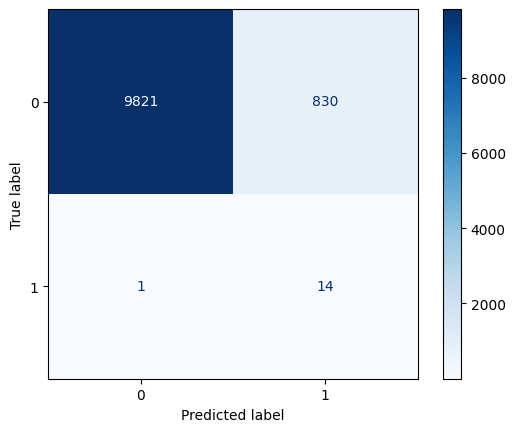

In [127]:
# Retrieve the best-performing pipeline from the GridSearchCV
best_pipeline_svm = grid_search.best_estimator_

# Fit the best pipeline on the full training set
best_pipeline_svm.fit(X_train, y_train)

# Generate predictions on the test set using the optimized SVM pipeline
y_pred_svm_clf_opt = best_pipeline_svm.predict(X_test)

# Evaluate model performance using classification report and confusion matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_svm_clf_opt))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm_clf_opt, cmap='Blues')
